<a href="https://colab.research.google.com/github/PandukaBandara99/ML-Books/blob/main/MLOPS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mahela Panduka Bandara ; <br>
UG @ Dpt. of Electronic & Electrical Engineering ;<br>
University of Peradeniya ;<br>
2024/3<br>

Email : e19039@end.pdn.ac.lk<br>
LinkedIN : https://www.linkedin.com/in/pandukabandara/<br>

References :https://www.coursera.org/specializations/machine-learning-engineering-for-production-mlops

# 1.0 Neural Architecture Search


## 1.1 Hyperparameter tuning

### 1.1.1 Neural Architecture Search


> Neural architecture search (NAS) is is a technique for automating the
design of artificial neural networks.It helps finding the optimal architecture.AutoML is an algorithm to automate this search

Two types of parameters in an ML model.

1. Trainable parameters:Learned by the algorithm during training
    - e.g. weights of a neural network
2.  Hyperparameters: set before launching the learning process
    - e.g: learning rate or the number of units in a dense layer

Manual hyperparameter tuning is not scalable.Tuning them manually can be a real brain teaser.

> Automating hyperparameter tuning can be done with with **Keras Tuner**




### 1.1.2 Intro to Keras Tuner

#### Download and prepare the dataset

Let us first load the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) into your workspace.

In [ ]:
# Import keras
from tensorflow import keras

In [ ]:
# Download the dataset and split into train and test sets
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


For preprocessing, normalize the pixel values to make the training converge faster.

In [ ]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

#### Baseline Performance

First have a baseline performance using arbitrarily handpicked parameters so the developer can compare the results later.

In [ ]:
# Build the baseline model using the Sequential API
b_model = keras.Sequential()
b_model.add(keras.layers.Flatten(input_shape=(28, 28)))
b_model.add(keras.layers.Dense(units=512, activation='relu', name='dense_1')) # You will tune this layer later
b_model.add(keras.layers.Dropout(0.2))
b_model.add(keras.layers.Dense(10, activation='softmax'))

# Print model summary
b_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Then setup the loss, metrics, and the optimizer. The learning rate is also a hyperparameter that can tune automatically but for now,set it at `0.001`.

In [ ]:
# Setup the training parameters
b_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

With all settings set,start training the model.

In [ ]:
# Number of training epochs.
NUM_EPOCHS = 10

# Train the model
b_model.fit(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 19s 12ms/step - loss: 0.5160 - accuracy: 0.8154 - val_loss: 0.3935 - val_accuracy: 0.8593
Epoch 2/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3905 - accuracy: 0.8570 - val_loss: 0.3590 - val_accuracy: 0.8737
Epoch 3/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3553 - accuracy: 0.8692 - val_loss: 0.3711 - val_accuracy: 0.8673
Epoch 4/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3346 - accuracy: 0.8758 - val_loss: 0.3454 - val_accuracy: 0.8727
Epoch 5/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.3160 - accuracy: 0.8834 - val_loss: 0.3317 - val_accuracy: 0.8812
Epoch 6/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3000 - accuracy: 0.8888 - val_loss: 0.3328 - val_accuracy: 0.8783
Epoch 7/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2901 - accuracy: 0.8920 - val_loss: 0.3067 -

Finally, performs against the test set.

In [ ]:
# Evaluate model on the test set
b_eval_dict = b_model.evaluate(img_test, label_test, return_dict=True)

313/313 [==============================] - 1s 4ms/step - loss: 0.3343 - accuracy: 0.8842


Define a helper function for displaying the results so it's easier to compare later.

In [ ]:
# Define helper function
def print_results(model, model_name, layer_name, eval_dict):
  '''
  Prints the values of the hyparameters to tune, and the results of model evaluation

  Args:
    model (Model) - Keras model to evaluate
    model_name (string) - arbitrary string to be used in identifying the model
    layer_name (string) - name of the layer to tune
    eval_dict (dict) -  results of model.evaluate
  '''
  print(f'\n{model_name}:')

  print(f'number of units in 1st Dense layer: {model.get_layer(layer_name).units}')
  print(f'learning rate for the optimizer: {model.optimizer.lr.numpy()}')

  for key,value in eval_dict.items():
    print(f'{key}: {value}')

# Print results for baseline model
print_results(b_model, 'BASELINE MODEL', 'dense_1', b_eval_dict)


BASELINE MODEL:
number of units in 1st Dense layer: 512
learning rate for the optimizer: 0.0010000000474974513
loss: 0.3342683017253876
accuracy: 0.8841999769210815


#### Keras Tuner

To perform hypertuning with Keras Tuner, need to:

* Define the model
* Select which hyperparameters to tune
* Define its search space
* Define the search strategy

##### Install and import packages



In [ ]:
# Install Keras Tuner
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
# Import required packages
import tensorflow as tf
import keras_tuner as kt

##### Define the model

The model set up for hypertuning is called a *hypermodel*. When build this model, need to define the hyperparameter search space in addition to the model architecture.

Candefine a hypermodel through two approaches:

* By using a model builder function
* By [subclassing the `HyperModel` class](https://keras-team.github.io/keras-tuner/#you-can-use-a-hypermodel-subclass-instead-of-a-model-building-function) of the Keras Tuner API

The function below basically builds the same model used earlier. The difference is there are two hyperparameters that are setup for tuning:

* the number of hidden units of the first Dense layer
* the learning rate of the Adam optimizer

* use its `Int()` method to define the search space for the Dense units. This allows to set a minimum and maximum value, as well as the step size when incrementing between these values.

* use its `Choice()` method for the learning rate. This allows to define discrete values to include in the search space when hypertuning.



In [ ]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''

  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='tuned_dense_1'))

  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

##### Instantiate the Tuner and perform hypertuning



Now that you have the model builder, you can then define how the tuner can find the optimal set of hyperparameters, also called the search strategy. Keras Tuner has [four tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/) available with built-in strategies - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.

Strategies for Karas Auto Tuner:

| Strategy              | Description                                                                                                                                                                                                                                                                                           | Pros                                                                                                            | Cons                                                                                                                   |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| RandomSearch          | Randomly selects hyperparameter combinations from a predefined search space.                                                                                                                                                                                                                         | - Simple to implement - Good for initial exploration of hyperparameter space - May find good solutions with fewer evaluations                                               | - Can be inefficient for large search spaces - Doesn't adapt based on previous evaluations                                 |
| Hyperband             | Implements the Hyperband algorithm, which performs successive halving of configurations with different resource allocations (epochs). Prunes poorly performing configurations early on.                                                                                                          | - Efficiently allocates resources to promising configurations - Good for large search spaces - Provides trade-off between exploration and exploitation                                                                       | - Requires specifying a maximum resource budget - May not perform optimally with very small budgets                           |
| Bayesian Optimization| Utilizes Bayesian optimization techniques to model the objective function and decide which hyperparameter configurations to explore next based on previous evaluations.                                                                                                                               | - Efficiently explores the hyperparameter space, focusing on promising regions - Adapts to previous evaluations, leading to faster convergence                                            | - Requires careful specification of prior beliefs and parameterization - Computationally more expensive than random search       |
| Sklearn               | Integrates with scikit-learn's GridSearchCV or RandomizedSearchCV, which perform exhaustive or random search over a specified hyperparameter grid.                                                                                                                                                 | - Well-documented and widely-used - Works seamlessly with scikit-learn models - Easy to parallelize for faster search                                                               | - Can be computationally expensive, especially with large search spaces - May not efficiently explore continuous hyperparameter spaces |
| Genetic Algorithms   | Evolves a population of hyperparameter configurations over multiple generations using principles inspired by biological evolution, such as selection, crossover, and mutation.                                                                                                                    | - Can handle non-linear and non-convex search spaces - Well-suited for discrete and combinatorial hyperparameters - May find novel solutions not explored by other methods                      | - Computationally expensive, especially with large populations and generations - Requires careful tuning of genetic operators |
| Tree-structured Parzen Estimator (TPE) | Utilizes a tree-structured Parzen estimator to model the objective function and select promising hyperparameter configurations to explore next, focusing on regions likely to improve performance.                                                                                                   | - Efficiently explores the hyperparameter space, focusing on promising regions - Adapts to previous evaluations, leading to faster convergence                                            | - May require tuning of TPE-specific parameters - Less intuitive than other methods                                          |
| Simulated Annealing   | Inspired by the physical annealing process, Simulated Annealing probabilistically accepts worse hyperparameter configurations with decreasing probability over time, allowing exploration of the search space while gradually focusing on promising regions.                                           | - Can escape local optima by accepting worse solutions with a certain probability - Can explore large search spaces efficiently - Well-suited for noisy or stochastic objective functions       | - Requires careful tuning of annealing schedule and acceptance criteria - May be slow to converge compared to other methods       |



Hyperband is an algorithm specifically developed for hyperparameter optimization. It uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket wherein the algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. You can read about the intuition behind the algorithm in section 3 of [this paper](https://arxiv.org/pdf/1603.06560.pdf).

Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer. You will see these parameters (i.e. `factor` and `max_epochs` passed into the initializer below). In addition, you will also need to define the following to instantiate the Hyperband tuner:

* the hypermodel (built by your model builder function)
* the `objective` to optimize (e.g. validation accuracy)
* a `directory` to save logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.
* the `project_name` to differentiate with other runs. This will be used as a subdirectory name under the `directory`.



In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_dir',
                     project_name='kt_hyperband')

Let's see a summary of the hyperparameters that you will tune:

In [ ]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Pass in a callback to stop training early when a metric is not improving. Below, we define an [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to monitor the validation loss and stop training if it's not improving after 5 epochs.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [ ]:
# Perform hypertuning
tuner.search(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 02m 24s]
val_accuracy: 0.84375

Best val_accuracy So Far: 0.890500009059906
Total elapsed time: 00h 31m 02s


Now ,can get the top performing model with the [get_best_hyperparameters()](https://keras-team.github.io/keras-tuner/documentation/tuners/#get_best_hyperparameters-method)  method.

In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.



#### Build and train the model



Now with the best set of hyperparameters, rebuild the hypermodel with these values and retrain it.

In [ ]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 tuned_dense_1 (Dense)       (None, 288)               226080    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2890      
                                                                 
Total params: 228970 (894.41 KB)
Trainable params: 228970 (894.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the hypertuned model
h_model.fit(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5205 - accuracy: 0.8135 - val_loss: 0.4036 - val_accuracy: 0.8545
Epoch 2/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3974 - accuracy: 0.8555 - val_loss: 0.3768 - val_accuracy: 0.8564
Epoch 3/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3619 - accuracy: 0.8677 - val_loss: 0.3442 - val_accuracy: 0.8758
Epoch 4/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3394 - accuracy: 0.8736 - val_loss: 0.3677 - val_accuracy: 0.8585
Epoch 5/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3233 - accuracy: 0.8793 - val_loss: 0.3201 - val_accuracy: 0.8854
Epoch 6/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3057 - accuracy: 0.8844 - val_loss: 0.3255 - val_accuracy: 0.8852
Epoch 7/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2978 - accuracy: 0.8895 - val_loss: 0.3231 - val_ac

Get its performance against the test set.

In [ ]:
# Evaluate the hypertuned model against the test set
h_eval_dict = h_model.evaluate(img_test, label_test, return_dict=True)

313/313 [==============================] - 1s 3ms/step - loss: 0.3545 - accuracy: 0.8754


Compare the results we got with the baseline model we used at the start of the notebook. Results may vary but will usually get a model that has less units in the dense layer, while having comparable loss and accuracy. This indicates that reduced the model size and saved compute resources while still having more or less the same accuracy.

In [ ]:
# Print results of the baseline and hypertuned model
print_results(b_model, 'BASELINE MODEL', 'dense_1', b_eval_dict)
print_results(h_model, 'HYPERTUNED MODEL', 'tuned_dense_1', h_eval_dict)


BASELINE MODEL:
number of units in 1st Dense layer: 512
learning rate for the optimizer: 0.0010000000474974513
loss: 0.3342683017253876
accuracy: 0.8841999769210815

HYPERTUNED MODEL:
number of units in 1st Dense layer: 288
learning rate for the optimizer: 0.0010000000474974513
loss: 0.3545226752758026
accuracy: 0.8754000067710876


## 1.2 Intro to Automated Machine Learning(AutoML)

### 1.2.1 Neural Architecture Search


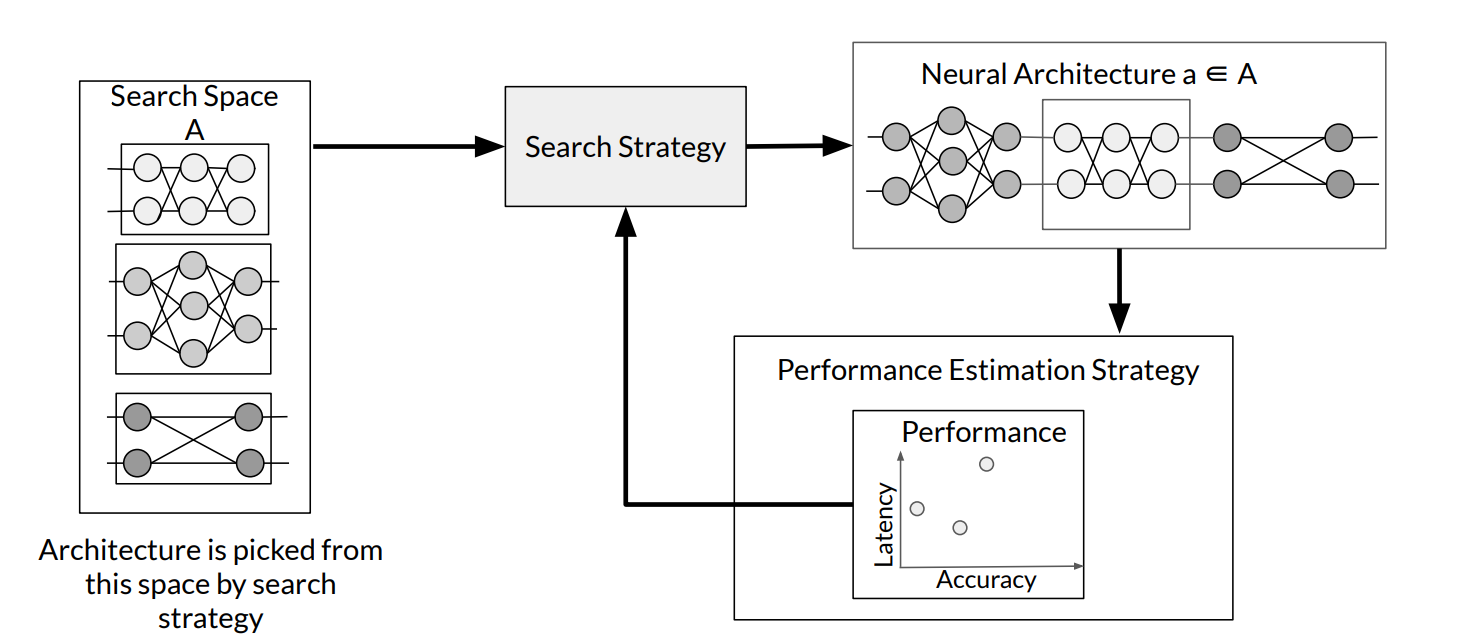

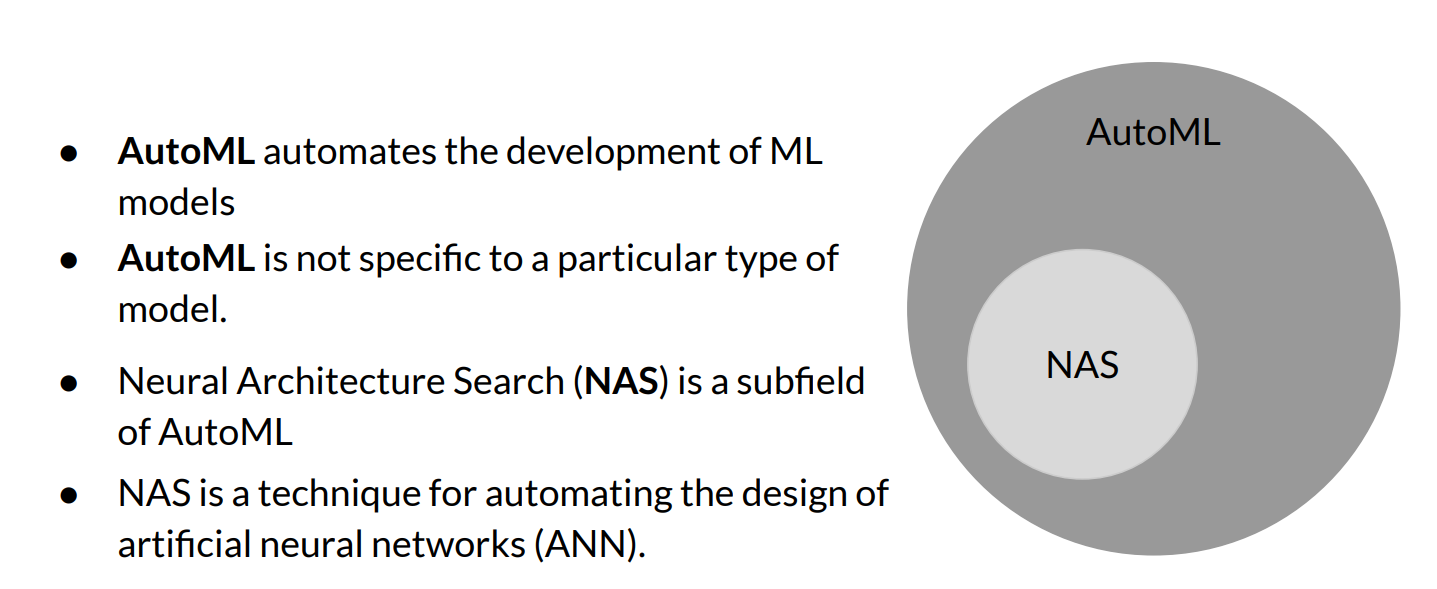

### 1.2.2 Understanding Search Spaces


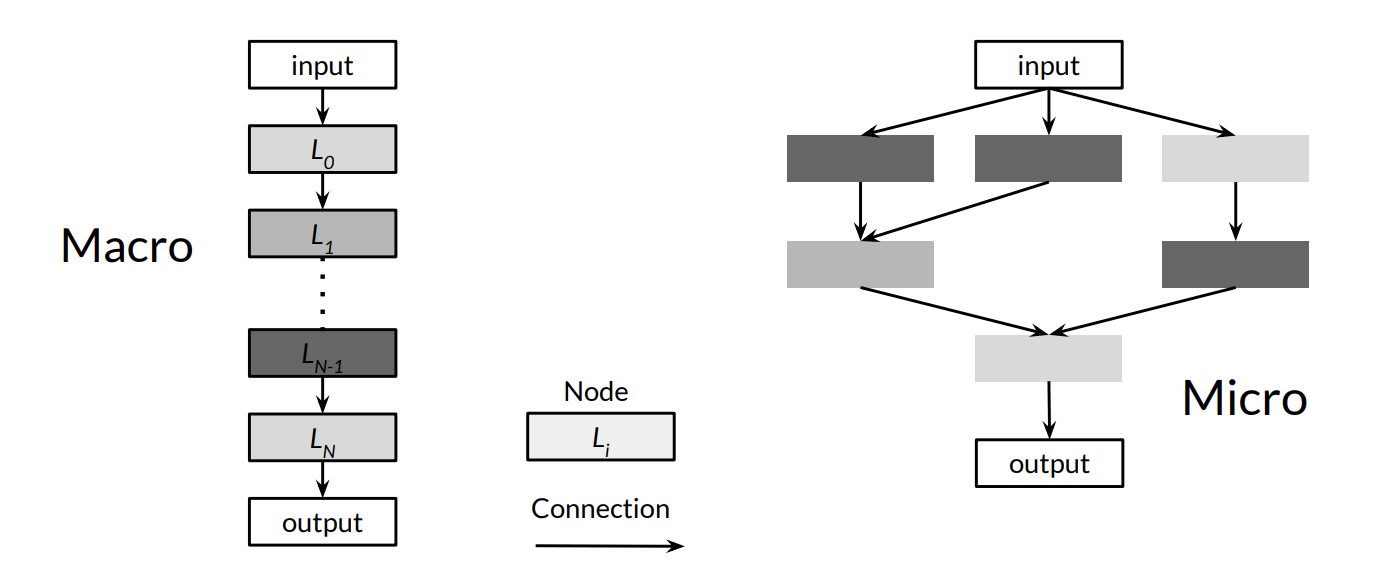

#### Macro Architecture Search Space


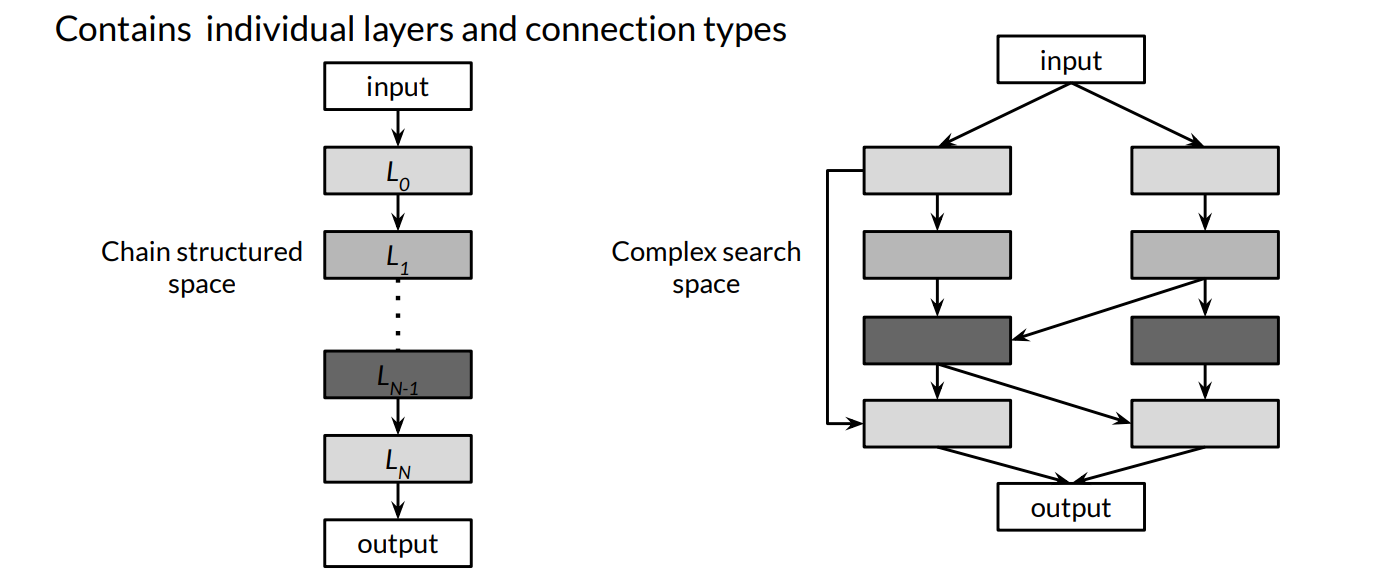

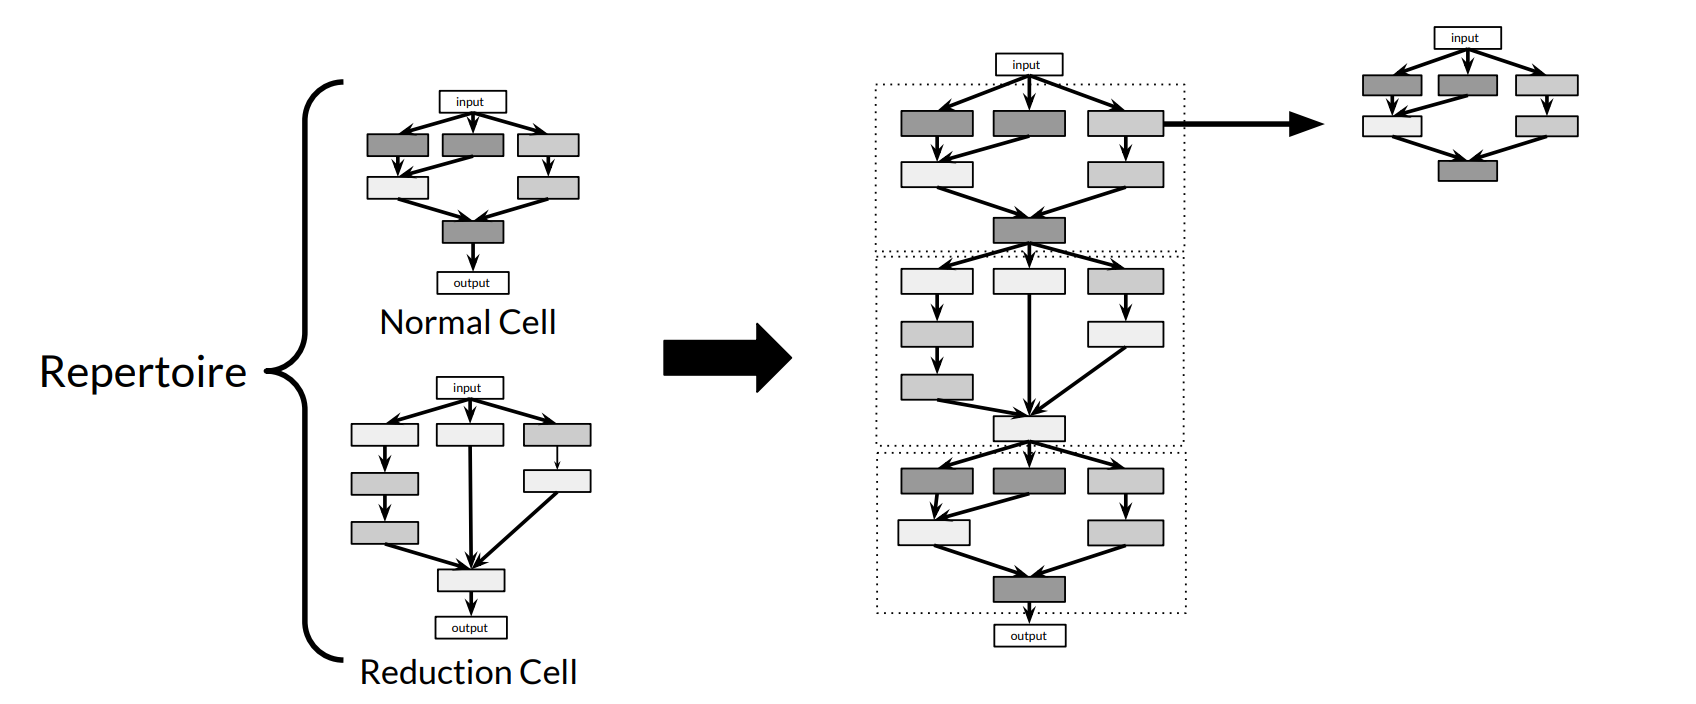

### 1.2.3 Search Strategies

#### Grid Search and Random Search


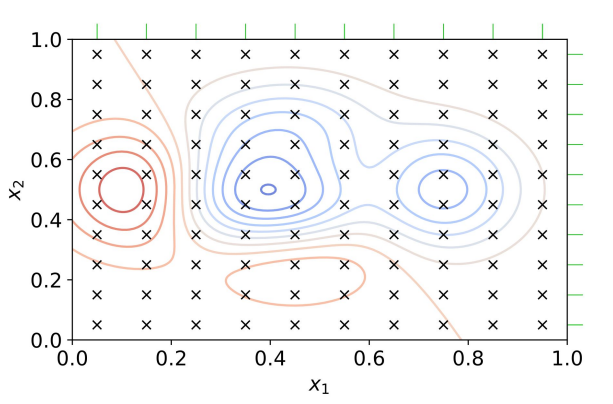

- Grid Search : Exhaustive search approach on fixed grid
values
- Random Search : Random Values
- Both suited for smaller search spaces.Both quickly fail with growing size of search space.


#### Bayesian Optimization


- Assumes that a specific probability
distribution, is underlying the performance.
- Tested architectures constrain the
probability distribution and guide the
selection of the next option.

#### Evolutionary Methods

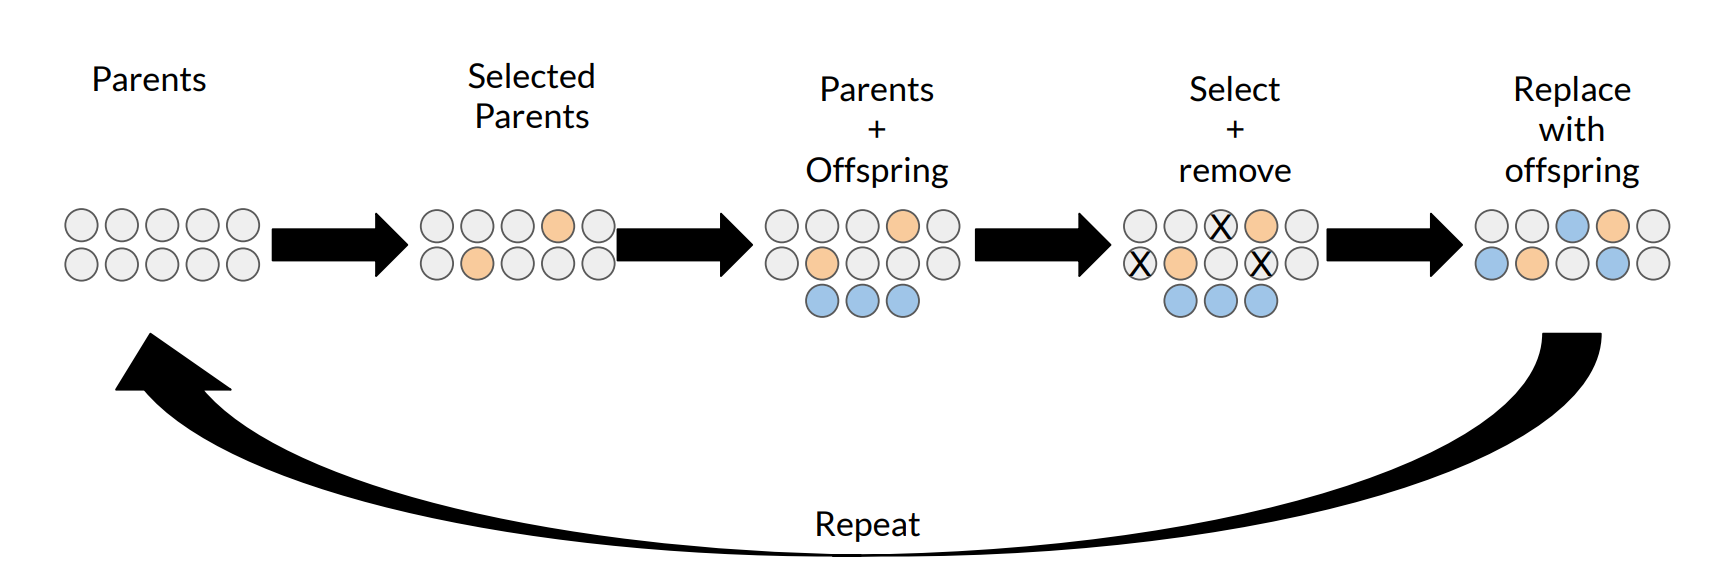

#### Reinforcement Learning


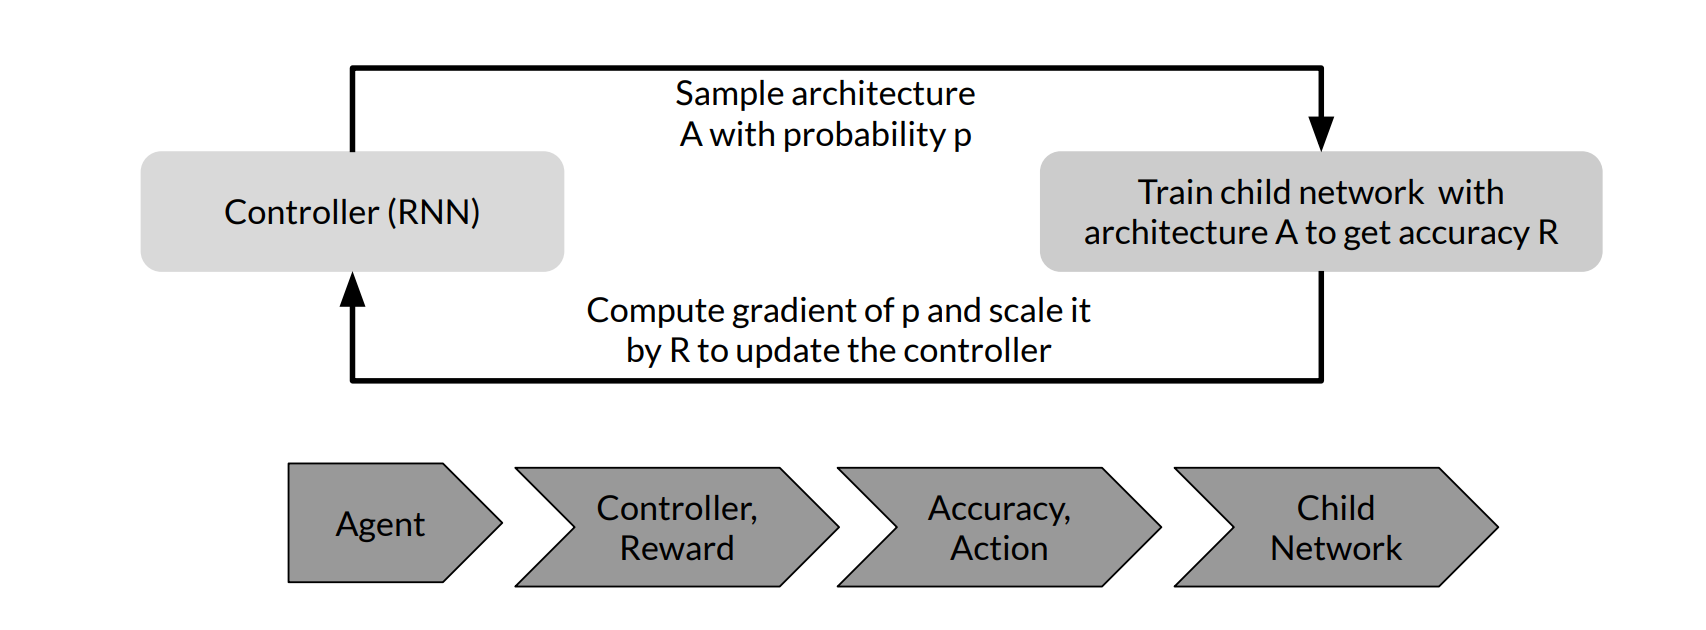

### 1.2.4 Measuring AutoML Efficacy


Strategies to Reduce the Cost :
1. Lower fidelity estimates
2. Learning Curve Extrapolation
3. Weight Inheritance/ Network Morphisms

#### Lower Fidelity Estimates


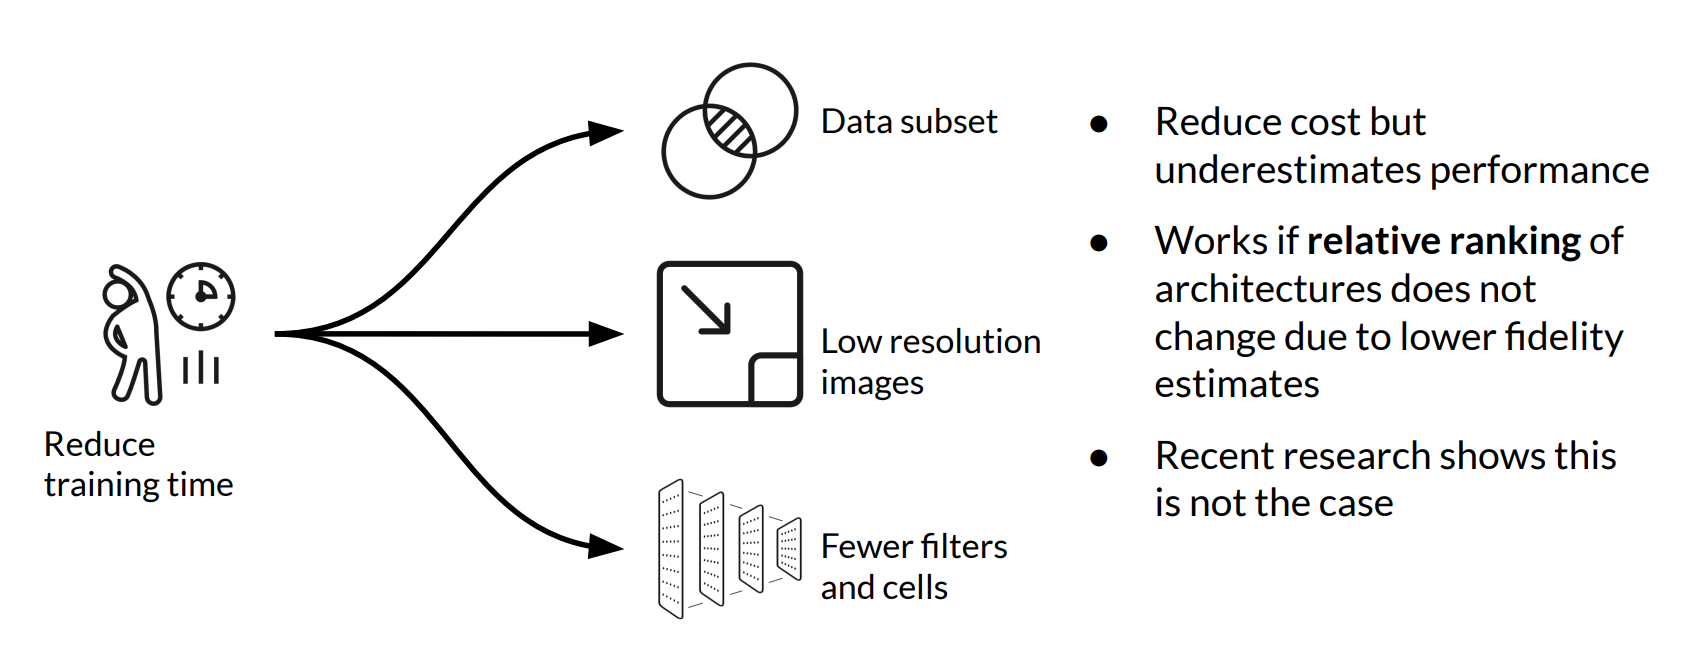

#### Learning Curve Extrapolation


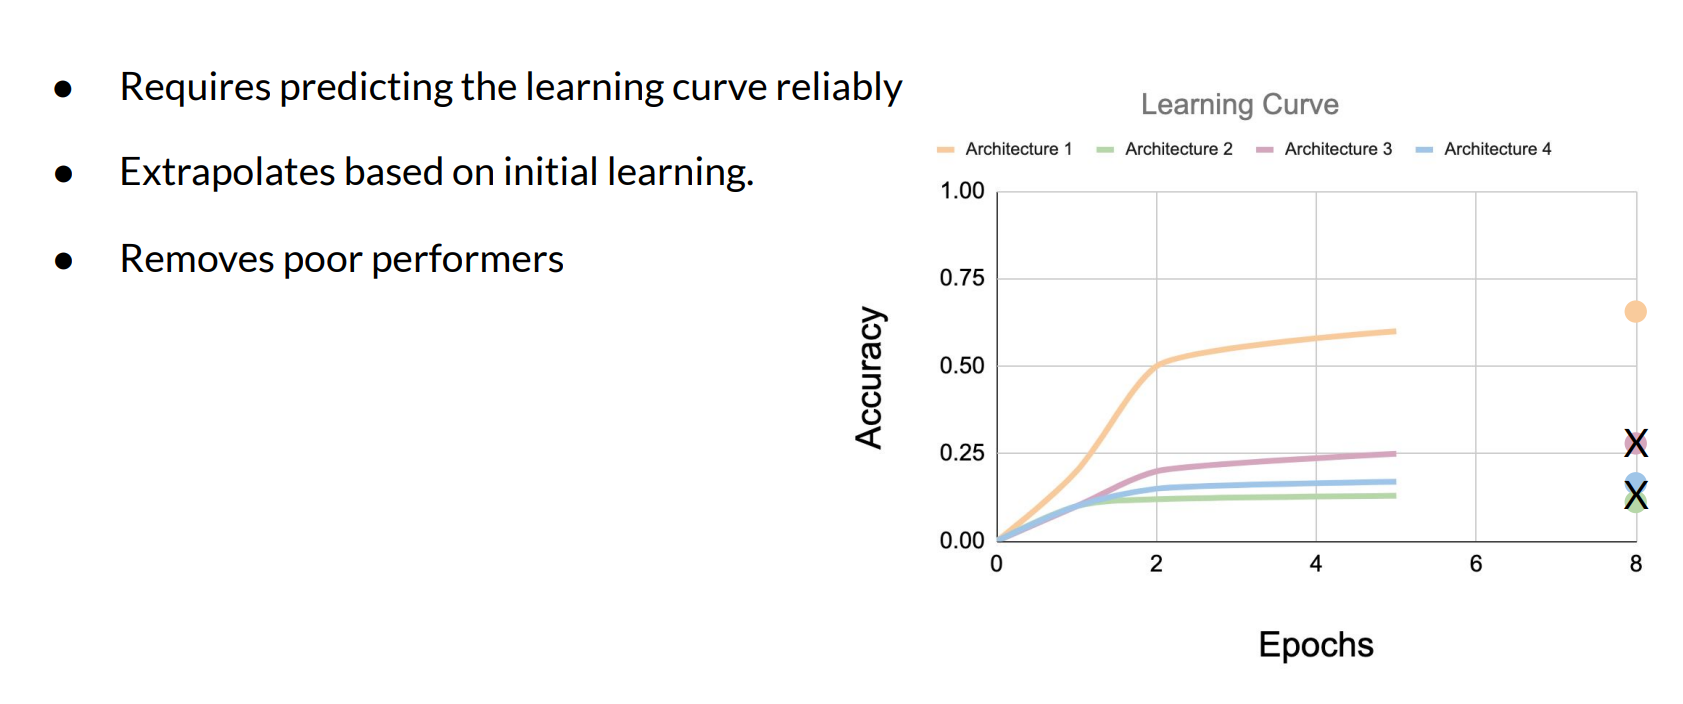

#### Weight Inheritance/Network Morphisms


- Initialize weights of new architectures based on previously trained
architectures
  - Similar to transfer learning
- Uses Network Morphism
- Underlying function unchanged
  - New network inherits knowledge from parent network.
  - Computational speed up: only a few days of GPU usage
  - Network size not inherently bounded


### 1.2.5 AutoML on the Cloud

#### Amazon SageMaker Autopilot

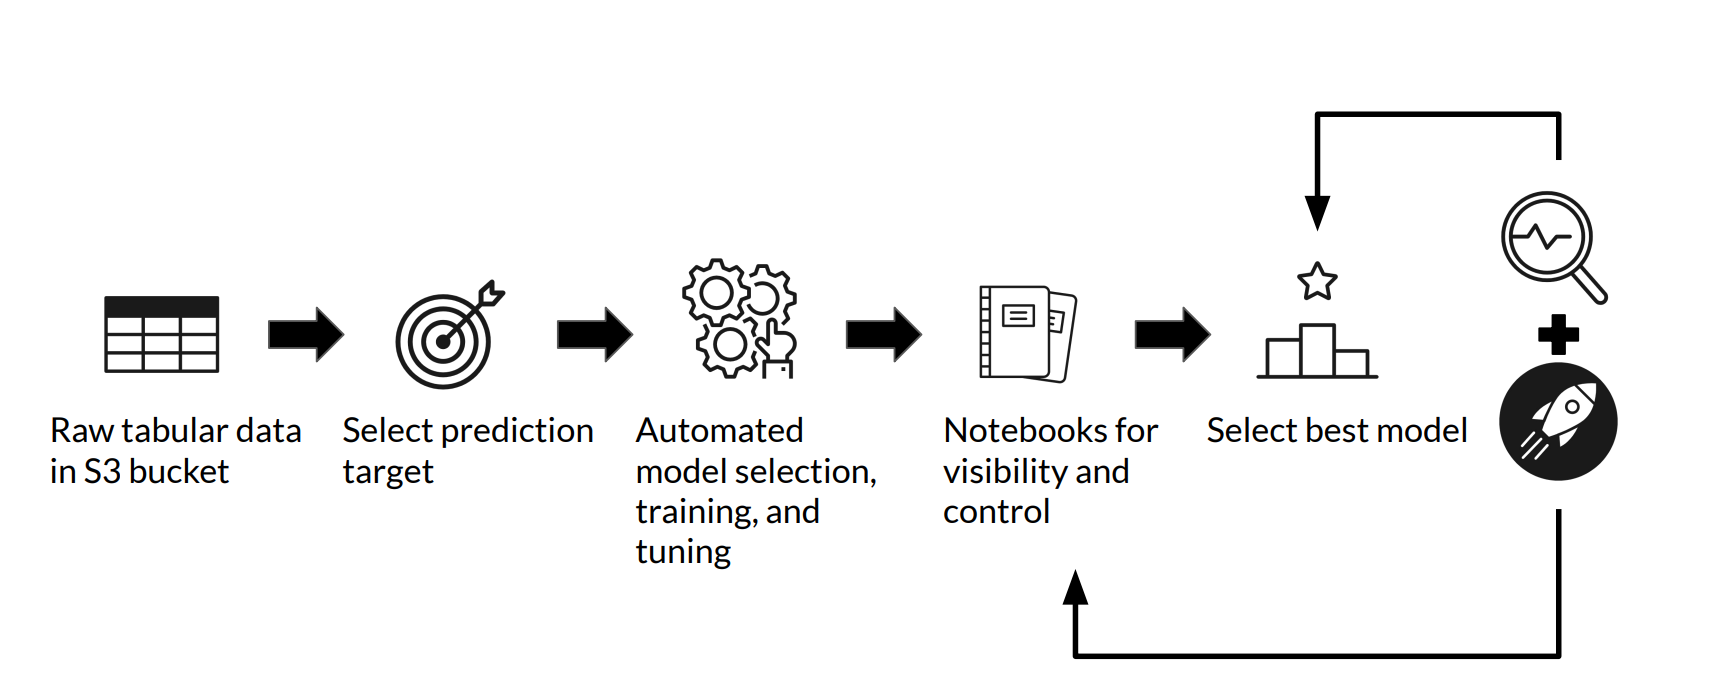

Key features :
- Quick Iteration
- High quality models
- Performance ranked
- Selected features
- Notebooks for reproducibility


Typical use cases :
- Price Prediction ( Stocks, Utilities , Real estate )
- Churn Prediction ( Prevent customer loss, Pattern analysis)
- Risk Assessment ( Individuals, Assets, Companies)






#### Microsoft Azure

Key features
- Quick customization ( Model, Control settings)
- Automated Feature Engineering
- Data Visualization
- Intelligent stopping
- Experiment summaries , Metric visualizations
- Model Interpretability
- Pattern Discovery



#### Google Cloud AutoML


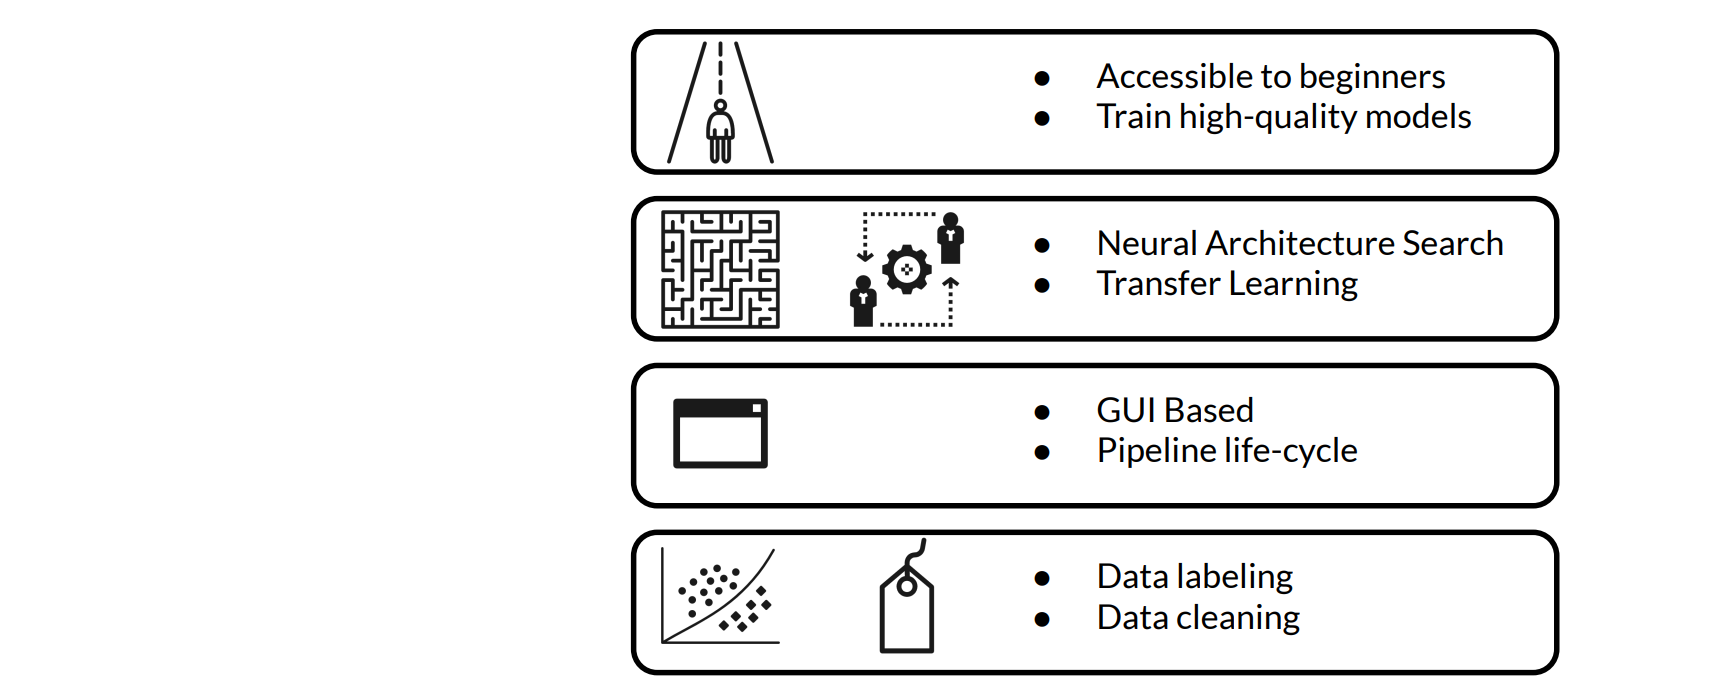

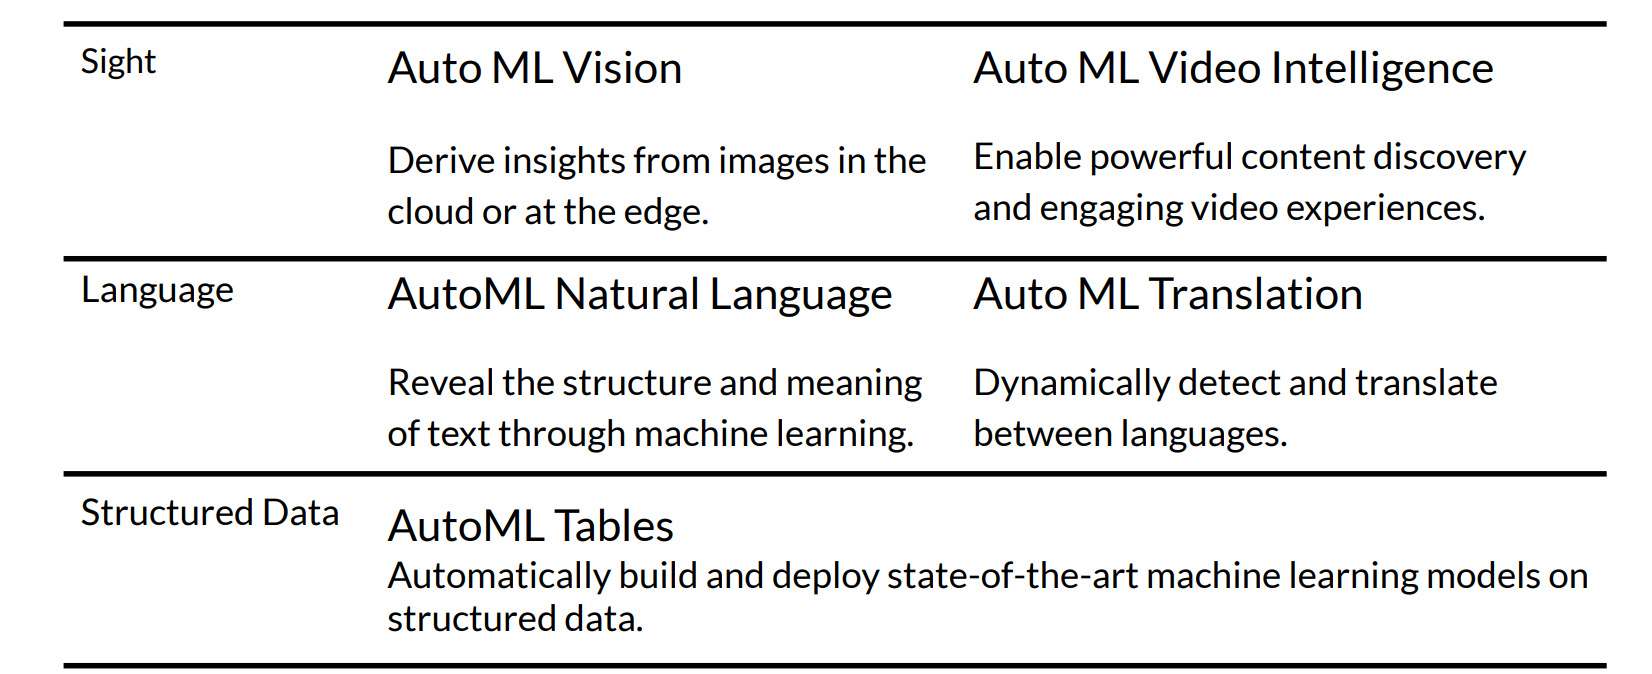

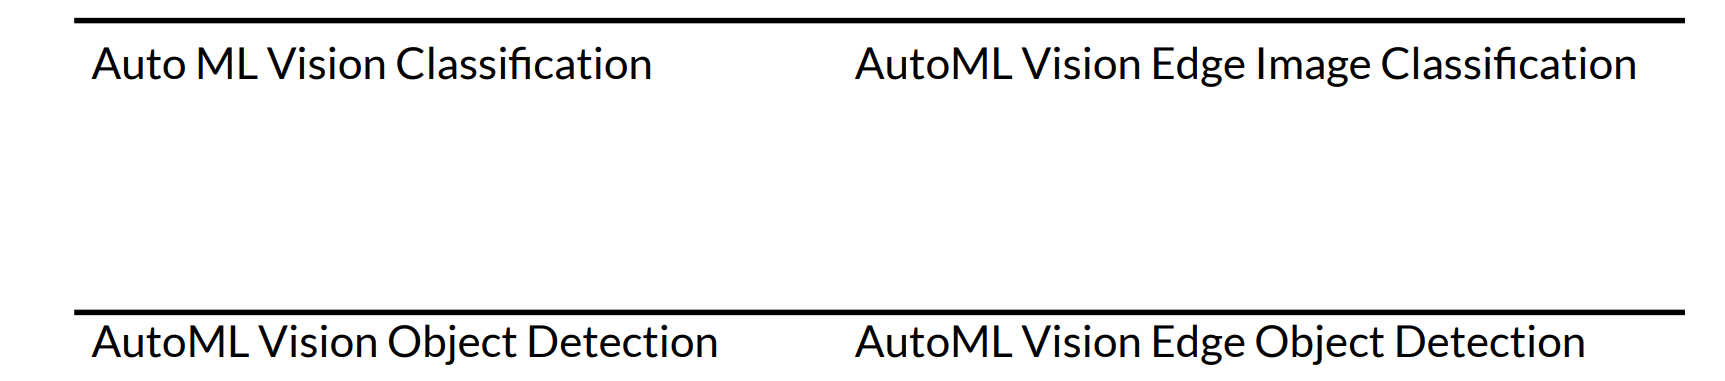

AutoML Video Intelligence Products


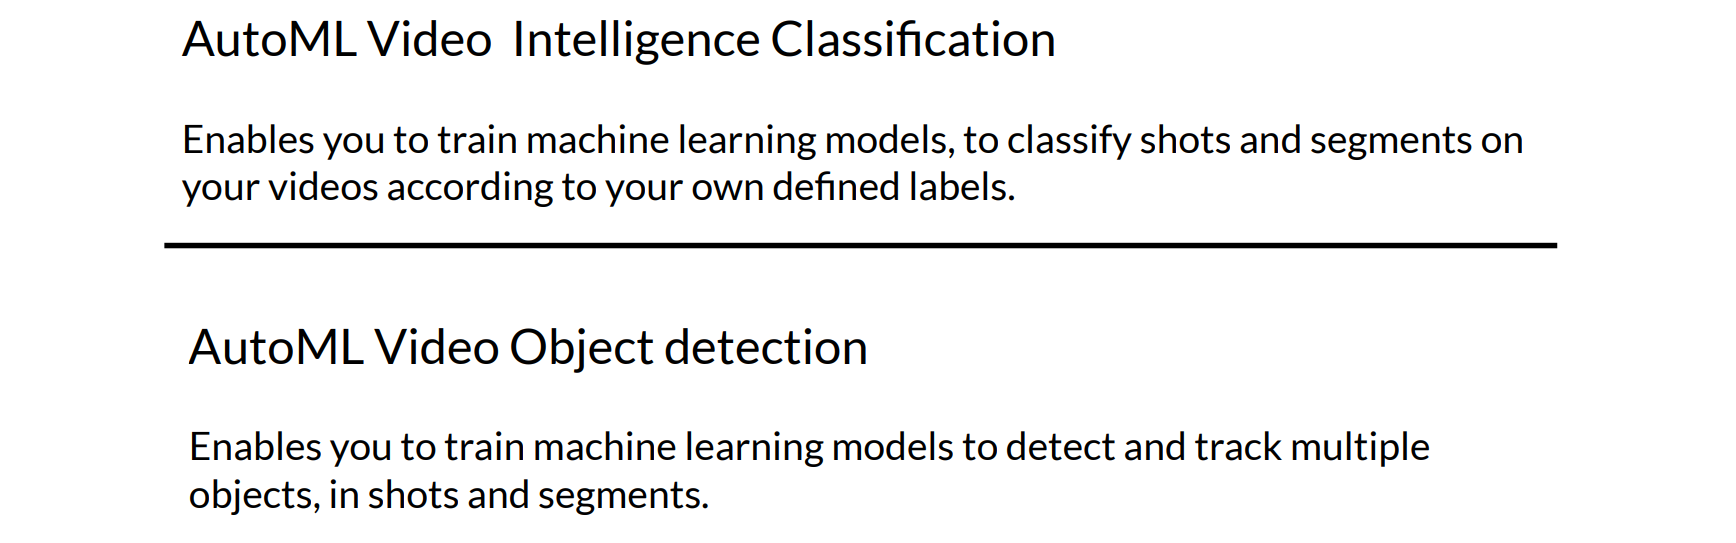

## 1.3 Model Resource Management Techniques

### 1.3.1 Dimensionality Effect on Performance


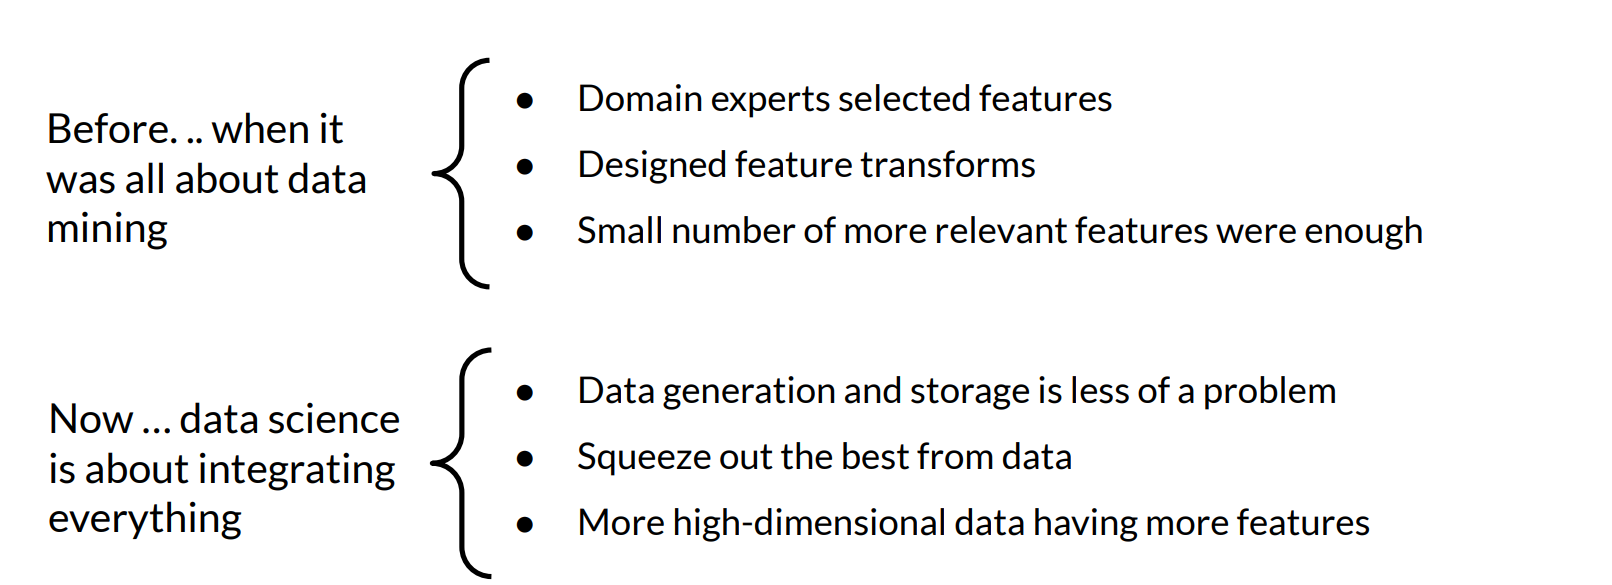

### 1.3.2 Curse of Dimensionality


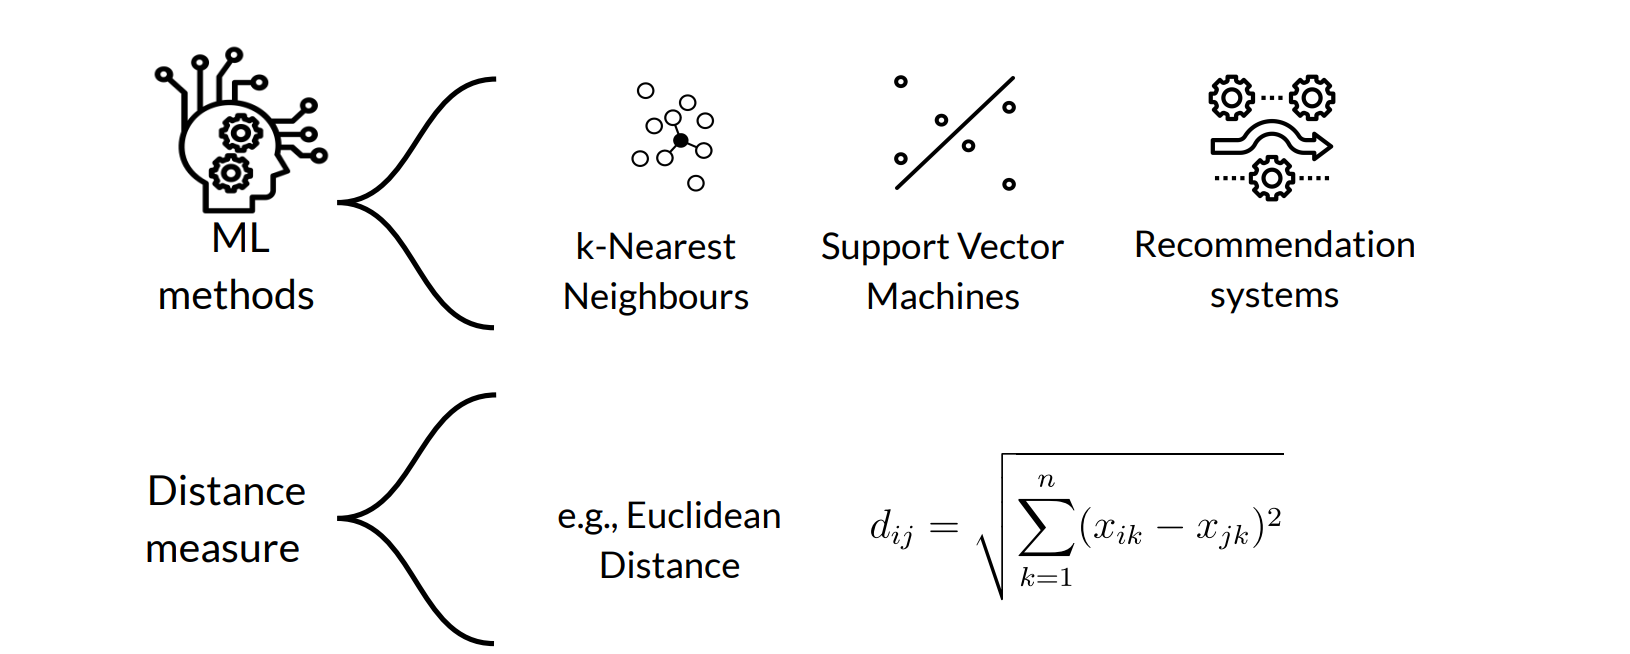

Why is high-dimensional data a problem?
- More dimensions → more features
- Risk of overfitting our models
- Distances grow more and more alike
- No clear distinction between clustered objects
- Concentration phenomenon for Euclidean distance

The performance of algorithms ~ the number of dimensions


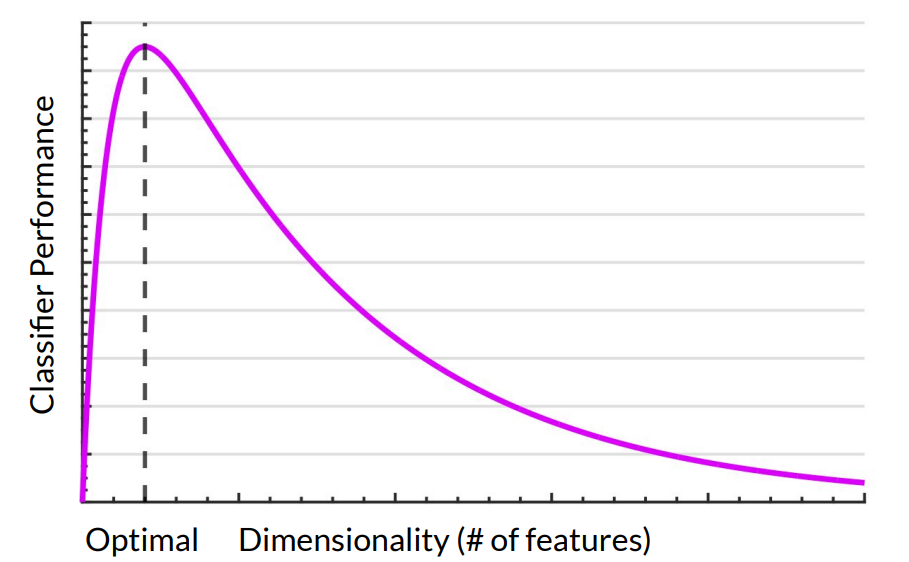

The Hughes effect
- The more the features, the larger the hypothesis space


The lower the hypothesis space
- the easier it is to find the correct hypothesis
- the less examples you need


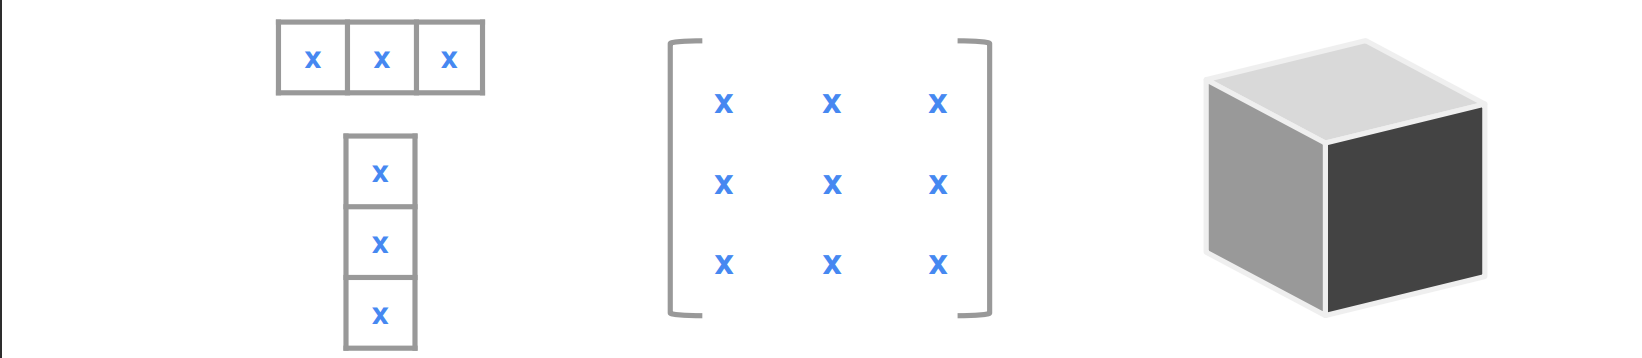

### 1.3.3 Manual Dimensionality Reduction

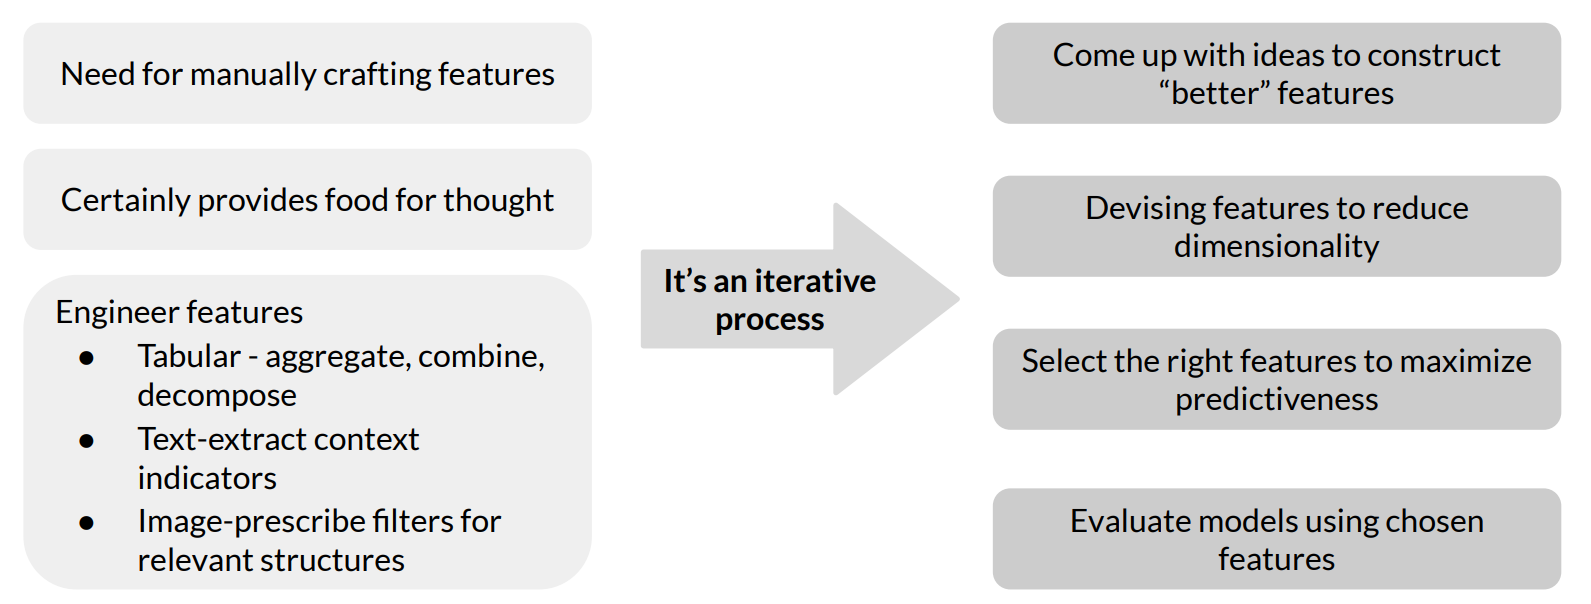

### 1.3.4 Algorithmic Dimensionality Reduction

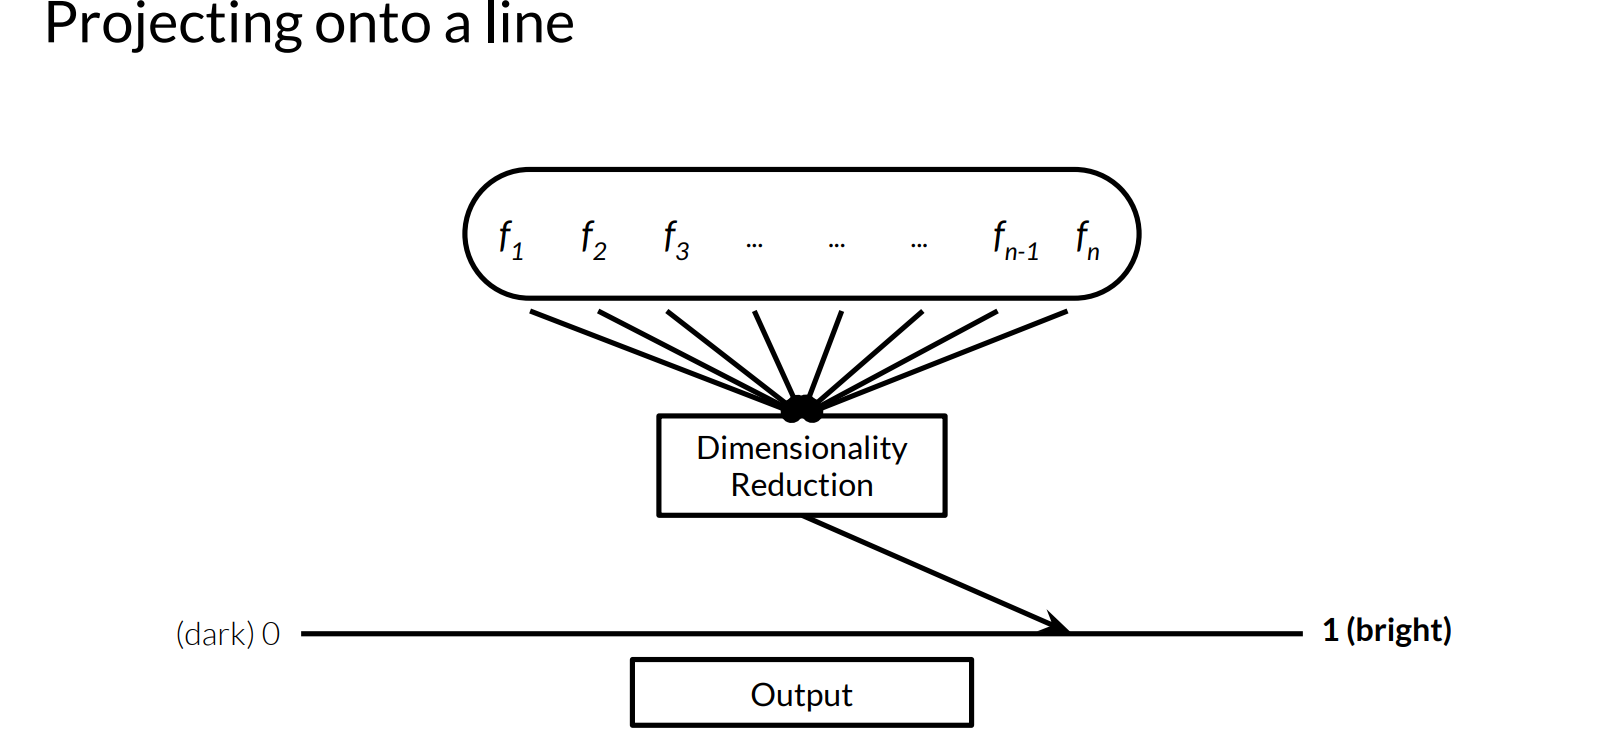


#### Best k-dimensional subspace for projection

> Classification: maximize separation among classes
> Example: Linear discriminant analysis (LDA)

> Regression: maximize correlation between projected data and response variable
> Example: Partial least squares (PLS)

> Unsupervised: retain as much data variance as possible
> Example: Principal component analysis (PCA)


### 1.3.5 Principal Component Analysis


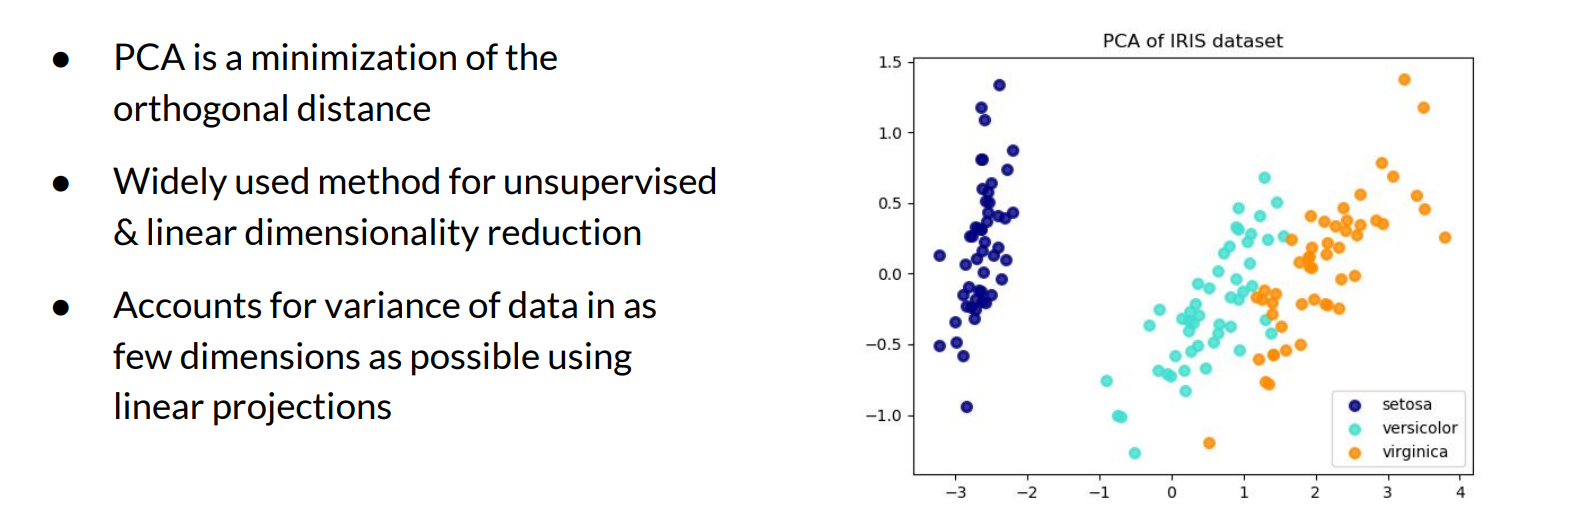

#### Principal components (PCs)


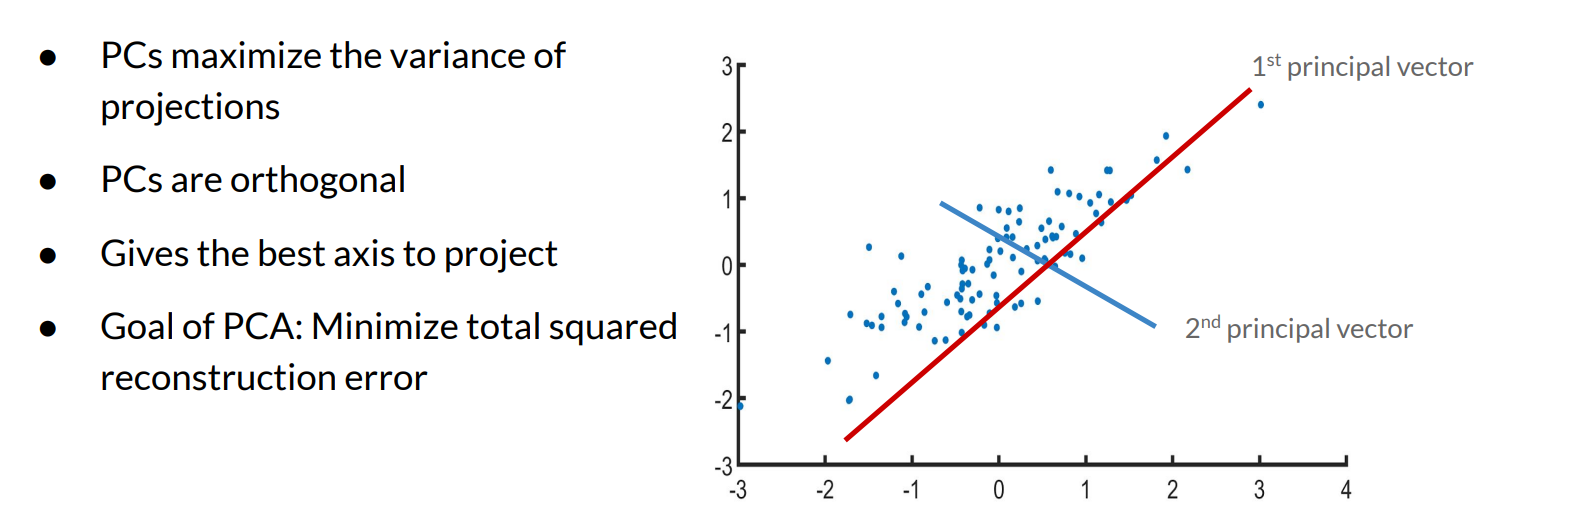

#### PCA Algorithm - First Principal Component

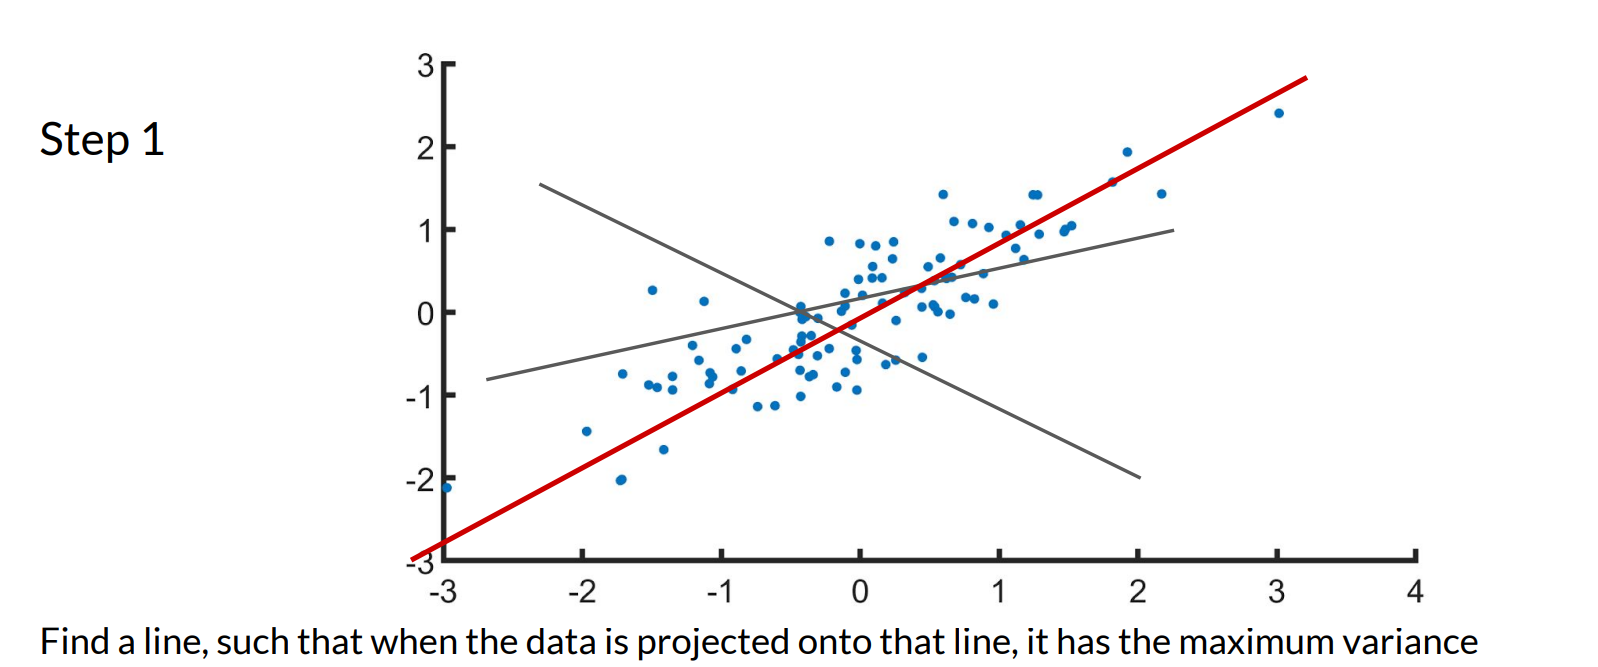

#### PCA Algorithm - Second Principal Component

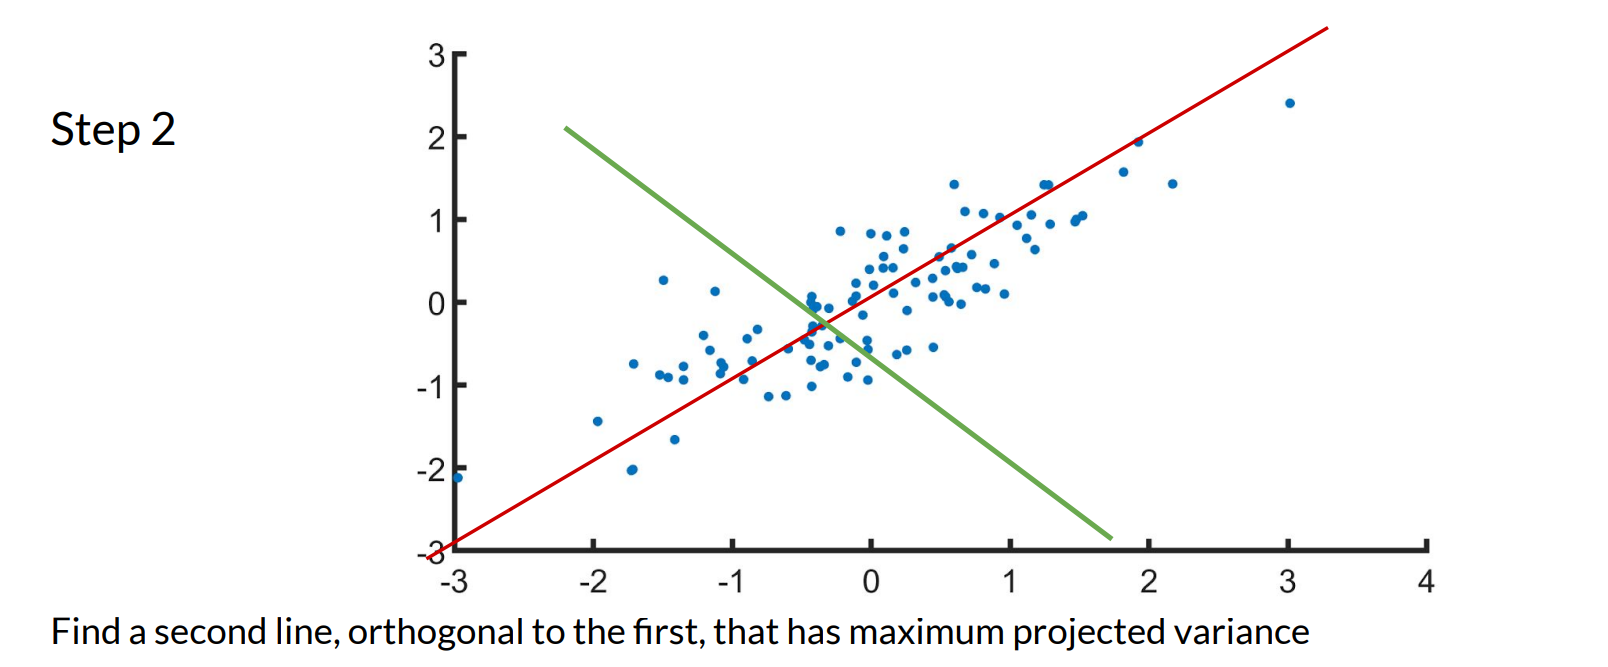

#### When to use PCA?

Strengths :
- A versatile technique
- Fast and simple
- Offers several variations and extensions (e.g., kernel/sparse PCA)

Weaknesses :
- Result is not interpretable
- Requires setting threshold for cumulative explained variance


### 1.3.6 Other Techniques

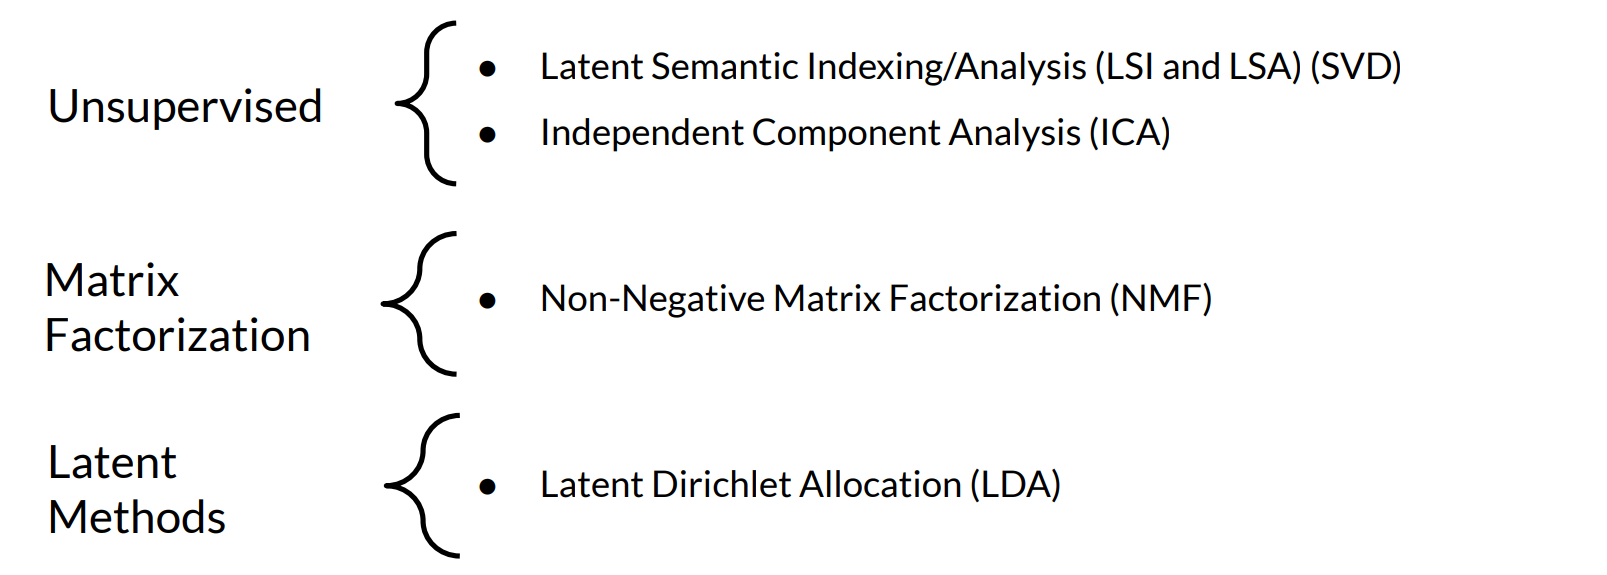

#### Singular value decomposition (SVD)

- SVD decomposes non-square matrices
- Useful for sparse matrices as produced by TF-IDF
- Removes redundant features from the dataset

#### Independent Components Analysis (ICA)

- PCA seeks directions in feature space that minimize reconstruction error
- ICA seeks directions that are most statistically independent
- ICA addresses higher order dependence


**How does ICA work?**
Assume there exists independent signals: <br>
$$S = [S_1(t), S_2(t), S_3(t)......., S_N(t)]$$
- Linear combinations of signals: $$Y(t) = AS(t)$$
  - Both A and S are unknown
  - A - mixing matrix
- Goal of ICA: recover original signals, $S(t)$ from $Y(t)$


Comparing PCA and ICA

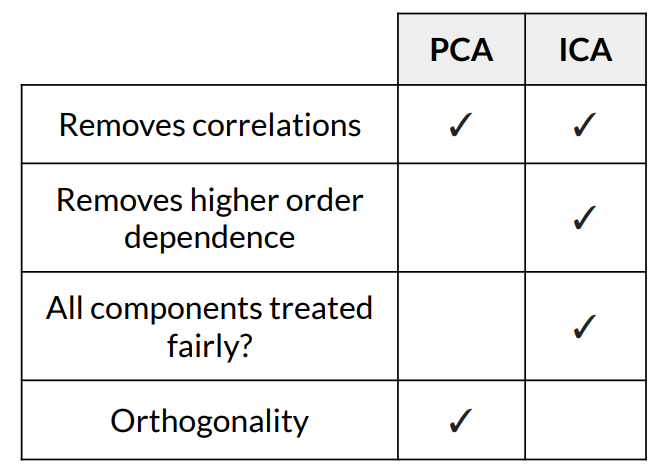

#### Non-negative Matrix Factorization (NMF)


- NMF models are interpretable and easier to understand
- NMF requires the sample features to be non-negative


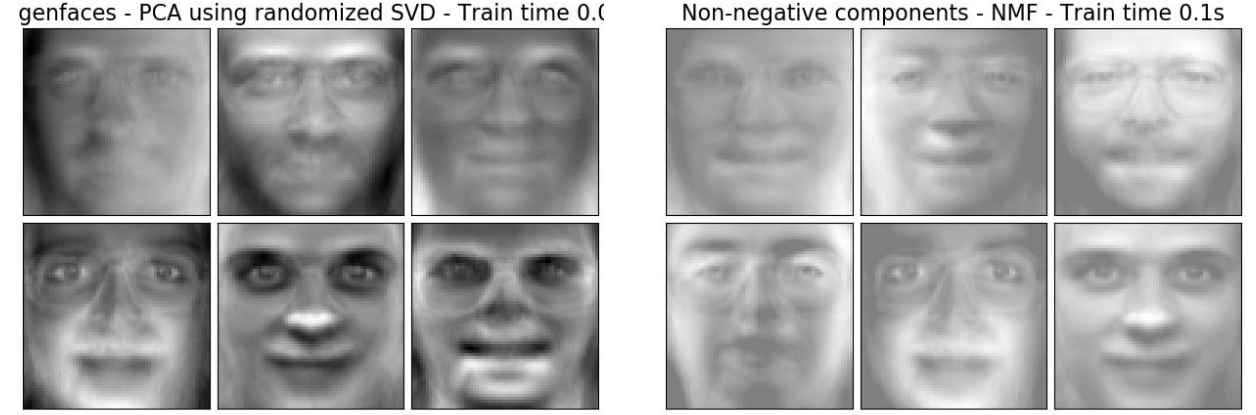

### 1.3.7 Manual Feature Engineering (Example)


First, install and import the necessary packages, set up paths to work on and download the dataset.

#### Imports

In [ ]:
# Import the packages

# Utilities
import os
import logging

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# For modelling
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models

# Set TF logger to only print errors (dismiss warnings)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

#### Load taxifare dataset

For this use a tweaked version of the [Taxi Fare dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data), which has been pre-processed and split beforehand.

First, create the directory where the data is going to be saved.



In [ ]:
if not os.path.isdir("/tmp/data"):
    os.makedirs("/tmp/data")

Now download the data in `csv` format from a cloud storage bucket.

In [ ]:
!gsutil cp gs://cloud-training-demos/feat_eng/data/taxi*.csv /tmp/data

Copying gs://cloud-training-demos/feat_eng/data/taxi-test.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-train.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-valid.csv...
- [3 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 3 objects/5.3 MiB.                                      


Check that the files were copied correctly and look like expected.

In [ ]:
!ls -l /tmp/data/*.csv

-rw-r--r-- 1 root root 1113292 Mar 25 14:59 /tmp/data/taxi-test.csv
-rw-r--r-- 1 root root 3551735 Mar 25 14:59 /tmp/data/taxi-train.csv
-rw-r--r-- 1 root root  888648 Mar 25 14:59 /tmp/data/taxi-valid.csv


Everything looks fine. Notice that there are three files, one for each split of `training`, `testing` and `validation`.



#### Inspect tha data

Now take a look at the training data.

In [ ]:
pd.read_csv('/tmp/data/taxi-train.csv').head()

fare_amount  passenger_count  pickup_longitude  pickup_latitude  \
0          8.1                1        -73.973731        40.791910   
1          4.5                2        -73.986495        40.739278   
2          2.9                1        -73.956043        40.772026   
3          7.0                1        -74.006557        40.705797   
4          6.5                1        -73.986443        40.741612   

   dropoff_longitude  dropoff_latitude  hourofday  dayofweek  
0         -73.962737         40.767318         14          4  
1         -73.986083         40.730933         10          6  
2         -73.956245         40.773934         22          3  
3         -73.980017         40.713617          6          3  
4         -73.990215         40.746467         10          2

The data contains a total of 8 variables.

The `fare_amount` is the target, the continuous value we’ll train a model to predict. This leaves with 7 features.



#### Create an input pipeline



To load the data for the model use an experimental feature of Tensorflow that lets loading directly from a `csv` file.

For this define some lists containing relevant information of the dataset such as the type of the columns.

In [ ]:
# Specify which column is the target
LABEL_COLUMN = 'fare_amount'

# Specify numerical columns
# Note you should create another list with STRING_COLS if you
# had text data but in this case all features are numerical
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude',
                'passenger_count', 'hourofday', 'dayofweek']


# A function to separate features and labels
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label


# A utility method to create a tf.data dataset from a CSV file
def load_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size)

    dataset = dataset.map(features_and_labels)  # features, label
    if mode == 'train':
        # Notice the repeat method is used so this dataset will loop infinitely
        dataset = dataset.shuffle(1000).repeat()
        # take advantage of multi-threading; 1=AUTOTUNE
        dataset = dataset.prefetch(1)
    return dataset

#### Create a DNN Model in Keras


Now build a simple Neural Network with the numerical features as input represented by a [`DenseFeatures`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DenseFeatures) layer (which produces a dense Tensor based on the given features), two dense layers with ReLU activation functions and an output layer with a linear activation function (since this is a regression problem).

Since the model is defined using `feature columns` the first layer might look different to what you are used to. This is done by declaring two dictionaries, one for the inputs (defined as Input layers) and one for the features (defined as feature columns).

Then computing the `DenseFeatures` tensor by passing in the feature columns to the constructor of the `DenseFeatures` layer and passing in the inputs to the resulting tensor (this is easier to understand with code):

In [ ]:
def build_dnn_model():
    # input layer
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # feature_columns
    feature_columns = {
        colname: fc.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Input layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[
                      tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                      'mse'
                  ])

    return model

Build DNN model and inspect the model architecture.

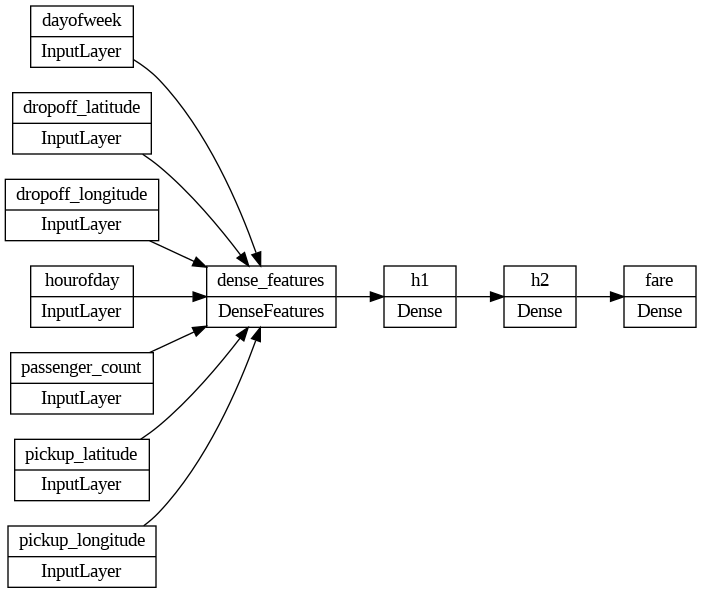

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

With the model architecture defined it is time to train it!

#### Train the model



Train the model for 20 epochs using a batch size of 32.

In [ ]:
NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-train.csv'))
NUM_EVAL_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-valid.csv'))

print(f"training split has {NUM_TRAIN_EXAMPLES} examples\n")
print(f"evaluation split has {NUM_EVAL_EXAMPLES} examples\n")

training split has 59620 examples

evaluation split has 14905 examples



Use the previously defined function to load the datasets from the original csv files.

In [ ]:
# Training dataset
trainds = load_dataset('/tmp/data/taxi-train*', TRAIN_BATCH_SIZE, 'train')

# Evaluation dataset
evalds = load_dataset('/tmp/data/taxi-valid*', 1000, 'eval').take(NUM_EVAL_EXAMPLES//1000)

# Needs to be specified since the dataset is infinite
# This happens because the repeat method was used when creating the dataset
steps_per_epoch = NUM_TRAIN_EXAMPLES // TRAIN_BATCH_SIZE

# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20
1863/1863 [==============================] - 7s 3ms/step - loss: 102.4024 - rmse: 10.1194 - mse: 102.4024 - val_loss: 99.9656 - val_rmse: 9.9983 - val_mse: 99.9656
Epoch 2/20
1863/1863 [==============================] - 7s 4ms/step - loss: 101.9912 - rmse: 10.0991 - mse: 101.9912 - val_loss: 100.4972 - val_rmse: 10.0248 - val_mse: 100.4972
Epoch 3/20
1863/1863 [==============================] - 7s 4ms/step - loss: 103.4810 - rmse: 10.1726 - mse: 103.4810 - val_loss: 101.3433 - val_rmse: 10.0669 - val_mse: 101.3433
Epoch 4/20
1863/1863 [==============================] - 6s 3ms/step - loss: 102.7876 - rmse: 10.1384 - mse: 102.7876 - val_loss: 99.9027 - val_rmse: 9.9951 - val_mse: 99.9027
Epoch 5/20
1863/1863 [==============================] - 5s 3ms/step - loss: 104.0506 - rmse: 10.2005 - mse: 104.0506 - val_loss: 99.3429 - val_rmse: 9.9671 - val_mse: 99.3429
Epoch 6/20
1863/1863 [==============================] - 9s 5ms/step - loss: 101.8437 - rmse: 10.0918 - mse: 101.8437 - 

#### Visualize training curves



Now visualize the training history of the model with the raw features:

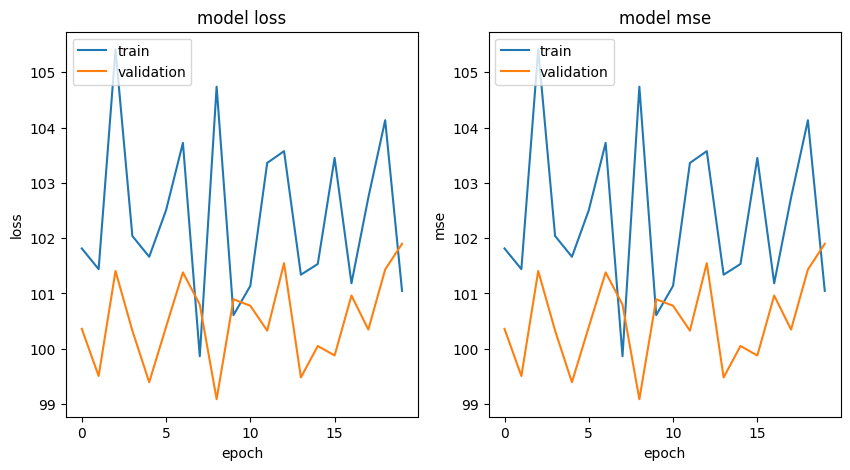

In [ ]:
# Function for plotting metrics for a given history
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history[f'val_{key}'])
        plt.title(f'model {key}')
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')


# Plot history metrics
plot_curves(history, ['loss', 'mse'])

The training history doesn't look very promising showing an erratic behaviour. Looks like the training process struggled to transverse the high dimensional space that the current features create.

Nevertheless let's use it for prediction.

Notice that the latitude and longitude values should revolve around (`37`, `45`) and (`-70`, `-78`) respectively since these are the range of coordinates for New York city.

In [ ]:
# Define a taxi ride (a data point)
taxi_ride = {
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'hourofday': tf.convert_to_tensor([3.0]),
    'dayofweek': tf.convert_to_tensor([3.0]),
}

# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")

1/1 [==============================] - 0s 170ms/step
the model predicted a fare total of 12.17 USD for the ride.


<ipython-input-12-502b0264e2fb>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")


The model predicted this particular ride to be around 12 USD. However you know the model performance is not the best as it was showcased by the training history. Let's improve it by using **Feature Engineering**.

#### Improve Model Performance Using Feature Engineering

Going forward you will only use geo-spatial features as these are the most relevant when calculating the fare since this value is mostly dependant on the distance transversed:

In [ ]:
# Drop dayofweek and hourofday features
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

Since you are dealing exclusively with geospatial data you will create some transformations that are aware of this geospatial nature. This help the model make a better representation of the problem at hand.

For instance the model cannot magically understand what a coordinate is supposed to represent and since the data is taken from New York only, the latitude and longitude revolve around (`37`, `45`) and (`-70`, `-78`) respectively, which is arbitrary for the model. A good first step is to scale these values.

**Notice all transformations are created by defining functions**.

In [ ]:
def scale_longitude(lon_column):
    return (lon_column + 78)/8.

In [ ]:
def scale_latitude(lat_column):
    return (lat_column - 37)/8.

Another important fact is that the fare of a taxi ride is proportional to the distance of the ride. But as the features currently are, there is no way for the model to infer that the pair of (`pickup_latitude`, `pickup_longitude`) represent the point where the passenger started the ride and the pair (`dropoff_latitude`, `dropoff_longitude`) represent the point where the ride ended. More importantly, the model is not aware that the distance between these two points is crucial for predicting the fare.

To solve this, a new feature (which is a transformation of the other ones) that provides this information is required.

In [ ]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

#### Applying transformations

Now you will define the `transform` function which will apply the previously defined transformation functions. To apply the actual transformations you will be using `Lambda` layers apply a function to values (in this case the inputs).


In [ ]:
def transform(inputs, numeric_cols):

    # Make a copy of the inputs to apply the transformations to
    transformed = inputs.copy()

    # Define feature columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in numeric_cols
    }

    # Scaling longitude from range [-70, -78] to [0, 1]
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:
        transformed[lon_col] = layers.Lambda(
            scale_longitude,
            name=f"scale_{lon_col}")(inputs[lon_col])

    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ['pickup_latitude', 'dropoff_latitude']:
        transformed[lat_col] = layers.Lambda(
            scale_latitude,
            name=f'scale_{lat_col}')(inputs[lat_col])

    # add Euclidean distance
    transformed['euclidean'] = layers.Lambda(
        euclidean,
        name='euclidean')([inputs['pickup_longitude'],
                           inputs['pickup_latitude'],
                           inputs['dropoff_longitude'],
                           inputs['dropoff_latitude']])


    # Add euclidean distance to feature columns
    feature_columns['euclidean'] = fc.numeric_column('euclidean')

    return transformed, feature_columns

#### Update the model



Next, create the DNN model now with the engineered (transformed) features.

In [ ]:
def build_dnn_model():

    # input layer (notice type of float32 since features are numeric)
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # transformed features
    transformed, feature_columns = transform(inputs, numeric_cols=NUMERIC_COLS)

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Lambda layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # Compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse'])

    return model

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

See how the model architecture has changed.

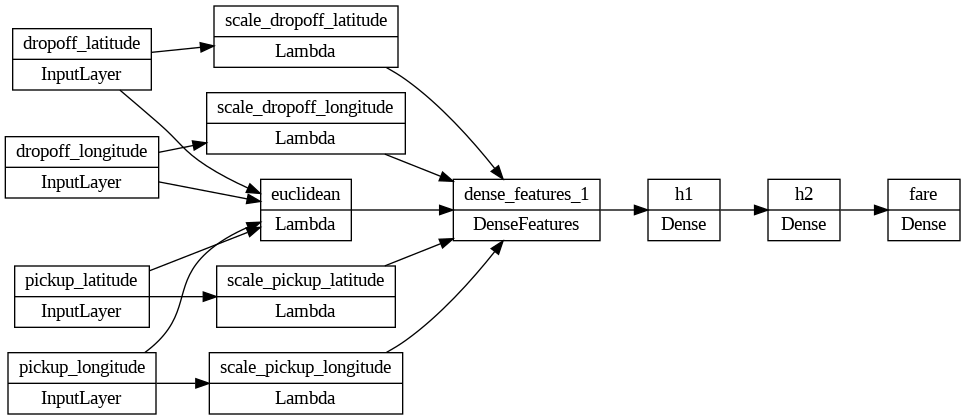

In [ ]:
# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model_engineered.png', show_shapes=False, rankdir='LR')

This plot is very useful for understanding the relationships and dependencies between the original and the transformed features!

**Notice that the input of the model now consists of 5 features instead of the original 7, thus reducing the dimensionality of the problem.**

Let's now train the model that includes feature engineering.

In [ ]:
# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['passenger_count', 'hourofday', 'dayofweek'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1863/1863 [==============================] - 7s 3ms/step - loss: 97.5370 - rmse: 9.8761 - mse: 97.5370 - val_loss: 63.1470 - val_rmse: 7.9465 - val_mse: 63.1470
Epoch 2/20
1863/1863 [==============================] - 4s 2ms/step - loss: 46.5340 - rmse: 6.8216 - mse: 46.5340 - val_loss: 33.0713 - val_rmse: 5.7508 - val_mse: 33.0713
Epoch 3/20
1863/1863 [==============================] - 6s 3ms/step - loss: 32.8720 - rmse: 5.7334 - mse: 32.8720 - val_loss: 30.4080 - val_rmse: 5.5143 - val_mse: 30.4080
Epoch 4/20
1863/1863 [==============================] - 4s 2ms/step - loss: 31.3445 - rmse: 5.5986 - mse: 31.3445 - val_loss: 28.4970 - val_rmse: 5.3383 - val_mse: 28.4970
Epoch 5/20
1863/1863 [==============================] - 6s 3ms/step - loss: 27.5609 - rmse: 5.2499 - mse: 27.5609 - val_loss: 27.1544 - val_rmse: 5.2110 - val_mse: 27.1544
Epoch 6/20
1863/1863 [==============================] - 5s 3ms/step - loss: 28.8096 - rmse: 5.3675 - mse: 28.8096 - val_loss: 26.3641 - val_rmse: 5.134

Notice that the features `passenger_count`, `hourofday` and `dayofweek` were excluded since they were omitted when defining the input pipeline.

Now lets visualize the training history of the model with the engineered features.

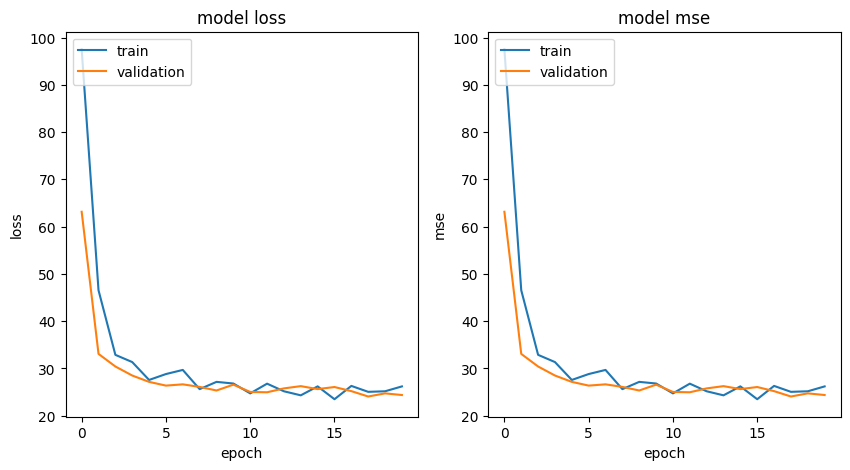

In [ ]:
# Plot history metrics
plot_curves(history, ['loss', 'mse'])

This looks a lot better than the previous training history! Now the loss and error metrics are decreasing with each epoch and both curves (train and validation) are very close to each other. Nice job!

Let's do a prediction with this new model on the example we previously used.

In [ ]:
# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")

1/1 [==============================] - 0s 136ms/step
the model predicted a fare total of 7.20 USD for the ride.


<ipython-input-23-8d72dfbe712e>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")


### 1.3.8 Algorithmic Dimensionality Reduction



In [ ]:
# General use imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Principal Components Analysis - PCA

This dataset has been used extensively to showcase PCA so here going to use the [HTRU_2](https://archive.ics.uci.edu/ml/datasets/HTRU2) dataset which describes several celestial objects and the idea is to be able to classify if an object is a pulsar star or not.

Begin by downloading the dataset:


In [ ]:
# Download zip file
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip

# Unzip it
!unzip HTRU2.zip

--2024-03-25 15:12:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HTRU2.zip’

HTRU2.zip               [  <=>               ]   1.49M  3.99MB/s    in 0.4s    

2024-03-25 15:12:48 (3.99 MB/s) - ‘HTRU2.zip’ saved [1563015]

Archive:  HTRU2.zip
  inflating: HTRU_2.csv              
  inflating: HTRU_2.arff             
  inflating: Readme.txt              


Load the data into a dataframe for easier inspection:

In [ ]:
# Load data into a pandas dataframe
data = pd.read_csv("HTRU_2.csv", names=['mean_ip', 'sd_ip', 'ec_ip',
                                        'sw_ip', 'mean_dm', 'sd_dm',
                                        'ec_dm', 'sw_dm', 'pulsar'])

# Take a look at the data
data.head()

mean_ip      sd_ip     ec_ip     sw_ip   mean_dm      sd_dm      ec_dm  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   

        sw_dm  pulsar  
0   74.242225       0  
1  127.393580       0  
2   63.171909       0  
3   53.593661       0  
4  252.567306       0

This dataset has 8 numerical features (the "pulsar" column is the label). Now you are going to perform PCA reduce this 8th-dimensional input space to a lower dimensional one.

But first, scale the data. If you do an exploratory analysis of the data you will see that this dataset has a lot of outliers. Because of this you are going to use a [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), which scales features using statistics that are robust to outliers.

In [ ]:
from sklearn.preprocessing import RobustScaler

# Split features from labels
features = data[[col for col in data.columns if col != "pulsar"]]
labels = data["pulsar"]

# Scale data
robust_data = RobustScaler().fit_transform(features)

Now perform PCA using sklearn. In this first iteration you are going to create a principal component for each one of the features so there is no dimensionality reduction:

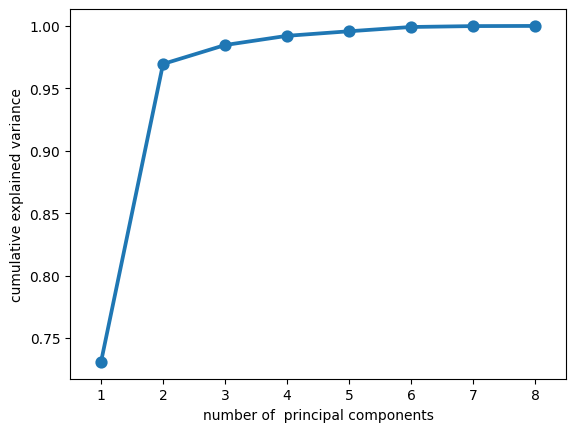

In [ ]:
from sklearn.decomposition import PCA

# Instantiate PCA without specifying number of components
pca_all = PCA()

# Fit to scaled data
pca_all.fit(robust_data)

# Save cumulative explained variance
cum_var = (np.cumsum(pca_all.explained_variance_ratio_))
n_comp = [i for i in range(1, pca_all.n_components_ + 1)]

# Plot cumulative variance
ax = sns.pointplot(x=n_comp, y=cum_var)
ax.set(xlabel='number of  principal components', ylabel='cumulative explained variance')
plt.show()

With just 3 components almost all of the variance of the original data is explained! This makes to think that there were some highly correlated features in the original data.

Plot the first 3 principal components:

<ipython-input-6-150ff416b033>:24: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
<ipython-input-6-150ff416b033>:26: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
<ipython-input-6-150ff416b033>:28: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])


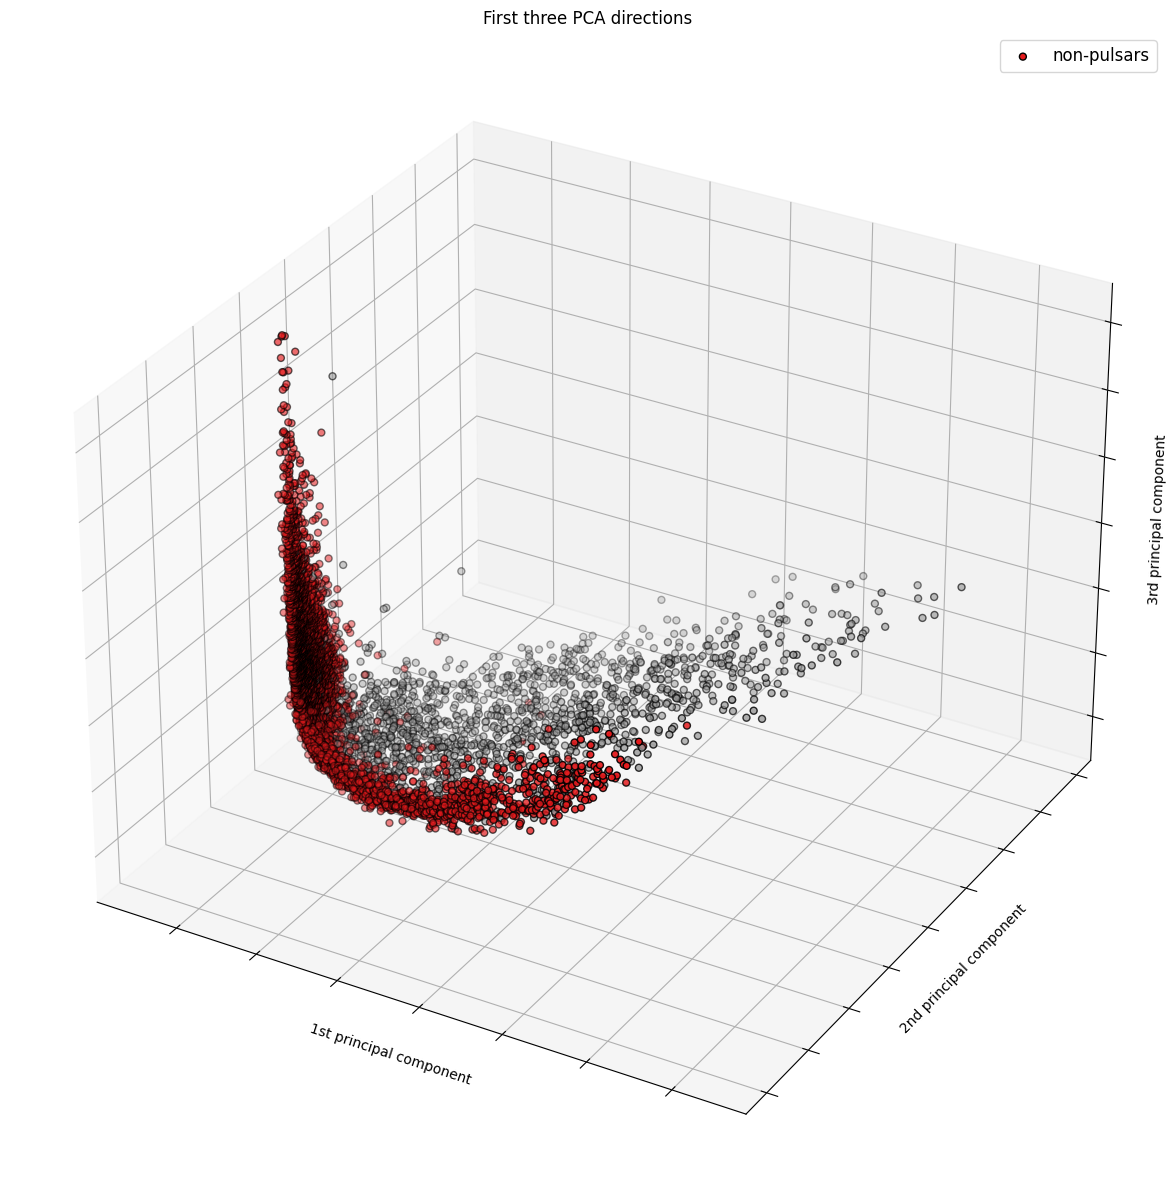

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Instantiate PCA with 3 components
pca_3 = PCA(3)

# Fit to scaled data
pca_3.fit(robust_data)

# Transform scaled data
data_3pc = pca_3.transform(robust_data)

# Render the 3D plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data_3pc[:, 0], data_3pc[:, 1], data_3pc[:, 2], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=25, label=data['pulsar'])

ax.legend(["non-pulsars"], fontsize="large")

ax.set_title("First three PCA directions")
ax.set_xlabel("1st principal component")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd principal component")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd principal component")
ax.w_zaxis.set_ticklabels([])

plt.show()

It is possible to visualize a plane that would be able to separate both classes since non-pulsars tend to group on the edge of this surface while pulsars are mostly located on the inner side of the surface.

In this case it is reasonable to think that the dimension can be reduced even more since with 2 principal components more than 95% of the variance of the original data is explained. Now let's plot just the first two principal components:

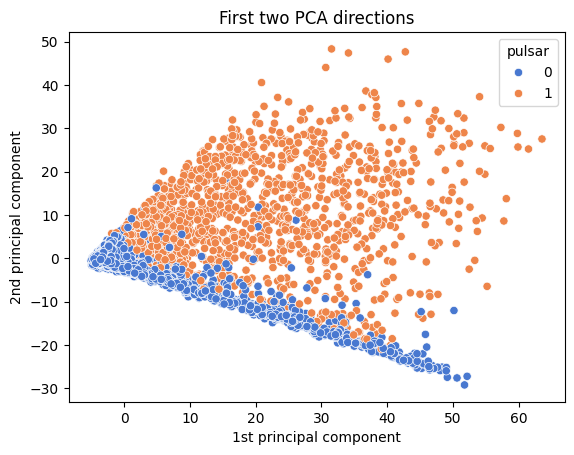

In [ ]:
# Instantiate PCA with 2 components
pca_2 = PCA(2)

# Fit and transform scaled data
pca_2.fit(robust_data)
data_2pc = pca_2.transform(robust_data)

# Render the 2D plot
ax = sns.scatterplot(x=data_2pc[:,0],
                     y=data_2pc[:,1],
                     hue=labels,
                     palette=sns.color_palette("muted", n_colors=2))

ax.set(xlabel='1st principal component', ylabel='2nd principal component', title='First two PCA directions')
plt.show()

Even in 2D the 2 classes look linearly separable (not perfectly, of course) but this is quite remarkable considering that the initial space was 8th dimensional.

Using PCA successfully reduced the dimensionality from 8 to 2 while maintaining a lot of the variance of the original data!


#### Singular Value Decomposition - SVD

SVD is one way to decompose matrices. Remember that matrices can be seen as linear transformations in space. PCA relies on eigendecomposition, which can only be done for square matrices. You might wonder why the first example worked with PCA if the data had far more observations than features. The reason is that when performing PCA you end up using the matrix product $X^{t}X$ which is a square matrix.

However always do not have square matrices, and sometimes can have really sparse matrices.

To decompose these types of matrices, which can’t be decomposed with eigendecomposition, can use techniques such as Singular Value Decomposition. SVD decomposes the original dataset into its constituents, resulting in a reduction of dimensionality. It is used to remove redundant features from the dataset.

To check SVD , going to use the [digits dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html), which is made up of 1797 8x8 images of handwritten digits:




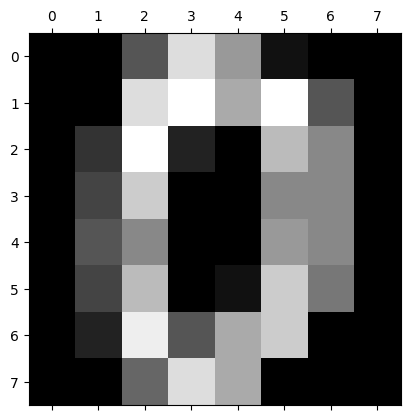

In [ ]:
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Plot first digit
image = digits.data[0].reshape((8, 8))
plt.matshow(image, cmap = 'gray')
plt.show()

Continue by normalizing the data and checking its dimensions:

In [ ]:
# Save data into X variable
X = digits.data

# Normalize pixel values
X = X/255

# Print shapes of dataset and data points
print(f"Digits data has shape {X.shape}\n")
print(f"Each data point has shape {X[0].shape}\n")

Digits data has shape (1797, 64)

Each data point has shape (64,)



Plot the first digit to check how normalization affects the images:

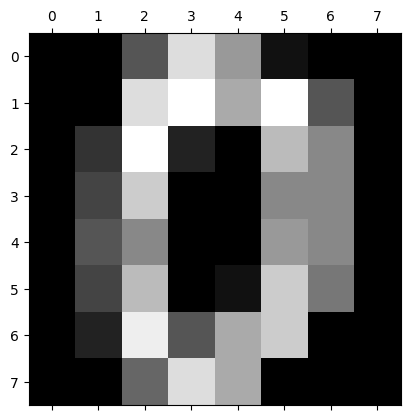

In [ ]:
image = X[0].reshape((8, 8))
plt.matshow(image, cmap = 'gray')
plt.show()

The image should be identical to the one without normalization. This is because the relative brightness of each pixel with the others is maintained. Normalization is done as a preprocessing step when feeding the data into a Neural Network. Here it is done since it is a step that is usually always done when working with image data.

Now perform SVD on the data and plot the cumulative amount of explained variance for every number of components. Note that the [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) needs a number of components strictly lower to the number of features.

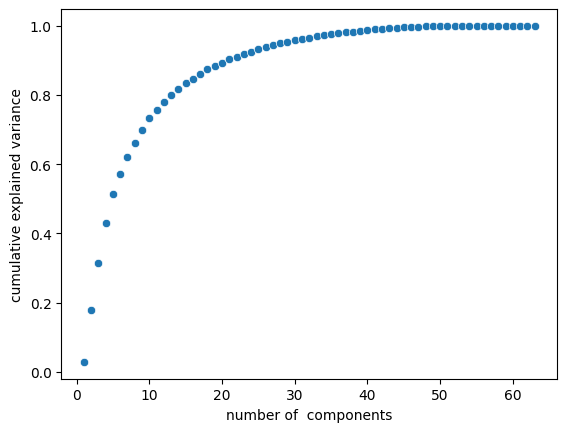

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Instantiate Truncated SVD with (original dimension - 1) components
org_dim = X.shape[1]
tsvd = TruncatedSVD(org_dim - 1)
tsvd.fit(X)

# Save cumulative explained variance
cum_var = (np.cumsum(tsvd.explained_variance_ratio_))
n_comp = [i for i in range(1, org_dim)]

# Plot cumulative variance
ax = sns.scatterplot(x=n_comp, y=cum_var)
ax.set(xlabel='number of  components', ylabel='cumulative explained variance')
plt.show()

Looking at the plot it can be seen that with only 5 components near the 50% of the variance of the original data is explained.

Let's double check this:

In [ ]:
print(f"Explained variance with 5 components: {float(cum_var[4:5])*100:.2f}%")

Explained variance with 5 components: 51.53%


<ipython-input-12-f80c579ea24b>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Explained variance with 5 components: {float(cum_var[4:5])*100:.2f}%")


It is not a lot but let's check what you get when performing SVD with only 5 components:

In [ ]:
# Instantiate a Truncated SVD with 5 components
tsvd = TruncatedSVD(n_components=5)

# Get the transformed data
X_tsvd = tsvd.fit_transform(X)

# Print shapes of dataset and data points
print(f"Original data points have shape {X[0].shape}\n")
print(f"Transformed data points have shape {X_tsvd[0].shape}\n")

Original data points have shape (64,)

Transformed data points have shape (5,)



By doing this representing each digit using 5 dimensions instead of the original 64

Now check how this looks like visually:

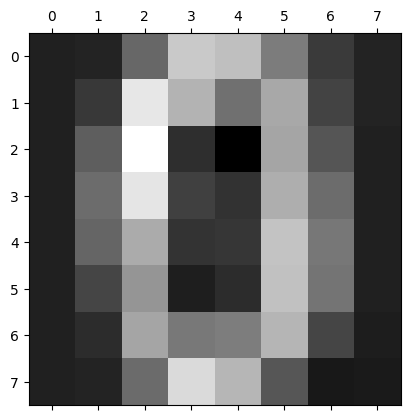

In [ ]:
image_reduced_5 = tsvd.inverse_transform(X_tsvd[0].reshape(1, -1))
image_reduced_5 = image_reduced_5.reshape((8, 8))
plt.matshow(image_reduced_5, cmap = 'gray')
plt.show()

It looks blurry but you can still tell this is a zero.


#### Using more components

Let’s try again, only, this time, we use half the number of features in the original data.

But first define a function that performs this process for any number of components:

In [ ]:
def image_given_components(n_components, verbose=True):
  tsvd = TruncatedSVD(n_components=n_components)
  X_tsvd = tsvd.fit_transform(X)
  if verbose:
    print(f"Explained variance with {n_components} components: {float(tsvd.explained_variance_ratio_.sum())*100:.2f}%\n")
  image = tsvd.inverse_transform(X_tsvd[0].reshape(1, -1))
  image = image.reshape((8, 8))
  return image


Use the function to generate the image that use 32 components:

Explained variance with 32 components: 96.63%



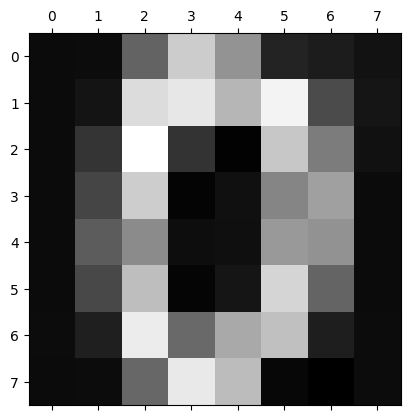

In [ ]:
image_reduced_32 = image_given_components(32)
plt.matshow(image_reduced_32, cmap = 'gray')
plt.show()

This image looks very similar to the original one (no wonder since more than 95% of the original variance is explained) but the dimensionality of the representations have been cut in half!

To better grasp how the images look like depending on the dimensionality of the representations, the next cell plots them side by side (the last figure has a parameter that you can tweak):

Explained variance with 1 components: 2.87%



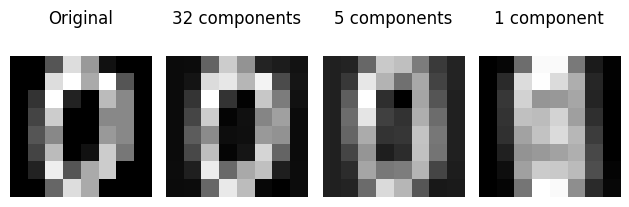

In [ ]:
fig = plt.figure()

# Original image
ax1 = fig.add_subplot(1,4,1)
ax1.matshow(image, cmap = 'gray')
ax1.title.set_text('Original')
ax1.axis('off')

# Using 32 components
ax2 = fig.add_subplot(1,4,2)
ax2.matshow(image_reduced_32, cmap = 'gray')
ax2.title.set_text('32 components')
ax2.axis('off')

# Using 5 components
ax3 = fig.add_subplot(1,4,3)
ax3.matshow(image_reduced_5, cmap = 'gray')
ax3.title.set_text('5 components')
ax3.axis('off')

# Using 1 components
ax4 = fig.add_subplot(1,4,4)
ax4.matshow(image_given_components(1), cmap = 'gray') # Change this parameter to see other representations
ax4.title.set_text('1 component')
ax4.axis('off')

plt.tight_layout()
plt.show()

#### Non-negative Matrix Factorization - NMF

NMF expresses samples as combinations of interpretable parts. For example, it represents documents as combinations of topics, and images in terms of commonly occurring visual patterns. NMF, like PCA, is a dimensionality reduction technique. In contrast to PCA, however, NMF models are interpretable. This means NMF models are easier to understand and much easier for us to explain to others. NMF can't be applied to every dataset, however. It requires the sample features be non-negative, so greater than or equal to 0.

To test NMF you will use the [20newsgroups dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) which comprises around 12000 newsgroups posts on 20 topics.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

# Download data
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

# Get the actual text data from the sklearn Bunch
data = data.get("data")

At this point you have the data in a list format. Let's check it out:

In [ ]:
print(f"Data has {len(data)} elements.\n")
print(f"First 2 elements: \n")
for n, d in enumerate(data[:2], start=1):
  print("======"*10)
  print(f"Element number {n}:\n\n{d}\n")

Data has 11314 elements.

First 2 elements: 

Element number 1:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Element number 2:

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the networ

Notice that you only have the actual text without information of the topic it belongs to (labels).

Now you need to represent the text as vectors, for this you will use a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) with `max_features` set to 500. This will be the original dimensionality of the data (which you will reduce via NMF).

In [ ]:
# Instantiate vectorizer setting dimensionality of data
# The stop_words param refer to words (in english) that don't add much value to the content of the document and must be ommited
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# Vectorize original data
vect_data = vectorizer.fit_transform(data)


# Print dimensionality
print(f"Data has shape {vect_data.shape} after vectorization.")
print(f"Each data point has shape {vect_data[0].shape} after vectorization.")

Data has shape (11314, 500) after vectorization.
Each data point has shape (1, 500) after vectorization.


Every one of the texts in the original data is represented as a 1x500 vector.

Now use NMF to reduce this dimensionality:

In [ ]:
# Desired number of components
n_comp = 5

# Instantiate NMF with the desired number of components
nmf = NMF(n_components=n_comp, random_state=42)

# Apply NMF to the vectorized data
nmf.fit(vect_data)

reduced_vect_data = nmf.transform(vect_data)

# Print dimensionality
print(f"Data has shape {reduced_vect_data.shape} after NMF.")
print(f"Each data point has shape {reduced_vect_data[0].shape} after NMF.")

# Save feature names for plotting
feature_names = vectorizer.get_feature_names_out()

Data has shape (11314, 5) after NMF.
Each data point has shape (5,) after NMF.


Now every data point is being represented by a vector of `n_comp` dimensions rather than the original 500!

In this case every component represents a topic and each data point is represented as a combination of those topics. The value for each topic can be interpreted as how strong the relationship between the text and that particular topic is.

Check this for the 1st element of the text data:

In [ ]:
print(f"Original text:\n{data[0]}\n")

print(f"Representation based on topics:\n{reduced_vect_data[0]}")

Original text:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Representation based on topics:
[0.00554834 0.         0.         0.05431621 0.04026962]


Looks like this text can be expressed as a combination of the first, fourth and fifth topic. Specially the later two.

At this point you might wonder what these topics are. Since we didn't provide labels, these topics arised from the data. To have a sense of what these topics are, plot the top 20 words for each topic:

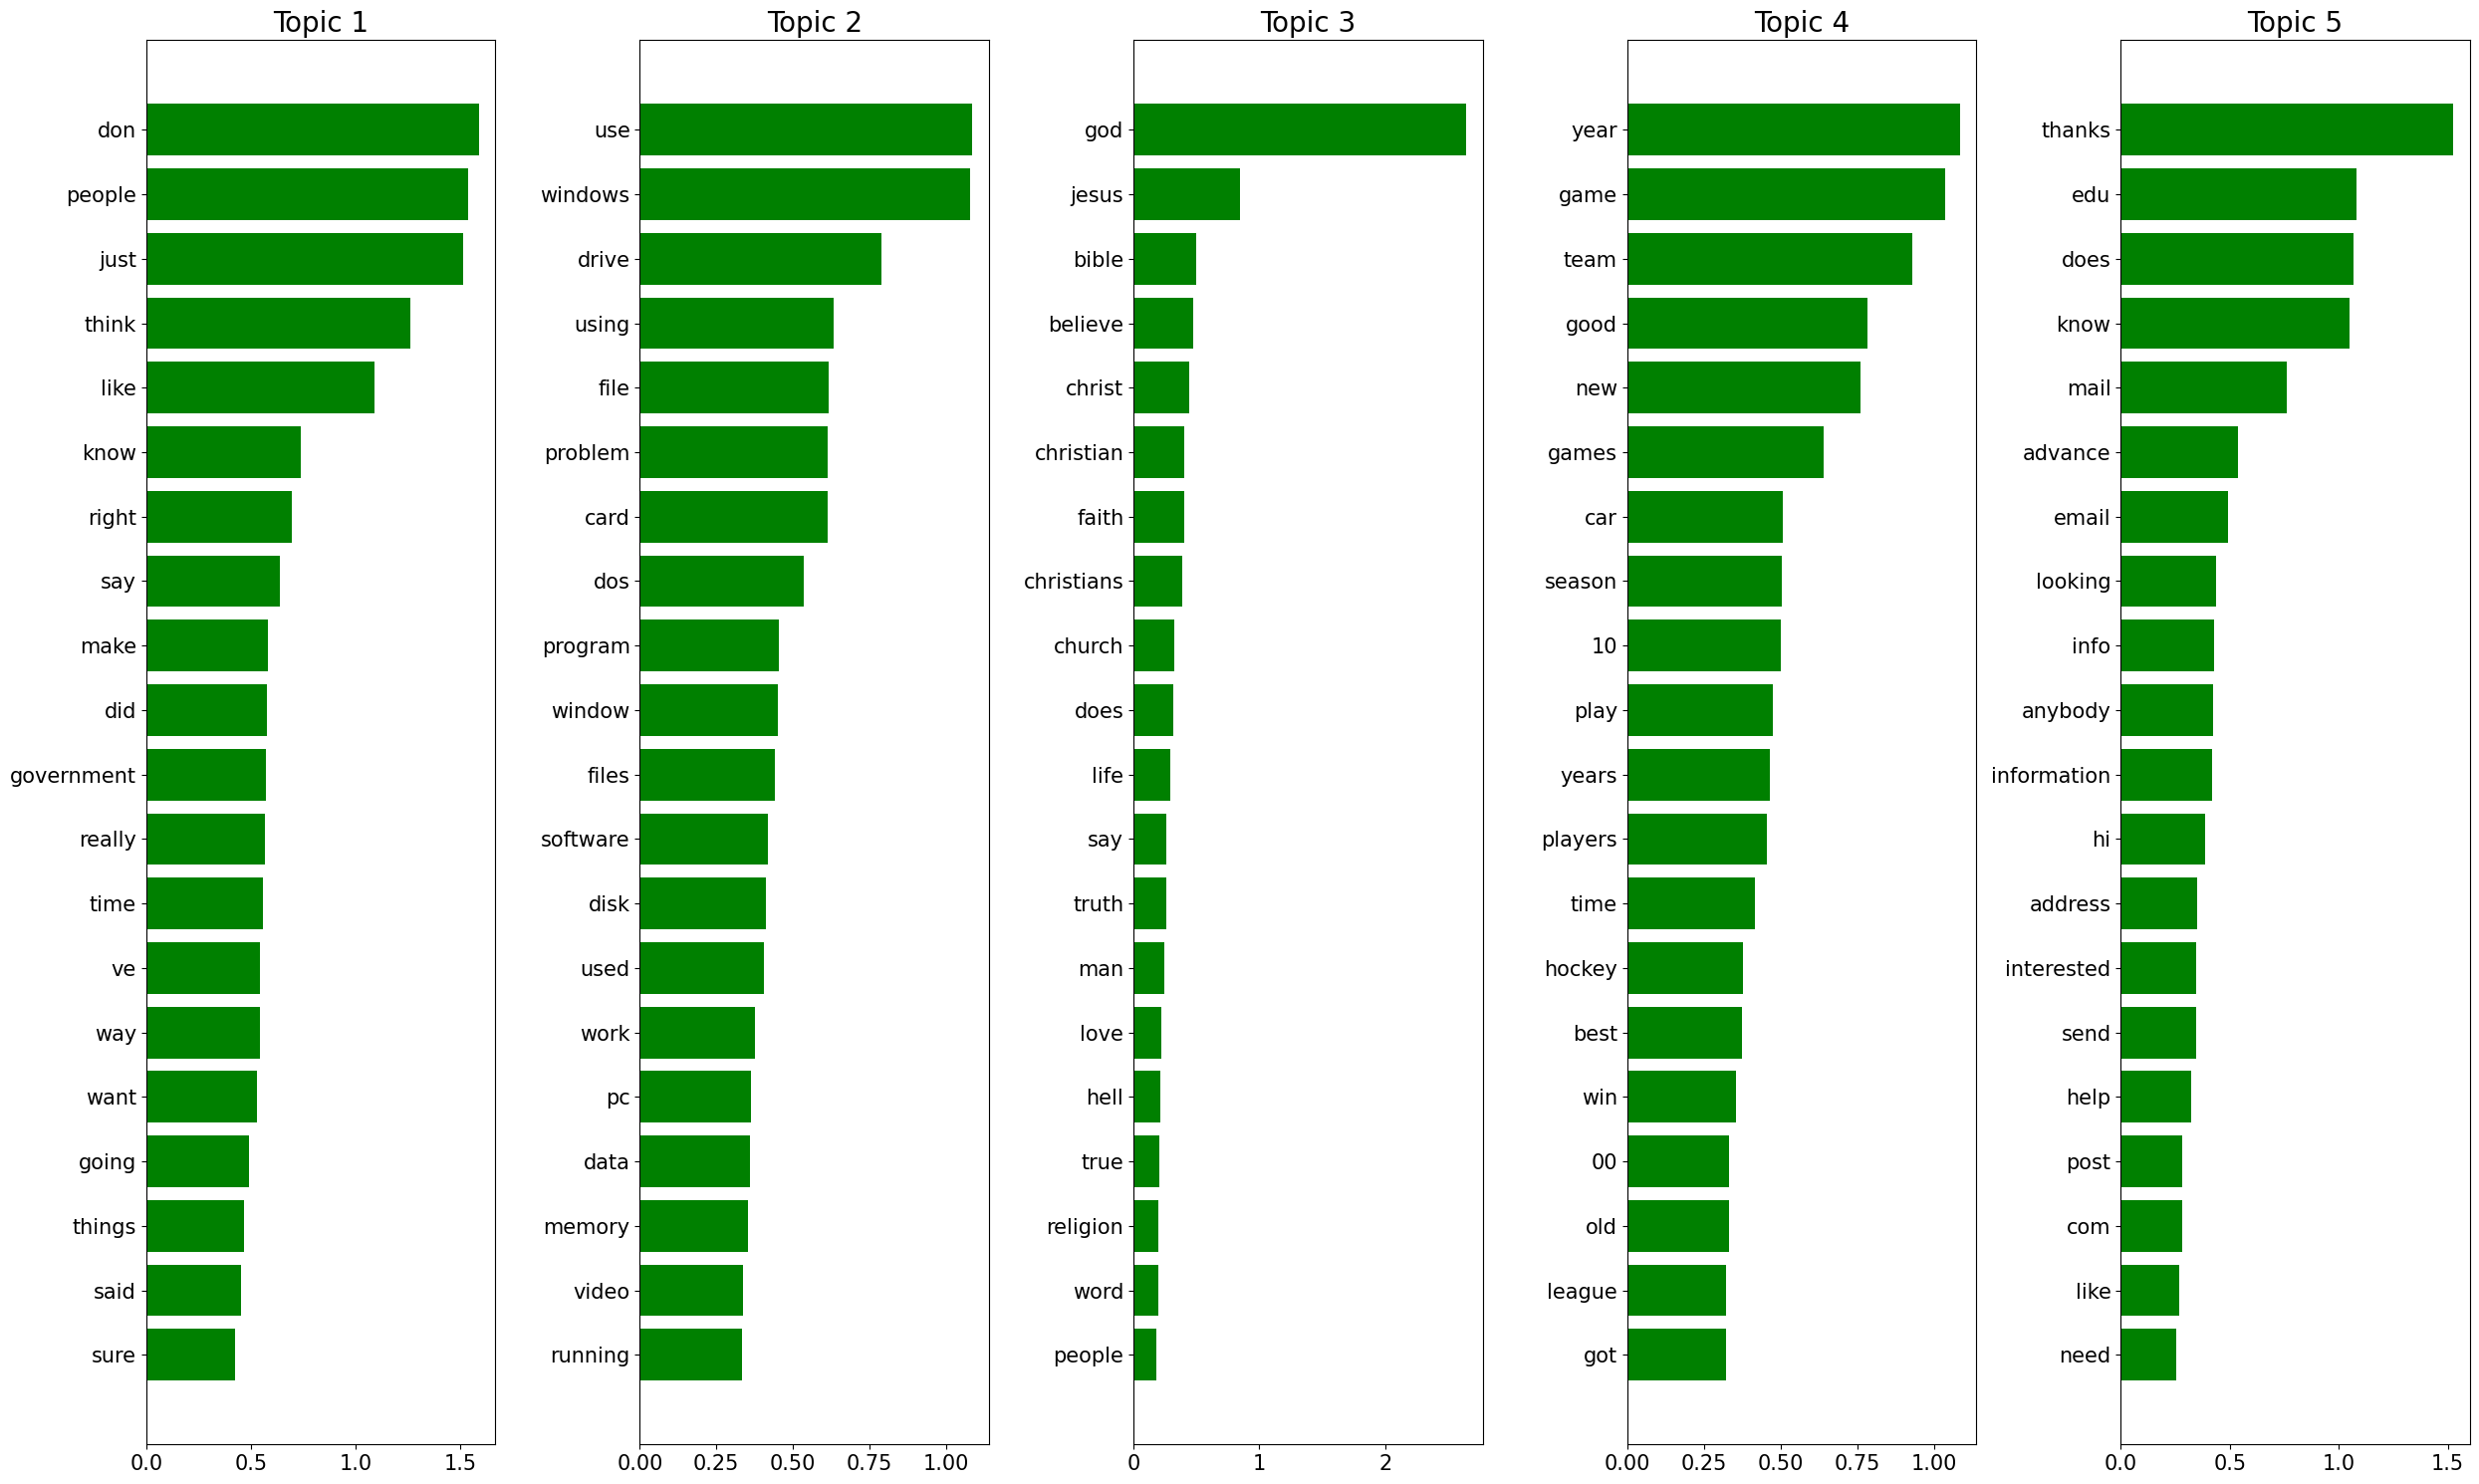

In [ ]:
# Define function for plotting top 20 words for each topic
def plot_words_for_topics(n_comp, nmf, feature_names):
  fig, axes = plt.subplots(((n_comp-1)//5)+1, 5, figsize=(25, 15))
  axes = axes.flatten()

  for num_topic, topic in enumerate(nmf.components_, start=1):

    # Plot only the top 20 words

    # Get the top 20 indexes
    top_indexes = np.flip(topic.argsort()[-20:])

    # Get the corresponding feature name
    top_features = [feature_names[i] for i in top_indexes]

    # Get the importance of each word
    importance = topic[top_indexes]

    # Plot a barplot
    ax = axes[num_topic-1]
    ax.barh(top_features, importance, color="green")
    ax.set_title(f"Topic {num_topic}", {"fontsize": 20})
    ax.invert_yaxis()
    ax.tick_params(labelsize=15)

  plt.tight_layout()
  plt.show()

# Run the function
plot_words_for_topics(n_comp, nmf, feature_names)

Let's try to summarize each topic based on the top most common words for each one:

- The first topic is hard to describe but seems to be related to people and actions.

- The second one is clearly abouth tech stuff.

- Third one is about religion.

- Fourth one seems to revolve around sports and/or games.

- And the fifth one about education and/or information.


This makes sense considering the example with the first element of the text data. That text is mostly about cars (sports) and information.

Pretty cool, right?


The following function condenses the previously used code so you can play trying out with different number of components:

In [ ]:
def try_NMF(n_comp):
  nmf = NMF(n_components=n_comp, random_state=42)
  nmf.fit(vect_data)
  feature_names = vectorizer.get_feature_names_out()
  plot_words_for_topics(n_comp, nmf, feature_names)

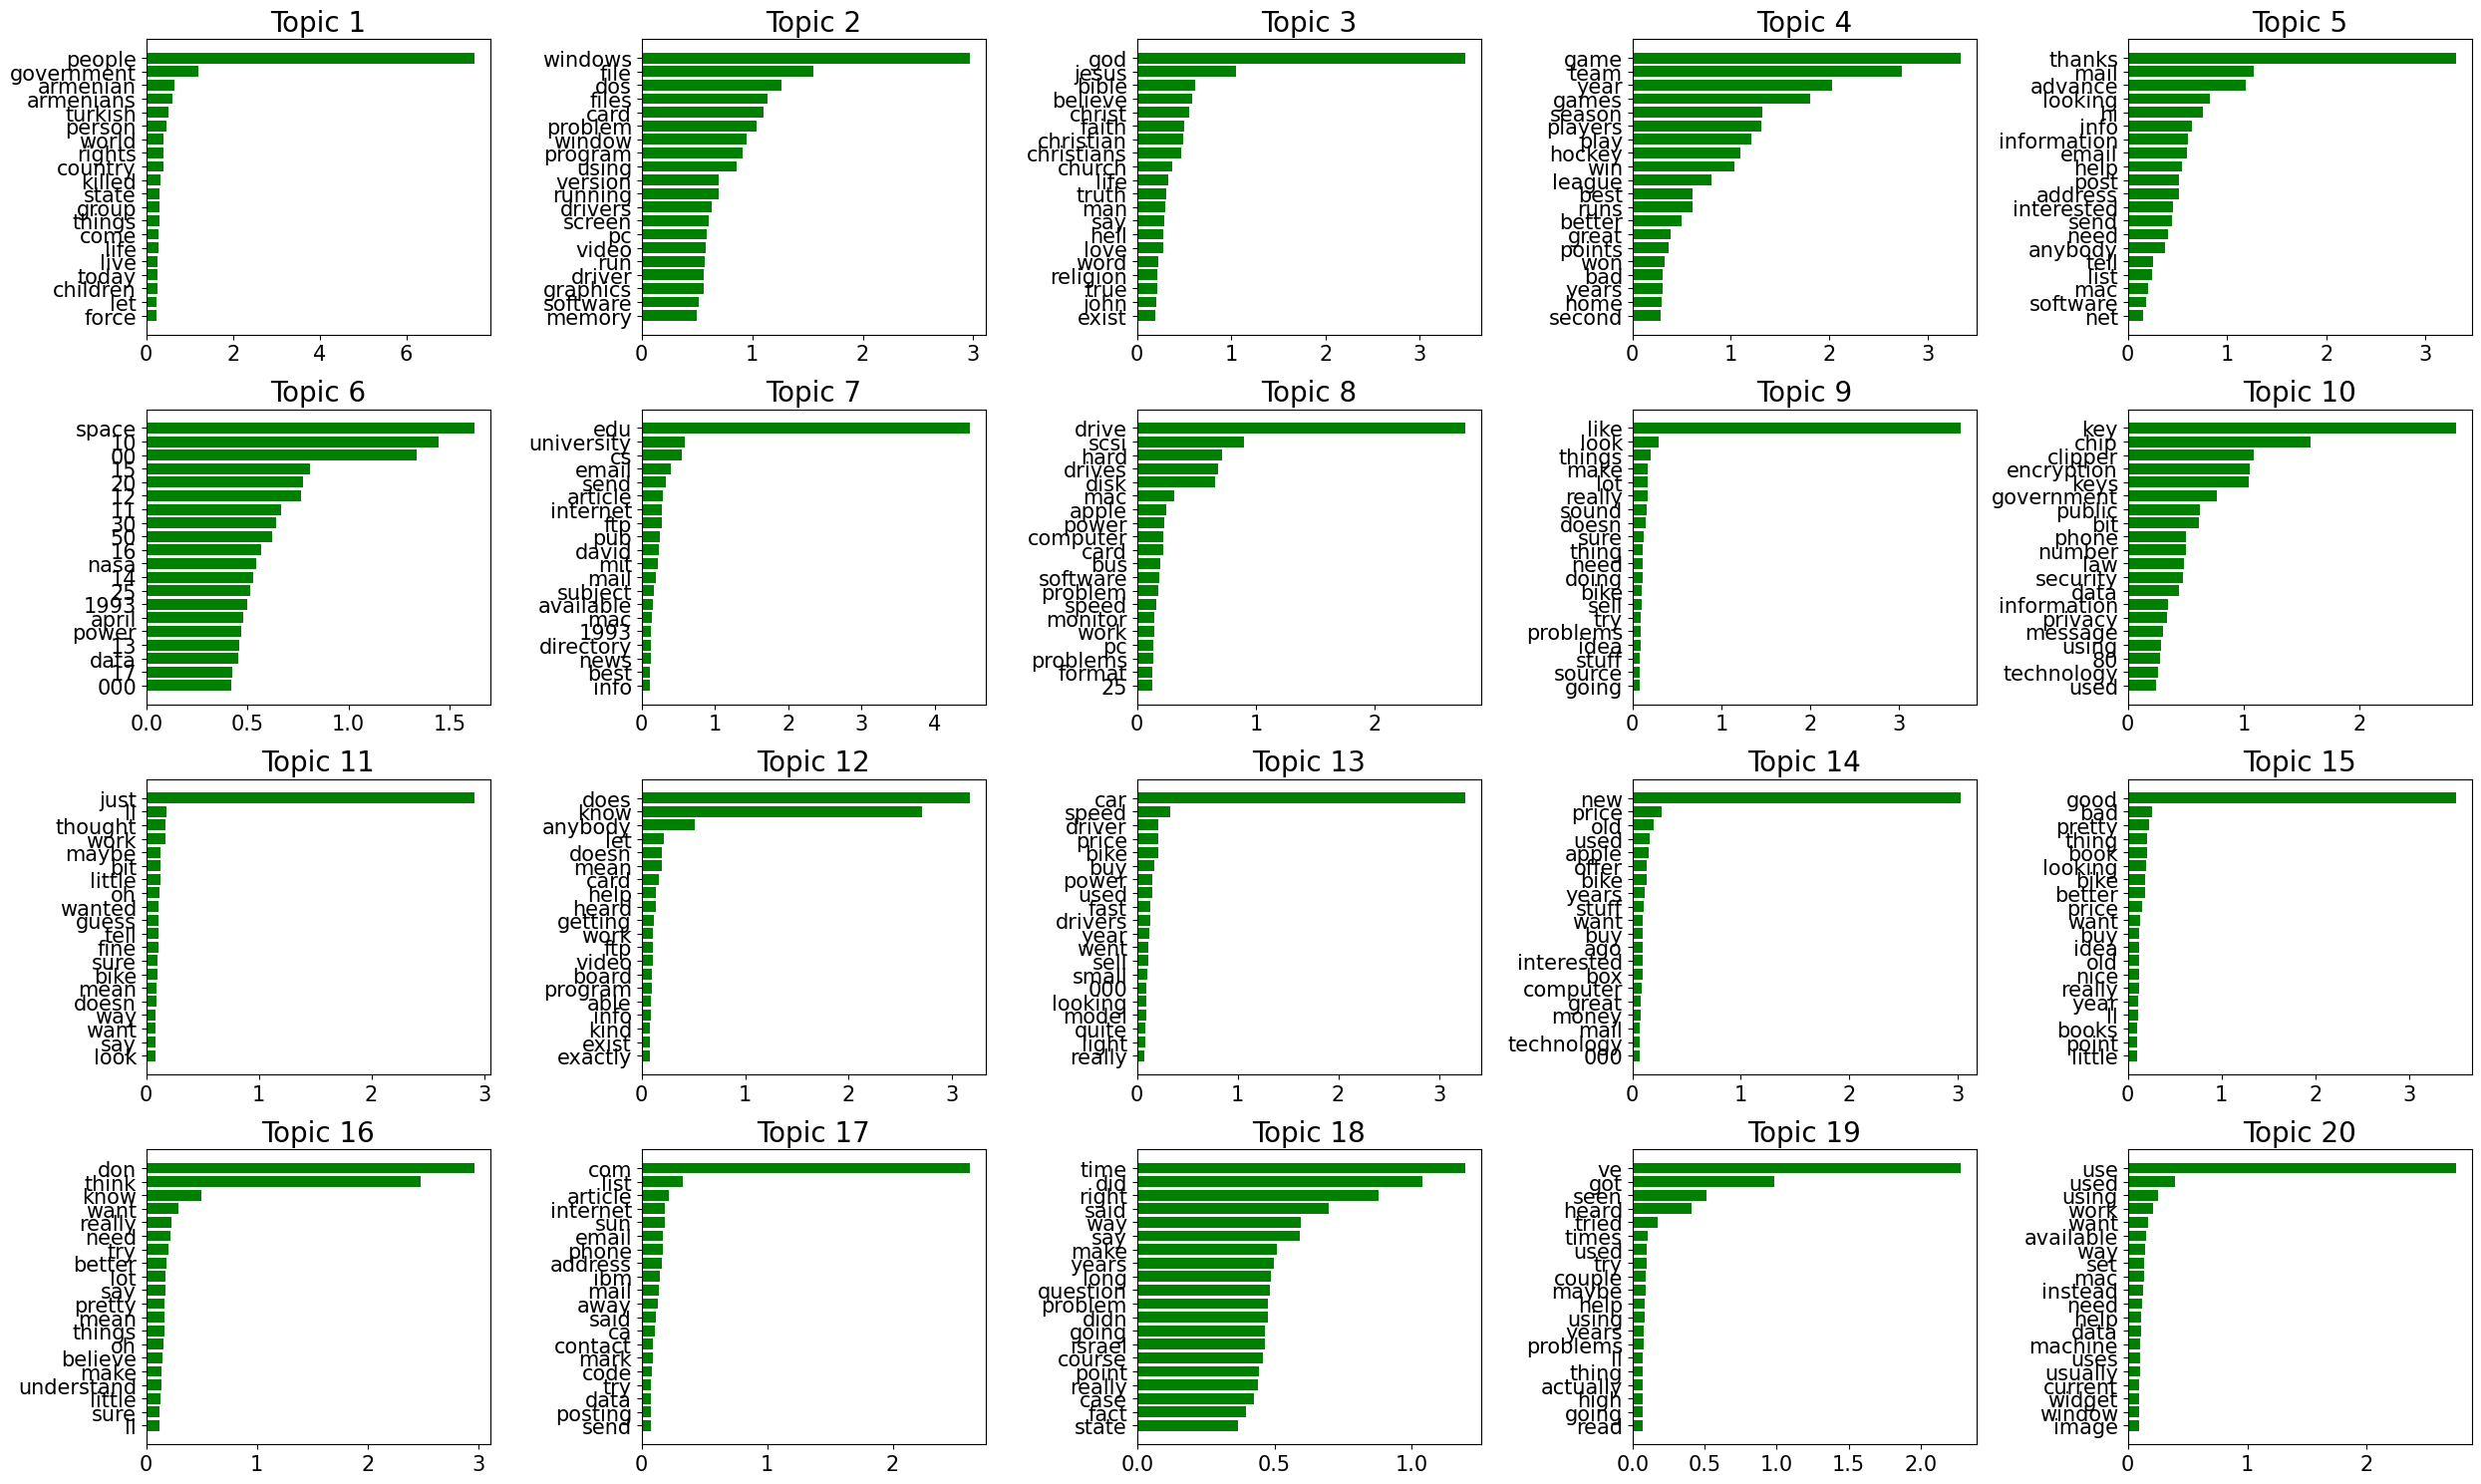

In [ ]:
# Try different values!
try_NMF(20)

## 1.4 Quantization & Pruning

### 1.4.1 Mobile, IoT, and Similar Use Cases


To generate real-time predictions can:
- Host the model on a server
- Embed the model in the device

#### Mobile inference


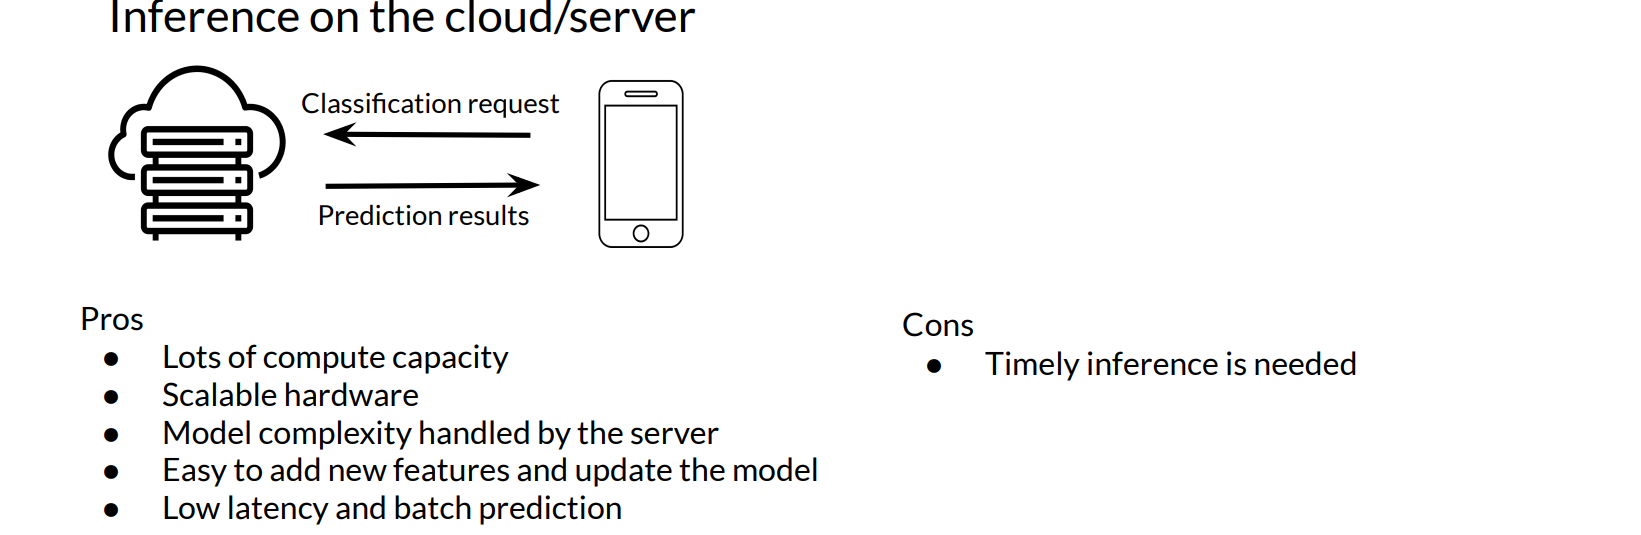

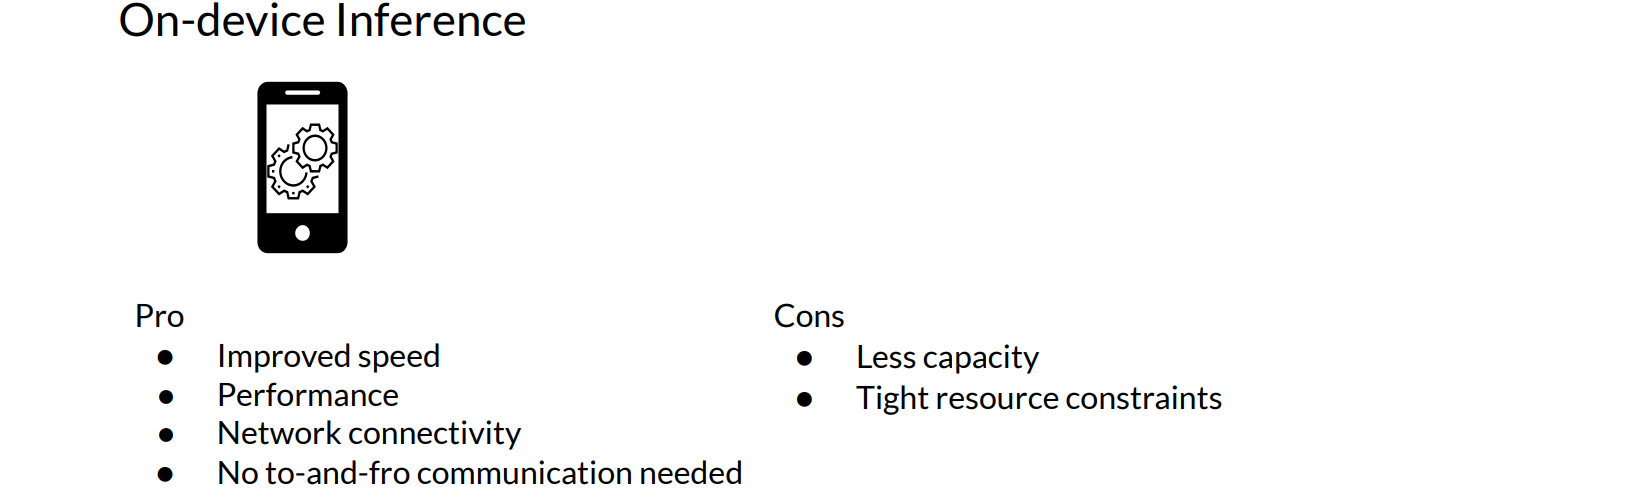

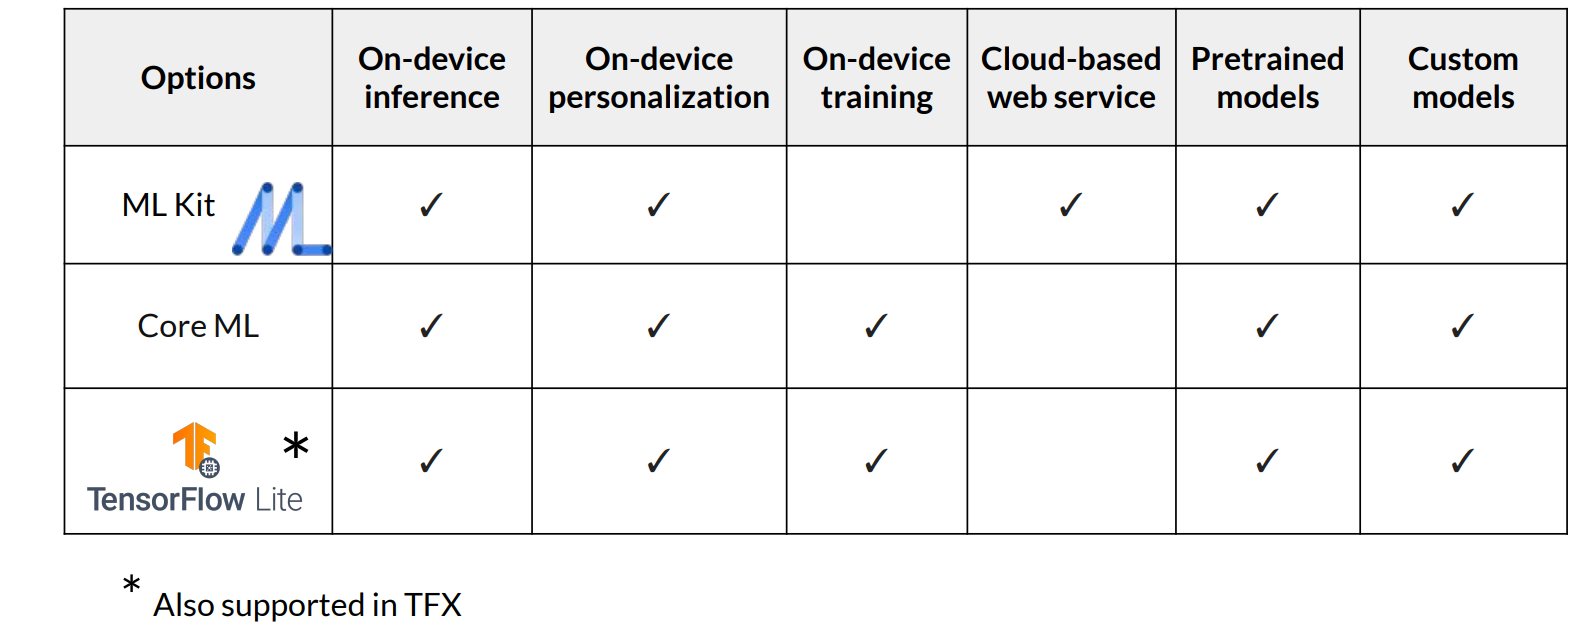

### 1.4.2 Benefits and Process of Quantization

- Neural networks have many parameters and take up space
- Shrinking model file size
- Reduce computational resources
- Make models run faster and use less power with low-precision


#### MobileNets: Latency vs Accuracy trade-off

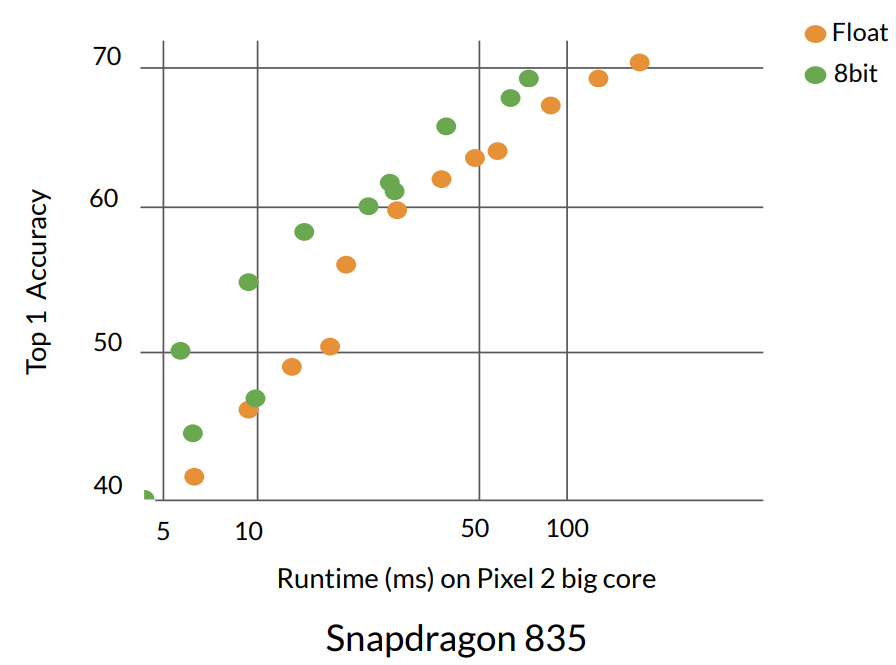

#### The quantization process

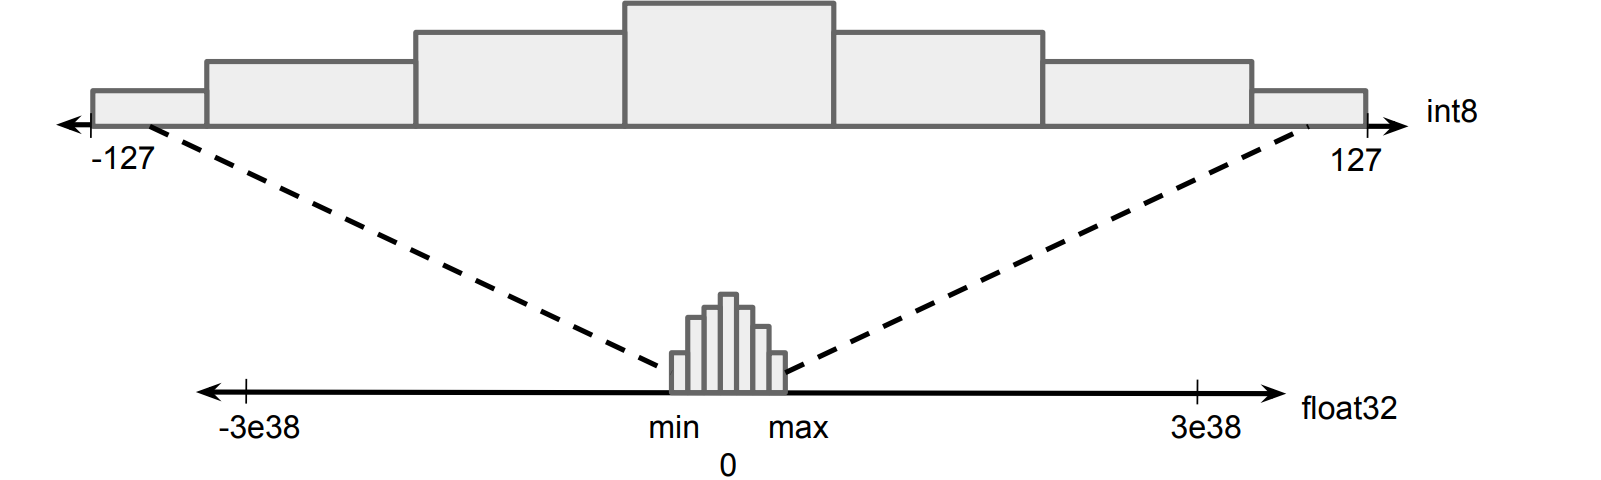

What parts of the model are affected?
- Static values (parameters)
- Dynamic values (activations)
- Computation (transformations)


Trade-offs
- Optimizations impact model accuracy
    - Difficult to predict ahead of time
- In rare cases, models may actually gain some accuracy
- Undefined effects on ML interpretability


#### Post Training Quantization

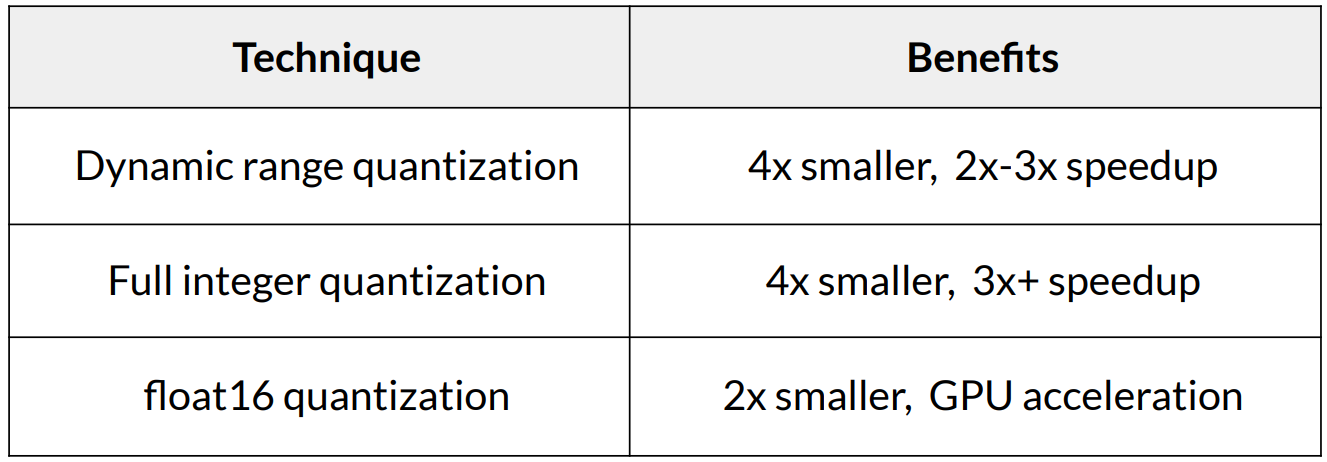

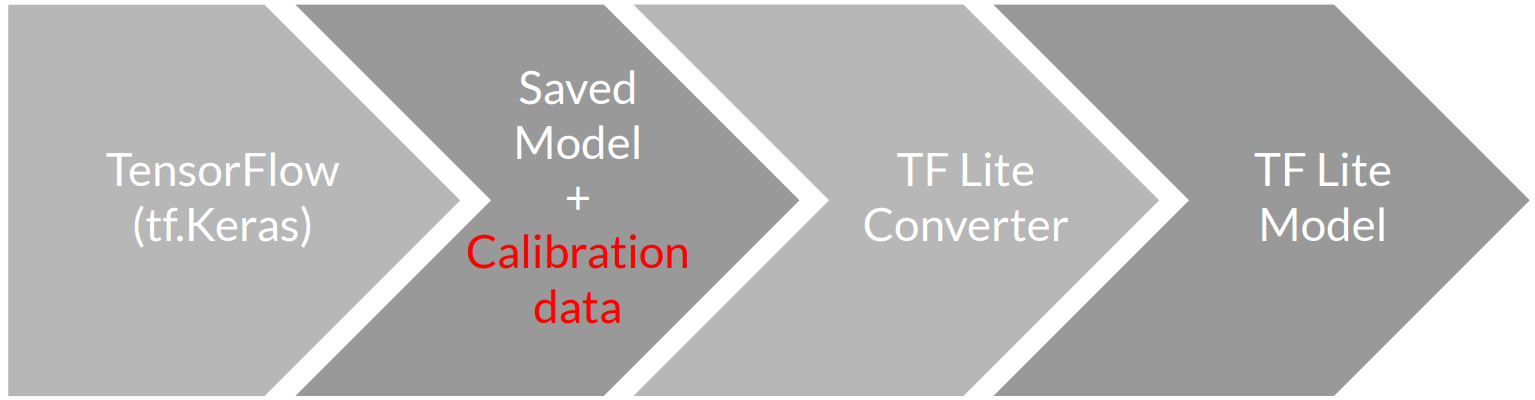

Model accuracy
- Small accuracy loss incurred (mostly for smaller networks)
- Use the benchmarking tools to evaluate model accuracy
- If the loss of accuracy drop is not within acceptable limits, consider
using quantization-aware training


#### Quantization Aware Training

Quantization-aware training (QAT)
- Inserts fake quantization (FQ) nodes in the forward pass
- Rewrites the graph to emulate quantized inference
- Reduces the loss of accuracy due to quantization
- Resulting model contains all data to be quantized according to spec


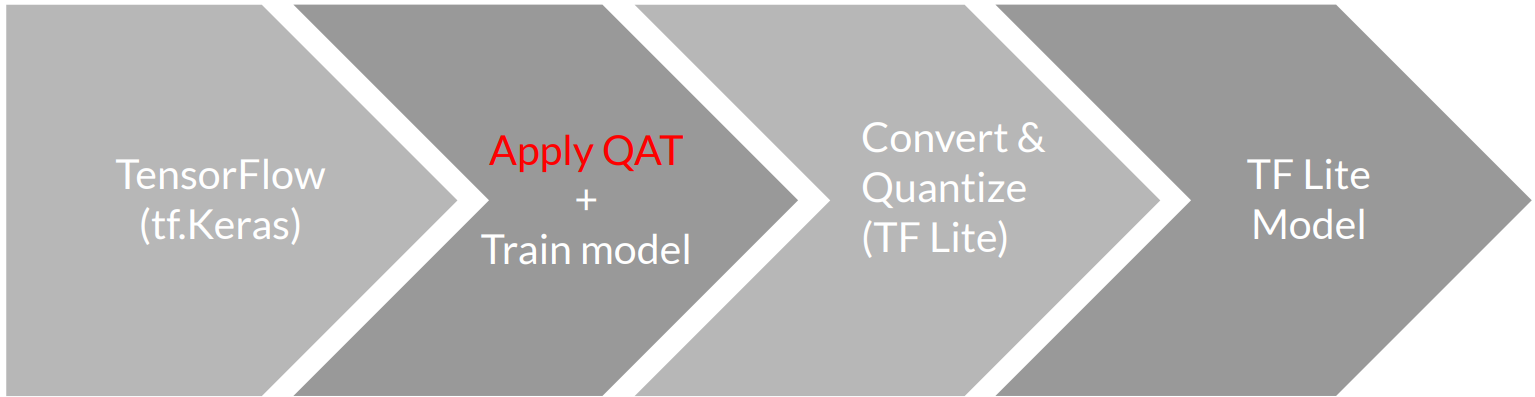

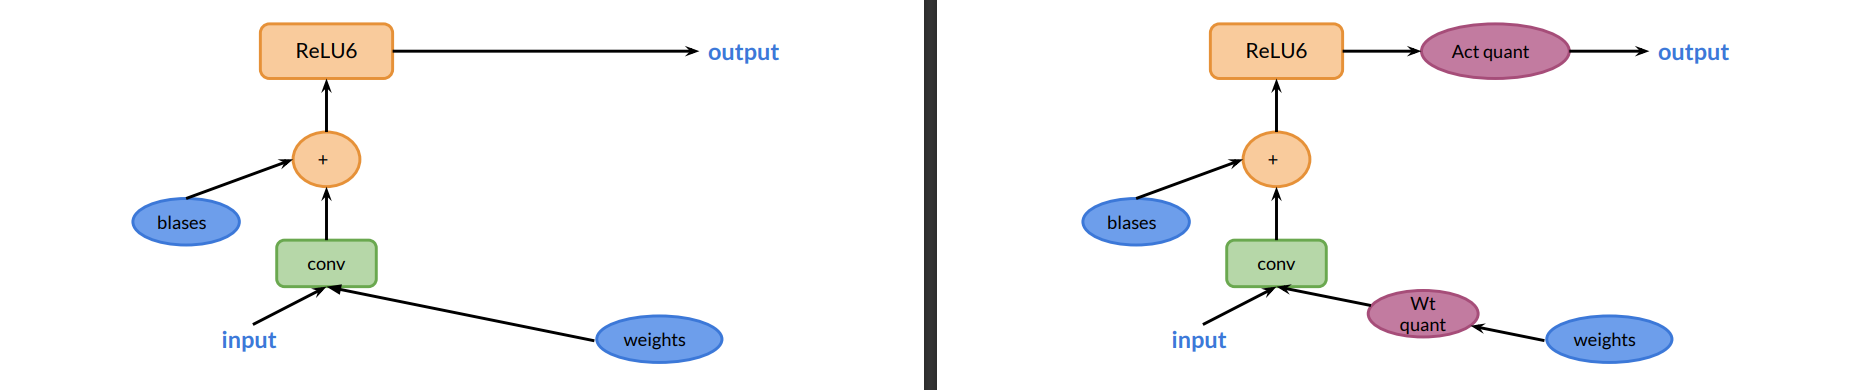

#### Model Optimization Results

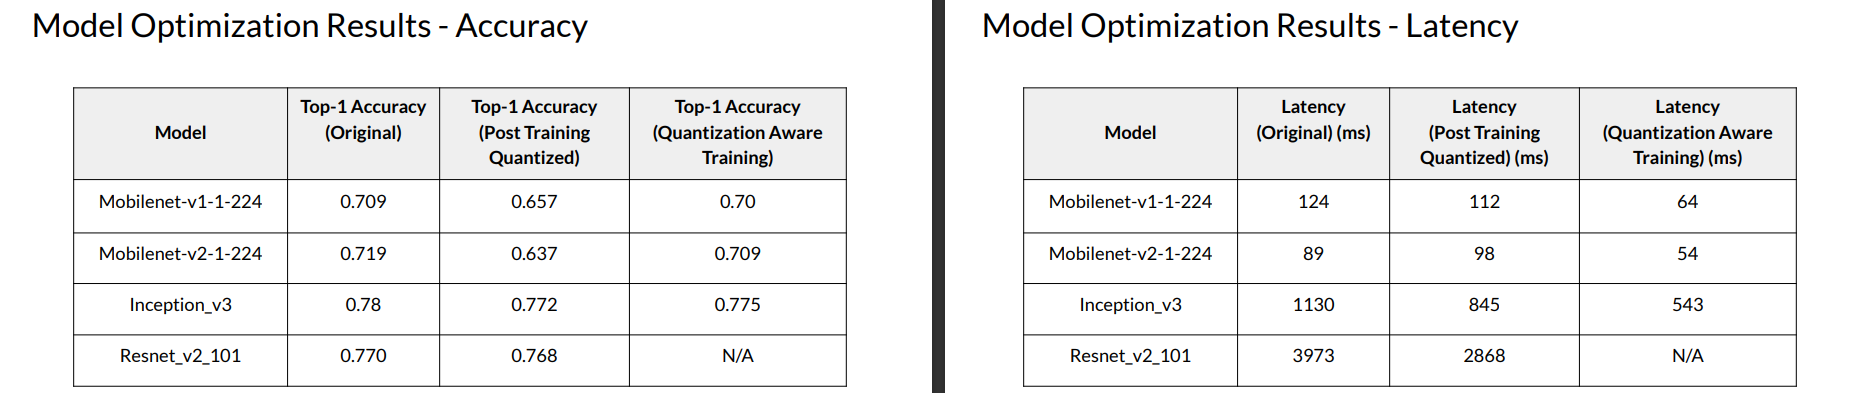

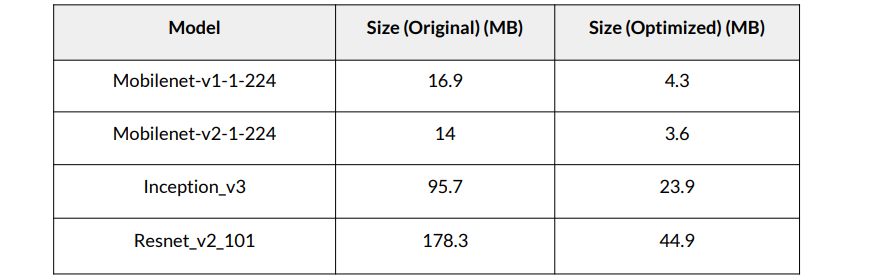

### 1.4.3 Pruning

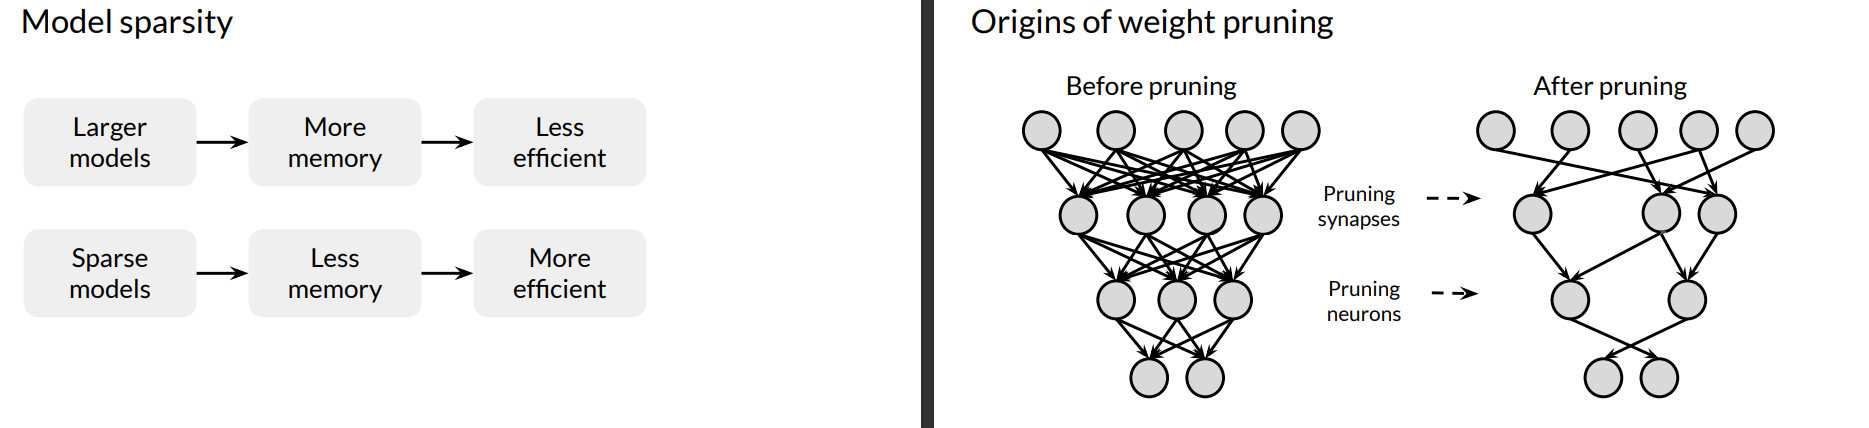

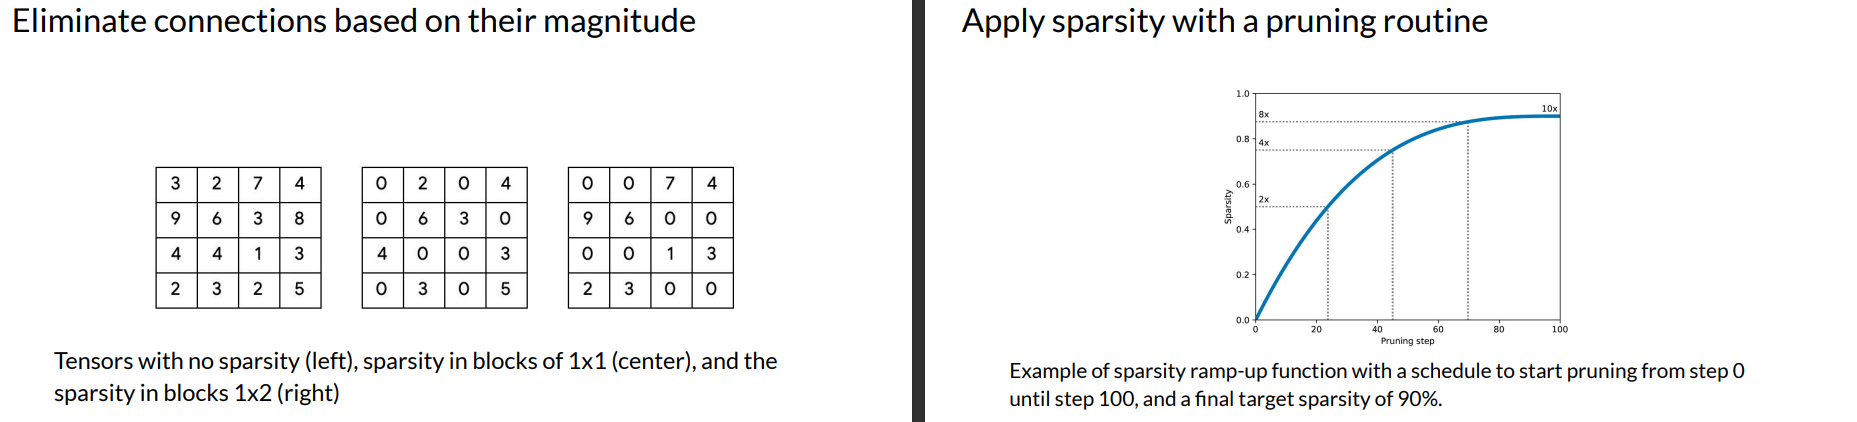

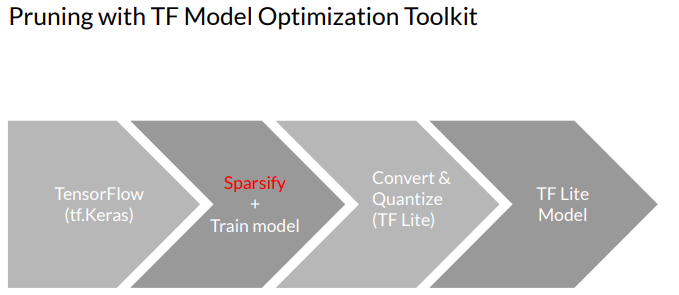

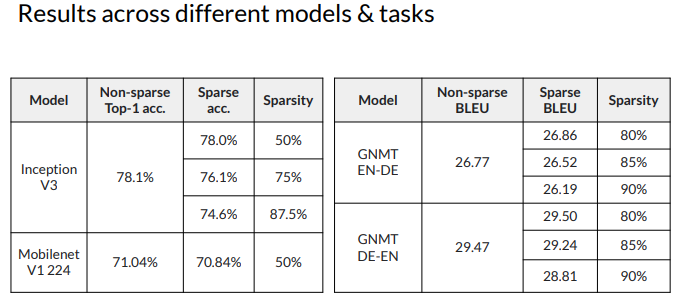

### 1.4.4 Quantization and Pruning



#### Imports

Import a few common libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import tempfile
import zipfile

#### Utilities and constants

First define a few string constants and utility functions to make the code easier to maintain.

In [ ]:
# GLOBAL VARIABLES

# String constants for model filenames
FILE_WEIGHTS = 'baseline_weights.h5'
FILE_NON_QUANTIZED_H5 = 'non_quantized.h5'
FILE_NON_QUANTIZED_TFLITE = 'non_quantized.tflite'
FILE_PT_QUANTIZED = 'post_training_quantized.tflite'
FILE_QAT_QUANTIZED = 'quant_aware_quantized.tflite'
FILE_PRUNED_MODEL_H5 = 'pruned_model.h5'
FILE_PRUNED_QUANTIZED_TFLITE = 'pruned_quantized.tflite'
FILE_PRUNED_NON_QUANTIZED_TFLITE = 'pruned_non_quantized.tflite'

# Dictionaries to hold measurements
MODEL_SIZE = {}
ACCURACY = {}

In [ ]:
# UTILITY FUNCTIONS

def print_metric(metric_dict, metric_name):
  '''Prints key and values stored in a dictionary'''
  for metric, value in metric_dict.items():
    print(f'{metric_name} for {metric}: {value}')


def model_builder():
  '''Returns a shallow CNN for training on the MNIST dataset'''

  keras = tf.keras

  # Define the model architecture.
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
  ])

  return model


def evaluate_tflite_model(filename, x_test, y_test):
  '''
  Measures the accuracy of a given TF Lite model and test set

  Args:
    filename (string) - filename of the model to load
    x_test (numpy array) - test images
    y_test (numpy array) - test labels

  Returns
    float showing the accuracy against the test set
  '''

  # Initialize the TF Lite Interpreter and allocate tensors
  interpreter = tf.lite.Interpreter(model_path=filename)
  interpreter.allocate_tensors()

  # Get input and output index
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Initialize empty predictions list
  prediction_digits = []

  # Run predictions on every image in the "test" dataset.
  for i, test_image in enumerate(x_test):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()

  return accuracy


def get_gzipped_model_size(file):
  '''Returns size of gzipped model, in bytes.'''
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

#### Download and Prepare the Dataset

Use the [MNIST](https://keras.io/api/datasets/mnist/) dataset which is hosted in [Keras Datasets](https://keras.io/api/datasets/).

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

#### Baseline Model


In [ ]:
# Create the baseline model
baseline_model = model_builder()

# Save the initial weights for use later
baseline_model.save_weights(FILE_WEIGHTS)

# Print the model summary
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

Then compile and train the model.

In [ ]:
# Setup the model for training
baseline_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
baseline_model.fit(train_images, train_labels, epochs=1, shuffle=False)

1875/1875 [==============================] - 24s 12ms/step - loss: 0.2521 - accuracy: 0.9320


Save the accuracy of the model against the test set so to compare later.

In [ ]:
# Get the baseline accuracy
_, ACCURACY['baseline Keras model'] = baseline_model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.1080 - accuracy: 0.9681


Next, save the Keras model as a file and record its size as well.

In [ ]:
# Save the Keras model
baseline_model.save(FILE_NON_QUANTIZED_H5, include_optimizer=False)

# Save and get the model size
MODEL_SIZE['baseline h5'] = os.path.getsize(FILE_NON_QUANTIZED_H5)

# Print records so far
print_metric(ACCURACY, "test accuracy")
print_metric(MODEL_SIZE, "model size in bytes")

test accuracy for baseline Keras model: 0.9681000113487244
model size in bytes for baseline h5: 98928


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Convert the model to TF Lite format

Next,convert the model to [Tensorflow Lite (TF Lite)](https://www.tensorflow.org/lite/guide) format. This is designed to make Tensorflow models more efficient and lightweight when running on mobile, embedded, and IOT devices.

Can convert a Keras model with TF Lite's [Converter](https://www.tensorflow.org/lite/convert/index) class and we've incorporated it in the short helper function below. Notice that there is a `quantize` flag which can use to quantize the model.

In [ ]:
def convert_tflite(model, filename, quantize=False):
  '''
  Converts the model to TF Lite format and writes to a file

  Args:
    model (Keras model) - model to convert to TF Lite
    filename (string) - string to use when saving the file
    quantize (bool) - flag to indicate quantization

  Returns:
    None
  '''

  # Initialize the converter
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  # Set for quantization if flag is set to True
  if quantize:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Convert the model
  tflite_model = converter.convert()

  # Save the model.
  with open(filename, 'wb') as f:
    f.write(tflite_model)

Use the helper function to convert the Keras model then get its size and accuracy. Take note that this is *not yet* quantized.

In [ ]:
# Convert baseline model
convert_tflite(baseline_model, FILE_NON_QUANTIZED_TFLITE)

Notice that there is already a slight decrease in model size when converting to `.tflite` format.

In [ ]:
MODEL_SIZE['non quantized tflite'] = os.path.getsize(FILE_NON_QUANTIZED_TFLITE)

print_metric(MODEL_SIZE, 'model size in bytes')

model size in bytes for baseline h5: 98928
model size in bytes for non quantized tflite: 85096


The accuracy will also be nearly identical when converting between formats.Also can setup a TF Lite model for input-output using its [Interpreter](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) class. This is shown in the `evaluate_tflite_model()` helper function provided in the `Utilities` section earlier.

In [ ]:
ACCURACY['non quantized tflite'] = evaluate_tflite_model(FILE_NON_QUANTIZED_TFLITE, test_images, test_labels)

In [ ]:
print_metric(ACCURACY, 'test accuracy')

test accuracy for baseline Keras model: 0.9681000113487244
test accuracy for non quantized tflite: 0.9681


#### Post-Training Quantization

Now that consider the baseline metrics, and observe the effects of quantization.

As shown in the `convert_tflite()` helper function earlier, can easily do [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with the TF Lite API. Only need to set the converter optimization and assign an [Optimize](https://www.tensorflow.org/api_docs/python/tf/lite/Optimize) Enum.

Set the `quantize` flag to do that and get the metrics again.

In [ ]:
# Convert and quantize the baseline model
convert_tflite(baseline_model, FILE_PT_QUANTIZED, quantize=True)

In [ ]:
# Get the model size
MODEL_SIZE['post training quantized tflite'] = os.path.getsize(FILE_PT_QUANTIZED)

print_metric(MODEL_SIZE, 'model size')

model size for baseline h5: 98928
model size for non quantized tflite: 85096
model size for post training quantized tflite: 24336


You should see around a 4X reduction in model size in the quantized version. This comes from converting the 32 bit representations (float) into 8 bits (integer).



In [ ]:
ACCURACY['post training quantized tflite'] = evaluate_tflite_model(FILE_PT_QUANTIZED, test_images, test_labels)

In [ ]:
print_metric(ACCURACY, 'test accuracy')

test accuracy for baseline Keras model: 0.9681000113487244
test accuracy for non quantized tflite: 0.9681
test accuracy for post training quantized tflite: 0.9681


AsCan expect the accuracy to not be the same when quantizing the model. Most of the time it will decrease but in some cases, it can even increase. Again, this can be attributed to the loss of precision when remove the extra bits from the float data.

#### Quantization Aware Training

When post-training quantization results in loss of accuracy that is unacceptable for the application, can consider doing [quantization aware training](https://www.tensorflow.org/model_optimization/guide/quantization/training) before quantizing the model. This simulates the loss of precision by inserting fake quant nodes in the model during training. That way, your model will learn to adapt with the loss of precision to get more accurate predictions.

The [Tensorflow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization) provides a [quantize_model()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/quantization/keras/quantize_model) method to do this quickly.<br> First install the toolkit into the notebook environment.

In [ ]:
# Install the toolkit
!pip install tensorflow_model_optimization==0.7.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 4.9 MB/s eta 0:00:00


Build the baseline model again but this time, pass it into the `quantize_model()` method to indicate quantization aware training.



In [ ]:
import tensorflow_model_optimization as tfmot

# method to quantize a Keras model
quantize_model = tfmot.quantization.keras.quantize_model

# Define the model architecture.
model_to_quantize = model_builder()

# Reinitialize weights with saved file
model_to_quantize.load_weights(FILE_WEIGHTS)

# Quantize the model
q_aware_model = quantize_model(model_to_quantize)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_reshape_2 (QuantizeW  (None, 28, 28, 1)         1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_2 (QuantizeWr  (None, 26, 26, 12)        147       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_2 (Qua  (None, 13, 13, 12)        1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_flatten_2 (QuantizeW  (None, 2028)             

Noticed a slight difference in the model summary above compared to the baseline model summary in the earlier sections. The total params count increased as expected because of the nodes added by the `quantize_model()` method.

With that, now train the model. Also note that the accuracy is a bit lower because the model is simulating the loss of precision. The training will take a bit longer if want to achieve the same training accuracy as the earlier run.

In [ ]:
# Train the model
q_aware_model.fit(train_images, train_labels, epochs=1, shuffle=False)

1875/1875 [==============================] - 28s 14ms/step - loss: 0.2588 - accuracy: 0.9299


Then get the accuracy of the Keras model before and after quantizing the model. The accuracy is expected to be nearly identical because the model is trained to counter the effects of quantization.

In [ ]:
# Reinitialize the dictionary
ACCURACY = {}

# Get the accuracy of the quantization aware trained model (not yet quantized)
_, ACCURACY['quantization aware non-quantized'] = q_aware_model.evaluate(test_images, test_labels, verbose=0)
print_metric(ACCURACY, 'test accuracy')

test accuracy for quantization aware non-quantized: 0.9678999781608582


In [ ]:
# Convert and quantize the model.
convert_tflite(q_aware_model, FILE_QAT_QUANTIZED, quantize=True)

# Get the accuracy of the quantized model
ACCURACY['quantization aware quantized'] = evaluate_tflite_model(FILE_QAT_QUANTIZED, test_images, test_labels)
print_metric(ACCURACY, 'test accuracy')

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


test accuracy for quantization aware non-quantized: 0.9678999781608582
test accuracy for quantization aware quantized: 0.9679


#### Pruning

Another technique for reducing model size: [Pruning](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras). This process involves zeroing out insignificant (i.e. low magnitude) weights. The intuition is these weights do not contribute as much to making predictions so can remove them and get the same result. Making the weights sparse helps in compressing the model more efficiently.

The Tensorflow Model Optimization Toolkit again has a convenience method for this. The [prune_low_magnitude()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/prune_low_magnitude) method puts wrappers in a Keras model so it can be pruned during training.Pass in the baseline model that already trained earlier.Then notice that the model summary show increased params because of the wrapper layers added by the pruning method.

Can set how the pruning is done during training. Below,use [PolynomialDecay](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/PolynomialDecay) to indicate how the sparsity ramps up with each step. Another option available in the library is [Constant Sparsity](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity).

In [ ]:
# Get the pruning method
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define pruning schedule.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

# Pass in the trained baseline model
model_for_pruning = prune_low_magnitude(baseline_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshap  (None, 28, 28, 1)         1         
 e_1 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv2d  (None, 26, 26, 12)        230       
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 13, 13, 12)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_flatte  (None, 2028)              1         
 n_1 (PruneLowMagnitude)                                         
                                                      

Also peek at the weights of one of the layers in the model. After pruning,notice that many of these will be zeroed out.

In [ ]:
# Preview model weights
model_for_pruning.weights[1]

<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[ 0.36157465,  0.02635845,  0.1096181 ,  0.3587717 ,
           0.22284763, -0.36116084,  0.30927196,  0.21249561,
          -0.4586076 ,  0.27663925,  0.29245245,  0.04786927]],

        [[ 0.2530961 ,  0.3680997 ,  0.2831001 ,  0.4613221 ,
           0.38914615, -0.51700634, -0.06523265,  0.4556632 ,
          -0.42890573,  0.1381009 , -0.12527485,  0.36007616]],

        [[ 0.30457398, -0.27408636,  0.02818631, -0.44354182,
           0.31118834, -0.32606158,  0.05970268,  0.3009542 ,
          -0.49415493,  0.12281536, -0.60945666,  0.60172975]]],


       [[[ 0.24762326,  0.14787063,  0.01665891,  0.608829  ,
          -0.11089497, -0.13494858,  0.31987405, -0.11073192,
           0.07196374,  0.29112816,  0.47103763, -0.59487605]],

        [[-0.06806963,  0.24605285,  0.15470272,  0.0333555 ,
           0.2956525 , -0.08947471,  0.16499943,  0.07806782,
           0.10094117,  0.12237192, -0.0382

With that, now start re-training the model. Take note that the [UpdatePruningStep()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/UpdatePruningStep) callback is required.

In [ ]:
# Callback to update pruning wrappers at each step
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

# Train and prune the model
model_for_pruning.fit(train_images, train_labels,
                  epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 24s 13ms/step - loss: 0.1469 - accuracy: 0.9623 - val_loss: 0.0949 - val_accuracy: 0.9755
Epoch 2/2
1688/1688 [==============================] - 22s 13ms/step - loss: 0.1063 - accuracy: 0.9698 - val_loss: 0.0793 - val_accuracy: 0.9798


Now see how the weights in the same layer looks like after pruning.

In [ ]:
# Preview model weights
model_for_pruning.weights[1]

<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[ 0.8626686 ,  0.        , -0.        , -0.        ,
           0.        , -0.        ,  0.        ,  0.        ,
          -0.6335436 , -0.        , -0.        , -0.        ]],

        [[ 0.        ,  0.        , -0.        , -0.        ,
           0.856225  , -1.0501986 ,  0.        ,  0.8231694 ,
          -0.        , -0.        , -0.        , -0.        ]],

        [[ 0.        ,  0.        , -0.        ,  0.        ,
           0.        , -0.        ,  0.        ,  0.        ,
          -0.        , -0.        , -1.0876013 ,  0.84239507]]],


       [[[-0.        ,  0.        , -0.        ,  1.3838412 ,
           0.        , -0.        ,  0.8624901 ,  0.        ,
           0.        , -0.        ,  0.8118293 , -0.        ]],

        [[ 0.        ,  0.        , -0.        , -0.        ,
           0.        , -0.        ,  0.        ,  0.        ,
          -0.        , -0.        , -0.    

After pruning, remove the wrapper layers to have the same layers and params as the baseline model. Do that with the [strip_pruning()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/strip_pruning) method as shown below. Do this so can save the model and also export to TF Lite format just like in the previous sections.

In [ ]:
# Remove pruning wrappers
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

See the same model weights but the index is different because the wrappers were removed.

In [ ]:
# Preview model weights (index 1 earlier is now 0 because pruning wrappers were removed)
model_for_export.weights[0]

<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[ 0.8626686 ,  0.        , -0.        , -0.        ,
           0.        , -0.        ,  0.        ,  0.        ,
          -0.6335436 , -0.        , -0.        , -0.        ]],

        [[ 0.        ,  0.        , -0.        , -0.        ,
           0.856225  , -1.0501986 ,  0.        ,  0.8231694 ,
          -0.        , -0.        , -0.        , -0.        ]],

        [[ 0.        ,  0.        , -0.        ,  0.        ,
           0.        , -0.        ,  0.        ,  0.        ,
          -0.        , -0.        , -1.0876013 ,  0.84239507]]],


       [[[-0.        ,  0.        , -0.        ,  1.3838412 ,
           0.        , -0.        ,  0.8624901 ,  0.        ,
           0.        , -0.        ,  0.8118293 , -0.        ]],

        [[ 0.        ,  0.        , -0.        , -0.        ,
           0.        , -0.        ,  0.        ,  0.        ,
          -0.        , -0.        , -0.    

Notice below that the pruned model will have the same file size as the baseline_model when saved as H5. This is to be expected. The improvement will be noticeable when compress the model as will be shown in the cell after this.

In [ ]:
# Save Keras model
model_for_export.save(FILE_PRUNED_MODEL_H5, include_optimizer=False)

# Get uncompressed model size of baseline and pruned models
MODEL_SIZE = {}
MODEL_SIZE['baseline h5'] = os.path.getsize(FILE_NON_QUANTIZED_H5)
MODEL_SIZE['pruned non quantized h5'] = os.path.getsize(FILE_PRUNED_MODEL_H5)

print_metric(MODEL_SIZE, 'model_size in bytes')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model_size in bytes for baseline h5: 98928
model_size in bytes for pruned non quantized h5: 98928


Use the `get_gzipped_model_size()` helper function in the `Utilities` to compress the models and get its resulting file size. Notice that the pruned model is about 3 times smaller. This is because of the sparse weights generated by the pruning process. The zeros can be compressed much more efficiently than the low magnitude weights before pruning.

In [ ]:
# Get compressed size of baseline and pruned models
MODEL_SIZE = {}
MODEL_SIZE['baseline h5'] = get_gzipped_model_size(FILE_NON_QUANTIZED_H5)
MODEL_SIZE['pruned non quantized h5'] = get_gzipped_model_size(FILE_PRUNED_MODEL_H5)

print_metric(MODEL_SIZE, "gzipped model size in bytes")

gzipped model size in bytes for baseline h5: 78106
gzipped model size in bytes for pruned non quantized h5: 25904


Make the model even more lightweight by quantizing the pruned model. This achieves around 10X reduction in compressed model size as compared to the baseline.

In [ ]:
# Convert and quantize the pruned model.
pruned_quantized_tflite = convert_tflite(model_for_export, FILE_PRUNED_QUANTIZED_TFLITE, quantize=True)

# Compress and get the model size
MODEL_SIZE['pruned quantized tflite'] = get_gzipped_model_size(FILE_PRUNED_QUANTIZED_TFLITE)
print_metric(MODEL_SIZE, "gzipped model size in bytes")

gzipped model size in bytes for baseline h5: 78106
gzipped model size in bytes for pruned non quantized h5: 25904
gzipped model size in bytes for pruned quantized tflite: 8573


As expected, the TF Lite model's accuracy will also be close to the Keras model.

In [ ]:
# Get accuracy of pruned Keras and TF Lite models
ACCURACY = {}

_, ACCURACY['pruned model h5'] = model_for_pruning.evaluate(test_images, test_labels)
ACCURACY['pruned and quantized tflite'] = evaluate_tflite_model(FILE_PRUNED_QUANTIZED_TFLITE, test_images, test_labels)

print_metric(ACCURACY, 'accuracy')

313/313 [==============================] - 3s 9ms/step - loss: 0.0946 - accuracy: 0.9708
accuracy for pruned model h5: 0.97079998254776
accuracy for pruned and quantized tflite: 0.9706


## 1.5 High Performance Modeling

### 1.5.1 Distributed Training


Two types :
1. Data parallelism: In data parallelism, models are replicated onto
different accelerators (GPU/TPU) and data is split between them
2. Model parallelism: When models are too large to fit on a single device
then they can be divided into partitions, assigning different partitions to
different accelerators


| Aspect                      | Data Parallelism                                                | Model Parallelism                                               |
|-----------------------------|-----------------------------------------------------------------|-----------------------------------------------------------------|
| Concept                     | In data parallelism, the model is replicated across multiple devices (GPUs or machines), and each replica processes a different subset of the training data. Gradients are then aggregated and used to update the shared model. | In model parallelism, different parts (layers or components) of the model are placed on different devices, and during the forward and backward passes, data flows through these components in a distributed manner. Each device computes a part of the model's output and gradients. |
| Communication               | Requires frequent communication between devices to exchange model parameters and gradients. | Requires less frequent communication between devices, as each device is responsible for computing only a portion of the model. However, synchronization may still be needed at certain points. |
| Scalability                 | Can scale effectively with increasing data size, as each device processes a different subset of the data. | Can scale effectively with increasing model complexity, as different devices handle different parts of the model. However, scaling may become challenging if certain components become bottlenecks. |
| Implementation Complexity   | Generally simpler to implement, as it involves replicating the model and synchronizing gradients. | Can be more complex to implement, as it requires careful partitioning of the model and coordination between different components. |
| Suitable Applications       | Well-suited for models with large datasets, such as image classification or language translation. | Well-suited for models with complex architectures, such as large-scale neural networks with many layers or intricate connections. |
| Overhead                    | May suffer from communication overhead, especially with large models or slow communication between devices. | May suffer from computational overhead due to the need for synchronization and coordination between different model components. |
| Resource Utilization        | Utilizes resources efficiently when there is a large amount of data to process. | Utilizes resources efficiently when there are multiple model components that can be processed simultaneously. |
| Examples                    | Distributed training of convolutional neural networks (CNNs) for image classification tasks. | Training transformer-based models like BERT for natural language processing tasks where different layers can be processed independently. |

#### Data Parallelism

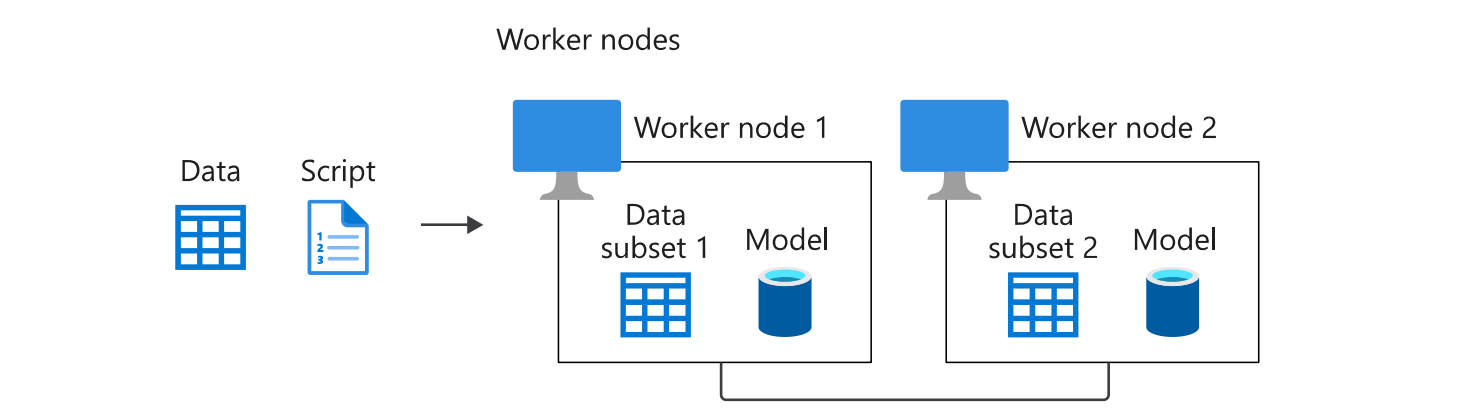

**Distributed training using data parallelism**


1. Synchronous training
    - All workers train and complete updates in sync
    - Supported via all-reduce architecture
2. Asynchronous Training
    - Each worker trains and completes updates separately
    - Supported via parameter server architecture
    - More efficient, but can result in lower accuracy and slower convergence


**tf.distribute.Strategy**

- Library in TensorFlow for running a computation in multiple devices
- Supports distribution strategies for high-level APIs like Keras and custom training loops
- Convenient to use with little or no code changes

**Distribution Strategies supported by tf.distribute.Strategy**



| Distribution Strategy       | Description                                                                                                                                                                                     | Suitable Use Cases                                                                                                                                                     |
|-----------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| One Device Strategy         | Runs the entire computation on a single device, typically useful for debugging or when the model and dataset are small and can fit within the memory of a single device.                     | Debugging, small-scale experiments, prototyping.                                                                                                                       |
| Mirrored Strategy           | Replicates the model across multiple devices (typically GPUs) within a single machine. Each device computes the same update on a different batch of data and synchronizes gradients to keep the model consistent. | Training deep learning models on a single machine with multiple GPUs. Can scale to large batch sizes and large models.                                                 |
| Parameter Server Strategy   | Splits the model across multiple devices or machines, with some devices acting as parameter servers and others as workers. Parameter servers store and update model parameters, while workers compute gradients.           | Distributed training across multiple devices or machines, especially when the model does not fit on a single device or when fine-grained control over communication is needed. |
| Multi-Worker Mirrored Strategy | An extension of the Mirrored Strategy that supports distributed training across multiple workers, each with multiple GPUs. Gradients are aggregated across all workers before updating the model.                | Large-scale distributed training across multiple machines with multiple GPUs per machine.                                                                                |
| Central Storage Strategy    | Similar to the Mirrored Strategy but uses a central storage server (like a file system or object store) to store model parameters instead of replicating them across devices. Each device fetches parameters as needed.  | Useful when network bandwidth is limited, as it reduces the amount of data transferred between devices during training.                                                    |
| TPU Strategy                | Optimized strategy for training models on Google's Tensor Processing Units (TPUs). It leverages the unique architecture and capabilities of TPUs for efficient distributed training.                          | Training deep learning models on Google Cloud Platform (GCP) with TPUs. TPUs offer high performance and scalability for certain types of workloads.                            |


**Fault tolerance**

- Catastrophic failures in one worker would cause failure of distribution strategies.
- How to enable fault tolerance in case a worker dies?
    - By restoring training state upon restart from job failure
    - Keras implementation: BackupAndRestore callback

### 1.5.2 Distributed Strategies with TF and Keras


The [`tf.distribute.MultiWorkerMirroredStrategy`](https://www.tensorflow.org/api_docs/python/tf/distribute/MultiWorkerMirroredStrategy).

With the help of this strategy, a Keras model that was designed to run on single-worker can seamlessly work on multiple workers with minimal code change.


#### Setup



In [ ]:
import os
import sys
import json
import time

# Log additional outputs from TF's C++ backend
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

Before importing TensorFlow, make a few changes to the environment.

- Disable all GPUs. This prevents errors caused by the workers all trying to use the same GPU. **For a real application each worker would be on a different machine.**


- Add the current directory to python's path so modules in this directory can be imported.

In [ ]:
# Disable GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Add current directory to path
if '.' not in sys.path:
  sys.path.insert(0, '.')

The previous step is important since this notebook relies on writting files using the magic command `%%writefile` and then importing them as modules.

Now that the environment configuration is ready, import TensorFlow.


In [ ]:
import tensorflow as tf

# Ignore warnings
tf.get_logger().setLevel('ERROR')

#### Dataset and model definition

Next create an `mnist.py` file with a simple model and dataset setup. This python file will be used by the worker-processes in this tutorial.

The name of this file derives from the dataset using which is called [mnist](https://keras.io/api/datasets/mnist/) and consists of 60,000 28x28 grayscale images of the first 10 digits.

In [ ]:
%%writefile mnist.py

# import os
import tensorflow as tf
import numpy as np

def mnist_dataset(batch_size):
  # Load the data
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize pixel values for x_train and cast to float32
  x_train = x_train / np.float32(255)
  # Cast y_train to int64
  y_train = y_train.astype(np.int64)
  # Define repeated and shuffled dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).repeat().batch(batch_size)
  return train_dataset


def build_and_compile_cnn_model():
  # Define simple CNN model using Keras Sequential
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(28, 28)),
      tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  # Compile model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      metrics=['accuracy'])

  return model

Overwriting mnist.py


Check that the file was succesfully created:

In [ ]:
!ls *.py

mnist.py


Import the mnist module just created and try training the model for a small number of epochs to observe the results of a single worker to make sure everything works correctly.

In [ ]:
# Import your mnist model
import mnist

# Set batch size
batch_size = 64

# Load the dataset
single_worker_dataset = mnist.mnist_dataset(batch_size)

# Load compiled CNN model
single_worker_model = mnist.build_and_compile_cnn_model()

# As training progresses, the loss should drop and the accuracy should increase.
single_worker_model.fit(single_worker_dataset, epochs=3, steps_per_epoch=70)

Epoch 1/3
70/70 [==============================] - 7s 78ms/step - loss: 2.2747 - accuracy: 0.1652
Epoch 2/3
70/70 [==============================] - 4s 53ms/step - loss: 2.1674 - accuracy: 0.4473
Epoch 3/3
70/70 [==============================] - 3s 47ms/step - loss: 2.0342 - accuracy: 0.6565


Everything is working as expected!

Nowsee how multiple workers can be used as a distributed strategy.

#### Multi-worker Configuration


Now let's enter the world of multi-worker training. In TensorFlow, the `TF_CONFIG` environment variable is required for training on multiple machines, each of which possibly has a different role. `TF_CONFIG` is a JSON string used to specify the cluster configuration on each worker that is part of the cluster.

There are two components of `TF_CONFIG`: `cluster` and `task`.

Let's dive into how they are used:

`cluster`:
- **It is the same for all workers** and provides information about the training cluster, which is a dict consisting of different types of jobs such as `worker`.

- In multi-worker training with `MultiWorkerMirroredStrategy`, there is usually one `worker` that takes on a little more responsibility like saving checkpoint and writing summary file for TensorBoard in addition to what a regular `worker` does.
-Such a worker is referred to as the `chief` worker, and it is customary that the `worker` with `index` 0 is appointed as the chief `worker` (in fact this is how `tf.distribute.Strategy` is implemented).

`task`:
- Provides information of the current task and is different on each worker. It specifies the `type` and `index` of that worker.

Here is an example configuration:

In [ ]:
tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

Here is the same `TF_CONFIG` serialized as a JSON string:

In [ ]:
json.dumps(tf_config)

'{"cluster": {"worker": ["localhost:12345", "localhost:23456"]}, "task": {"type": "worker", "index": 0}}'

#### Explaining the TF_CONFIG example


The example sets a `TF_CONFIG` with 2 workers on `localhost`. In practice, users would create multiple workers on external IP addresses/ports, and set `TF_CONFIG` on each worker appropriately.

Since the example sets the task `type` to `"worker"` and the task `index` to `0`, **this machine is the first worker and will be appointed as the chief worker**.

Note that other machines will need to have the `TF_CONFIG` environment variable set as well, and it should have the same `cluster` dict, but different task `type` or task `index` depending on what the roles of those machines are. For instance, for the second worker you would set `tf_config['task']['index']=1`.


#### Quick Note on Environment variables and subprocesses in notebooks


Above, `tf_config` is just a local variable in python. To actually use it to configure training, this dictionary needs to be serialized as JSON, and placed in the `TF_CONFIG` environment variable.

In the next section, spawn new subprocesses for each worker using the `%%bash` magic command. Subprocesses inherit environment variables from their parent, so they can access `TF_CONFIG`.



#### Choose the right strategy




In TensorFlow there are two main forms of distributed training:

* Synchronous training, where the steps of training are synced across the workers and replicas, and
* Asynchronous training, where the training steps are not strictly synced.

`MultiWorkerMirroredStrategy`, which is the recommended strategy for synchronous multi-worker training is the one you will be using.

To train the model, use an instance of `tf.distribute.MultiWorkerMirroredStrategy`.


In [ ]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

`MultiWorkerMirroredStrategy` creates copies of all variables in the model's layers on each device across all workers.  It uses `CollectiveOps`, a TensorFlow op for collective communication, to aggregate gradients and keep the variables in sync.  The [official TF distributed training guide](https://www.tensorflow.org/guide/distributed_training) has more details about this.


#### Implement Distributed Training via Context Managers


To distribute the training to multiple-workers allneed to do is to enclose the model building and `model.compile()` call inside `strategy.scope()`.

The distribution strategy's scope dictates how and where the variables are created, and in the case of `MultiWorkerMirroredStrategy`, the variables created are `MirroredVariable`s, and they are replicated on each of the workers.


In [ ]:
# Implementing distributed strategy via a context manager
with strategy.scope():
  multi_worker_model = mnist.build_and_compile_cnn_model()

Note: `TF_CONFIG` is parsed and TensorFlow's GRPC servers are started at the time `MultiWorkerMirroredStrategy()` is called, so the `TF_CONFIG` environment variable must be set before a `tf.distribute.Strategy` instance is created.

**Since `TF_CONFIG` is not set yet the above strategy is effectively single-worker training**.



#### Create training script

To actually run with `MultiWorkerMirroredStrategy` need to run worker processes and pass a `TF_CONFIG` to them.

Like the `mnist.py` file written earlier, here is the `main.py` that each of the workers will run:

In [ ]:
%%writefile main.py

import os
import json

import tensorflow as tf
import mnist # Your module

# Define batch size
per_worker_batch_size = 64

# Get TF_CONFIG from the env variables and save it as JSON
tf_config = json.loads(os.environ['TF_CONFIG'])

# Infer number of workers from tf_config
num_workers = len(tf_config['cluster']['worker'])

# Define strategy
strategy = tf.distribute.MultiWorkerMirroredStrategy()

# Define global batch size
global_batch_size = per_worker_batch_size * num_workers

# Load dataset
multi_worker_dataset = mnist.mnist_dataset(global_batch_size)

# Create and compile model following the distributed strategy
with strategy.scope():
  multi_worker_model = mnist.build_and_compile_cnn_model()

# Train the model
multi_worker_model.fit(multi_worker_dataset, epochs=3, steps_per_epoch=70)

Writing main.py


In the code snippet above note that the `global_batch_size`, which gets passed to `Dataset.batch`, is set to `per_worker_batch_size * num_workers`. This ensures that each worker processes batches of `per_worker_batch_size` examples regardless of the number of workers.

The current directory should now contain both Python files:

In [ ]:
!ls *.py

main.py  mnist.py


#### Set TF_CONFIG environment variable

Now json-serialize the `TF_CONFIG` and add it to the environment variables:

In [ ]:
# Set TF_CONFIG env variable
os.environ['TF_CONFIG'] = json.dumps(tf_config)

And terminate all background processes:

In [ ]:
# first kill any previous runs
%killbgscripts

All background processes were killed.


Before launching the first worker you can check that port `12345` is free at the time:

In [ ]:
# This should not print anything at the moment
!lsof -i :12345

#### Launch the first worker

Now, launch a worker process that will run the `main.py` and use the `TF_CONFIG`:

In [ ]:
%%bash --bg
python main.py &> job_0.log

There are a few things to note about the above command:

1. It uses the `%%bash` which is a [notebook "magic"](https://ipython.readthedocs.io/en/stable/interactive/magics.html) to run some bash commands.
2. It uses the `--bg` flag to run the `bash` process in the background, because this worker will not terminate. It waits for all the workers before it starts.

The backgrounded worker process won't print output to this notebook, so the `&>` redirects its output to a file0

So, wait a few seconds for the process to start up:

In [ ]:
# Wait for logs to be written to the file
time.sleep(10)

Now you can check again at the status of port `12345`:

In [ ]:
!lsof -i :12345

COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
python3 9831 root    5u  IPv4 268420      0t0  TCP *:12345 (LISTEN)
python3 9831 root   12u  IPv4 269468      0t0  TCP localhost:43288->localhost:12345 (ESTABLISHED)
python3 9831 root   13u  IPv4 269469      0t0  TCP localhost:12345->localhost:43288 (ESTABLISHED)


Now look what's been output to the worker's logfile so far using the `cat` command:

In [ ]:
%%bash
cat job_0.log

2024-03-27 13:51:26.669788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 13:51:26.669917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 13:51:26.674900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 13:51:26.699118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:51:28.331059: W tensorflow/compiler/tf2

The last line of the log file should say: `Started server with target: grpc://localhost:12345`. The first worker is now ready, and is waiting for all the other worker(s) to be ready to proceed.

#### Launch the second worker

Now update the `tf_config` for the second worker's process to pick up:

In [ ]:
tf_config['task']['index'] = 1
os.environ['TF_CONFIG'] = json.dumps(tf_config)

Now launch the second worker. This will start the training since all the workers are active (so there's no need to background this process):

In [ ]:
%%bash
python main.py

Epoch 1/3
70/70 [==============================] - 15s 190ms/step - loss: 2.2795 - accuracy: 0.1470
Epoch 2/3
70/70 [==============================] - 13s 189ms/step - loss: 2.2125 - accuracy: 0.2782
Epoch 3/3
70/70 [==============================] - 13s 186ms/step - loss: 2.1355 - accuracy: 0.4273


2024-03-27 13:51:36.252899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 13:51:36.253063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 13:51:36.254996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 13:51:36.266040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:51:38.214790: W tensorflow/compiler/tf2

Now ifrecheck the logs written by the first worker you'll see that it participated in training that model:

In [ ]:
%%bash
cat job_0.log

2024-03-27 13:51:26.669788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 13:51:26.669917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 13:51:26.674900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 13:51:26.699118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:51:28.331059: W tensorflow/compiler/tf2

### 1.5.3 High-performance Ingestion



#### tf.data: TensorFlow Input Pipeline

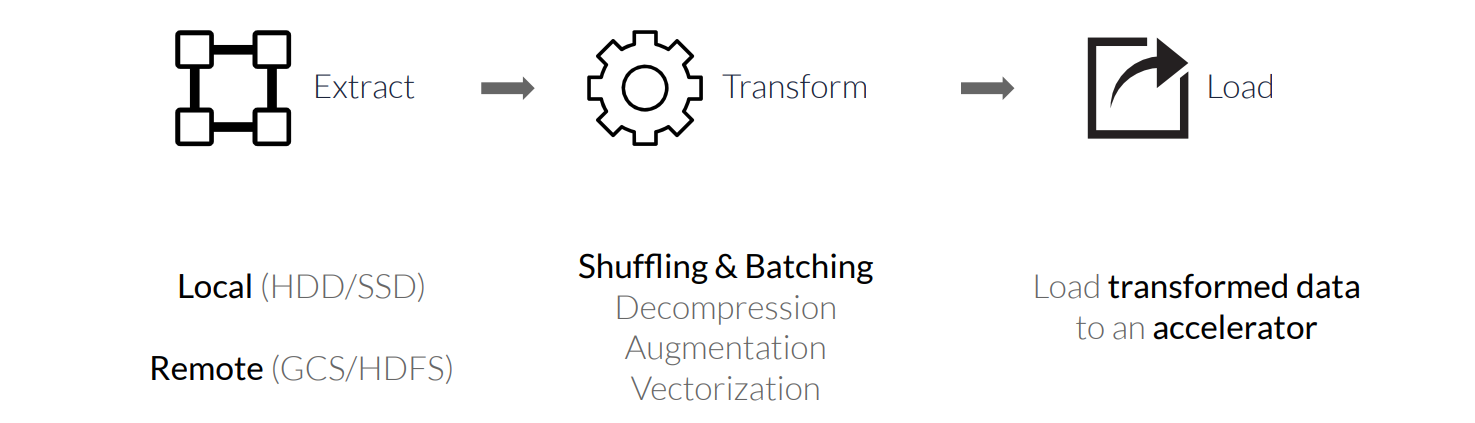

#### Inefficient ETL process

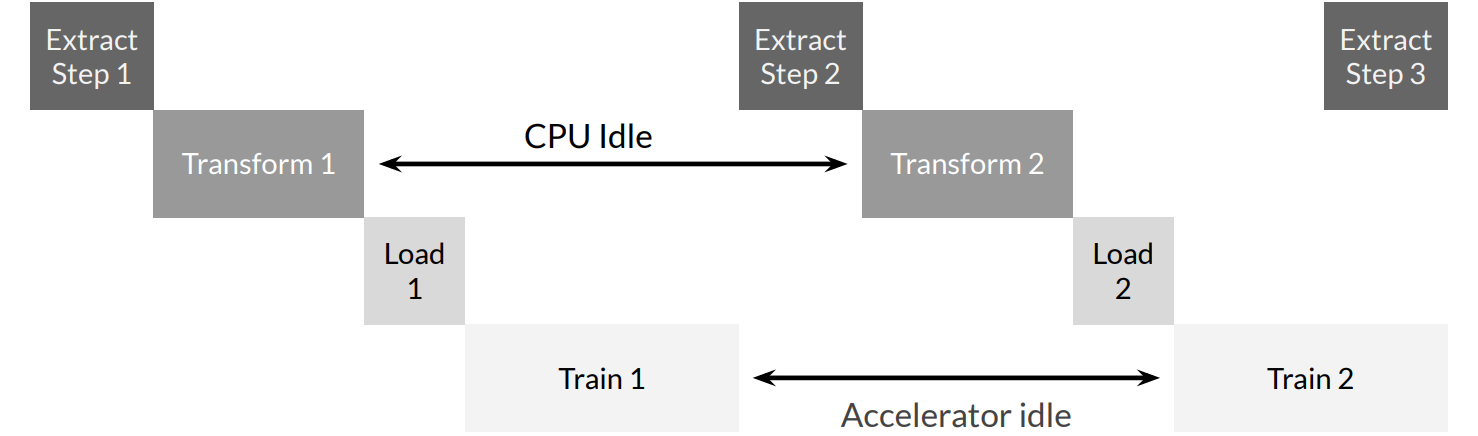

#### An improved ETL process

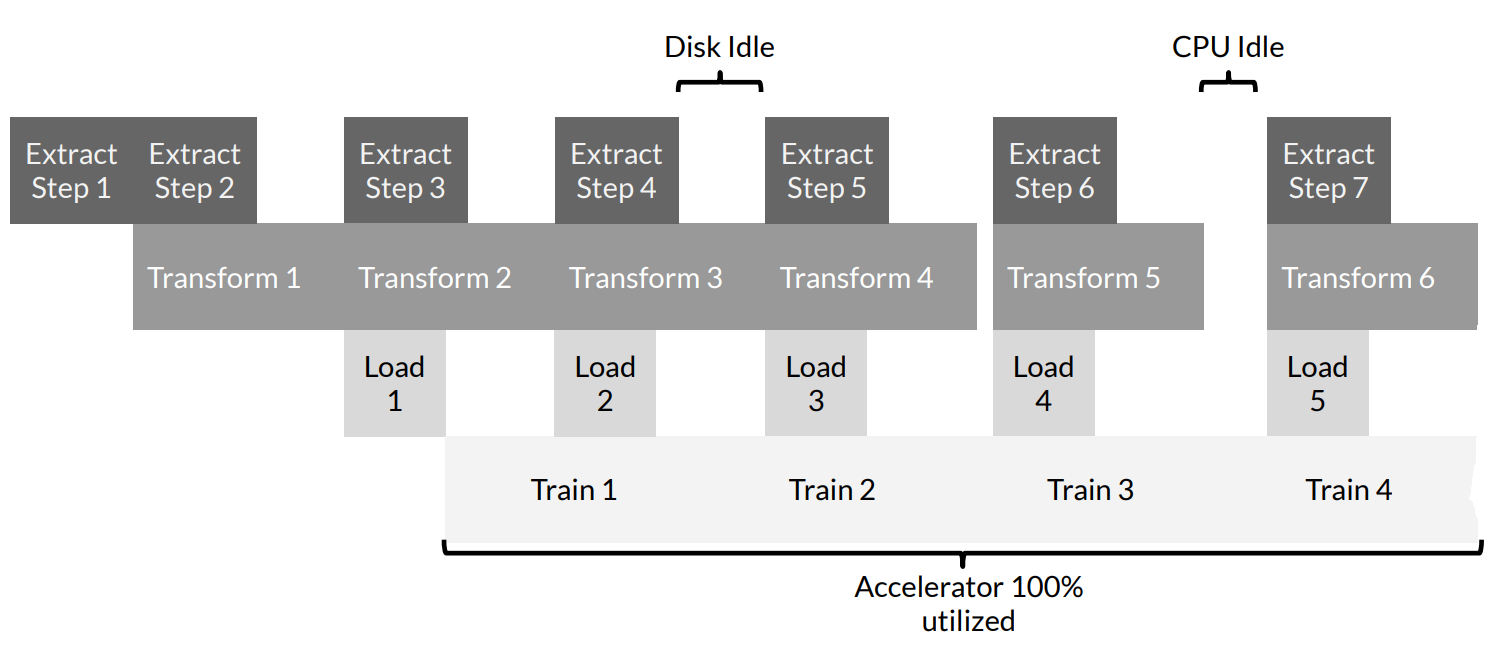

#### Pipelining


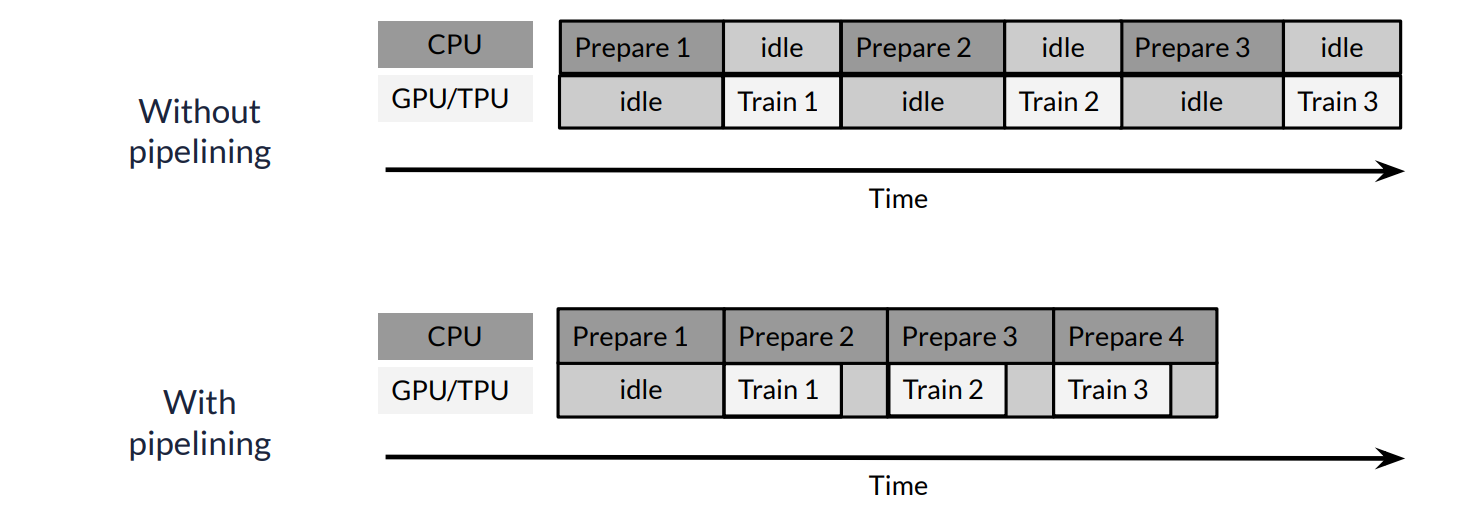

#### Optimize with prefetching


With tf.data you can use AUTOTUNE to set parallelism automatically


Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

```python
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.AUTOTUNE)
)
```

*Execution time: 0.21934373199997026*


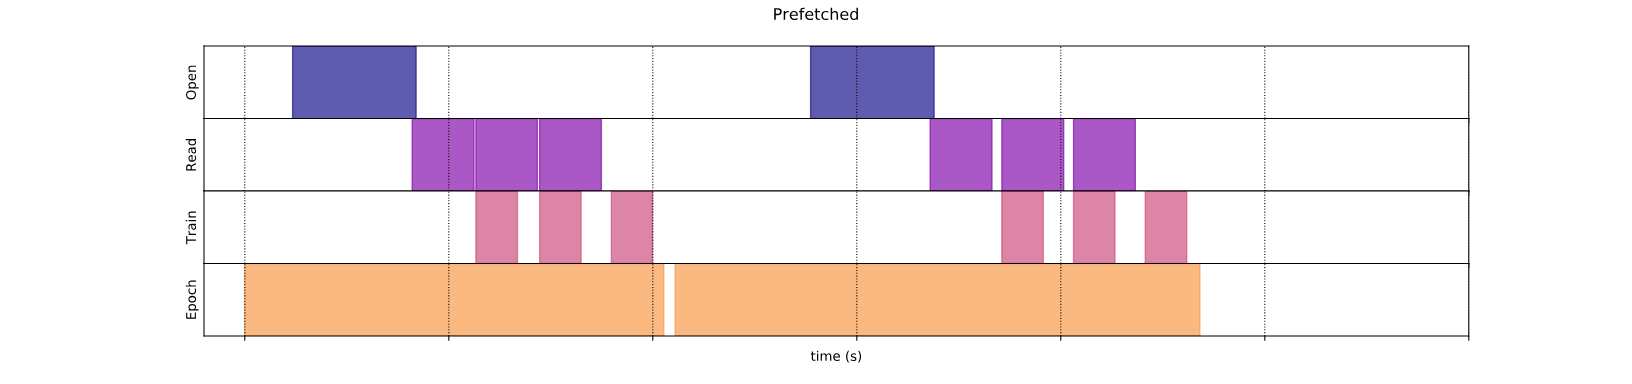

Now, as the data execution time plot shows, while the training step is running for sample 0, the input pipeline is reading the data for the sample 1, and so on.

In a real-world setting, the input data may be stored remotely (for example, on Google Cloud Storage or HDFS).
A dataset pipeline that works well when reading data locally might become bottlenecked on I/O when reading data remotely because of the following differences between local and remote storage:

- **Time-to-first-byte**: Reading the first byte of a file from remote storage can take orders of magnitude longer than from local storage.
- **Read throughput**: While remote storage typically offers large aggregate bandwidth, reading a single file might only be able to utilize a small fraction of this bandwidth.

#### Sequential interleave

The default arguments of the `tf.data.Dataset.interleave` transformation make it interleave single samples from two datasets sequentially.

```pyhon
benchmark(
    tf.data.Dataset.range(2)
    .interleave(lambda _: ArtificialDataset())
)
```

*Execution time: 0.6551544989999911*

![Data execution time plot - sequential interleave](https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg)

This data execution time plot allows to exhibit the behavior of the `interleave` transformation, fetching samples alternatively from the two datasets available.
However, no performance improvement is involved here.

#### Parallel interleave

Now, use the `num_parallel_calls` argument of the `interleave` transformation.
This loads multiple datasets in parallel, reducing the time waiting for the files to be opened.

```python
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDataset(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
)
```

*Execution time: 0.6602442260000032*

![Data execution time plot - parallel interleave method](https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg)

This time, as the data execution time plot shows, the reading of the two datasets is parallelized, reducing the global data processing time.

#### Parallelizing data transformation


When preparing data, input elements may need to be pre-processed.
To this end, the `tf.data` API offers the `tf.data.Dataset.map` transformation, which applies a user-defined function to each element of the input dataset.
Because input elements are independent of one another, the pre-processing can be parallelized across multiple CPU cores.
To make this possible, similarly to the `prefetch` and `interleave` transformations, the `map` transformation provides the `num_parallel_calls` argument to specify the level of parallelism.

Choosing the best value for the `num_parallel_calls` argument depends on your hardware, characteristics of your training data (such as its size and shape), the cost of your map function, and what other processing is happening on the CPU at the same time.
A simple heuristic is to use the number of available CPU cores.
However, as for the `prefetch` and `interleave` transformation, the `map` transformation supports `tf.data.AUTOTUNE` which will delegate the decision about what level of parallelism to use to the `tf.data` runtime.

```python
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s
```

#### Sequential mapping

Start by using the `map` transformation without parallelism as a baseline example.

```python
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)
```

*Execution time: 0.43930601499999966*

![Data execution time plot - sequential mapping method](https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg)

As for the [naive approach](#The-naive-approach), here, as the plot shows, the times spent for opening, reading, pre-processing (mapping) and training steps sum together for a single iteration.

#### Parallel mapping

Now, use the same pre-processing function but apply it in parallel on multiple samples.

```pyhon
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )
)
```

*Execution time: 0.3702878910000038*

![Data execution time - parallel mapping](https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg)

As the data plot demonstrates, the pre-processing steps overlap, reducing the overall time for a single iteration.

#### Caching



The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory or on local storage.
This will save some operations (like file opening and data reading) from being executed during each epoch.

```pyhon
benchmark(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        mapped_function
    ).cache(
    ),
    5
)
```


*Execution time: 0.3678931919999968*

![Data execution time - cached dataset method](https://www.tensorflow.org/guide/images/data_performance/cached_dataset.svg)

Here, the data execution time plot shows that when you cache a dataset, the transformations before the `cache` one (like the file opening and data reading) are executed only during the first epoch.
The next epochs will reuse the data cached by the`cache` transformation.

If the user-defined function passed into the `map` transformation is expensive, apply the `cache` transformation after the `map` transformation as long as the resulting dataset can still fit into memory or local storage.
If the user-defined function increases the space required to store the dataset beyond the cache capacity, either apply it after the `cache` transformation or consider pre-processing your data before your training job to reduce resource usage.

#### Vectorized mapping

```pyhon
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)
```

*Execution time: 0.06572783899999024*

![Data execution time - vectorized map method](https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg)

This time, the mapped function is called once and applies to a batch of sample.
As the data execution time plot shows, while the function could takes more time to execute, the overhead appear only once, improving the overall time performance.

### 1.5.4 Training Large Models -The Rise of Giant Neural Nets and Parallelism

- In 2014, the ImageNet winner was GoogleNet with 4 mil. parameters
and scoring a 74.8% top-1 accuracy
- In 2017, Squeeze-and-excitation networks achieved 82.7% top-1
accuracy with 145.8 mil. Parameters

- GPU memory only increased by factor ~ 3
- Saturated the amount of memory available in Cloud TPUs
- Need for large-scale training of giant neural networks


**Overcoming memory constraints**
* Strategy #1 - Gradient Accumulation
    - Split batches into mini-batches and only perform backprop after whole
batch
* Strategy #2 - Memory swap
    - Copy activations between CPU and memory, back and forth


### **Challenges in data parallelism**


- Communication overhead

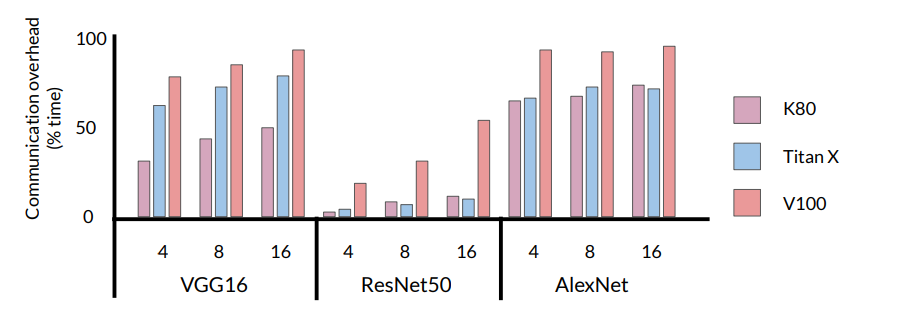

Challenges keeping accelerators busy

* Accelerators have limited memory
*  Model parallelism: large networks can be trained
    - But, accelerator compute capacity is underutilized
* Data parallelism: train same model with different input data
    - But, the maximum model size an accelerator can support is limited

#### Pipeline parallelism

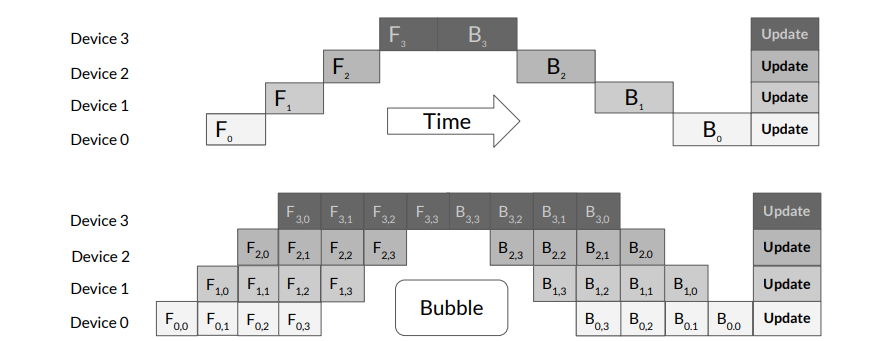

* Integrates both data and model parallelism:
    -  Divide mini-batch data into micro-batches
    - Different workers work on different micro-batches in parallel
    - Allow ML models to have significantly more parameters


#### GPipe - Key features


- Open-source TensorFlow library (using Lingvo)
- Inserts communication primitives at the partition boundaries
- Automatic parallelism to reduce memory consumption
- Gradient accumulation across micro-batches, so that model quality is
preserved
- Partitioning is heuristic-based

GPipe Results

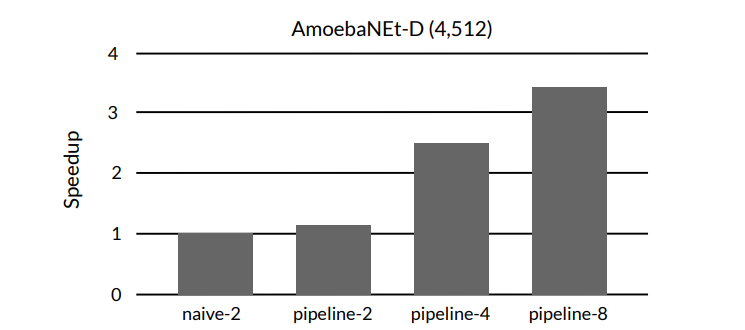

### 1.5.5 Knowledge Distillation


- Duplicate the performance of a
complex model in a simpler model
- Idea: Create a simple ‘student’
model that learns from a complex
‘teacher’ model


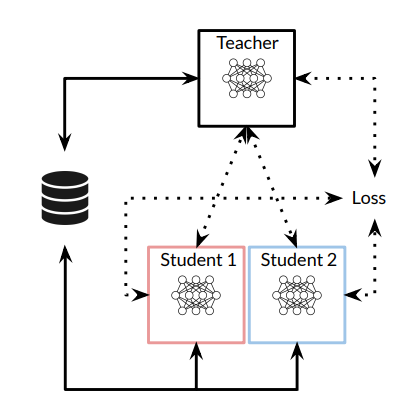

#### Knowledge Distillation Techniques


* Training objectives of the models vary
* Teacher (normal training)
    - maximizes the actual metric
* Student (knowledge transfer)
    - matches p-distribution of the teacher’s predictions to form ‘soft targets’
    - ‘Soft targets’ tell us about the knowledge learned by the teacher


#### Transferring “dark knowledge” to the student


- Improve softness of the teacher’s
distribution with ‘softmax
temperature’ (T)
- As T grows, you get more insight
about which classes the teacher finds
similar to the predicted one
$$p_i = \frac{exp(\frac{z_i}{T})}{\sum_j exp(\frac{z_j}{T})}$$


Techniques
* Approach #1: Weigh objectives (student and teacher) and combine
during backprop
* Approach #2: Compare distributions of the predictions (student and
teacher) using KL divergence


KL divergence: <br>
$$L = (1-\alpha)L_H + \alpha L_{KL}$$

#### Case Study - How to Distill Knowledge for a Q&A Task


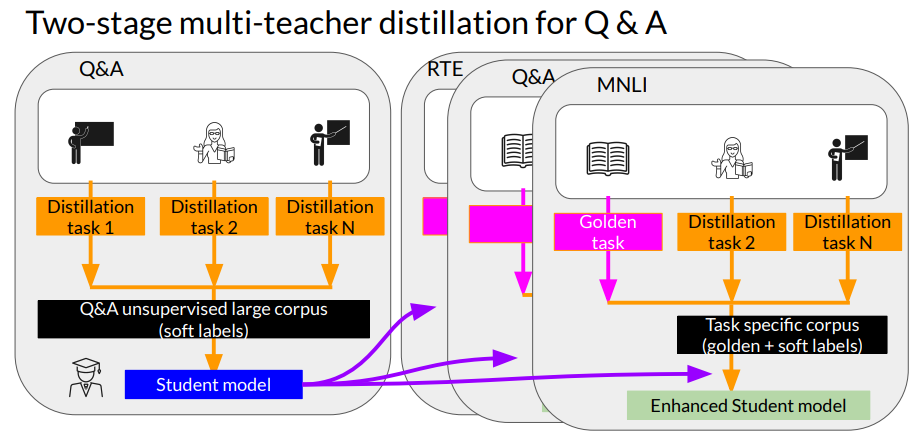

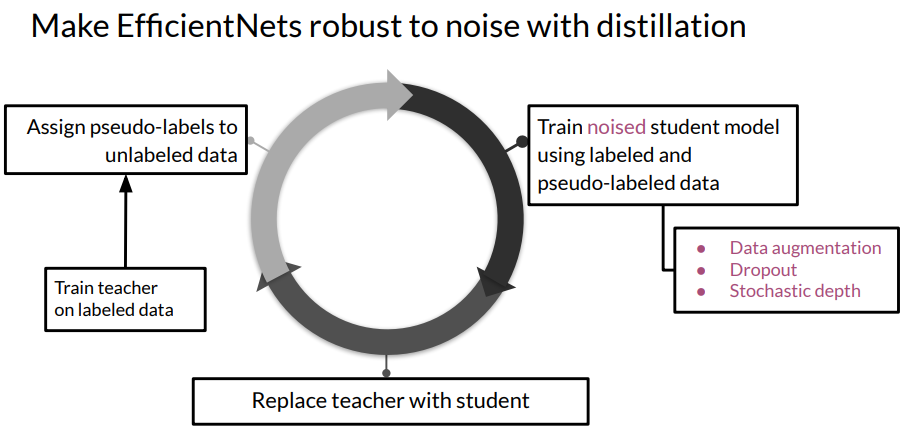

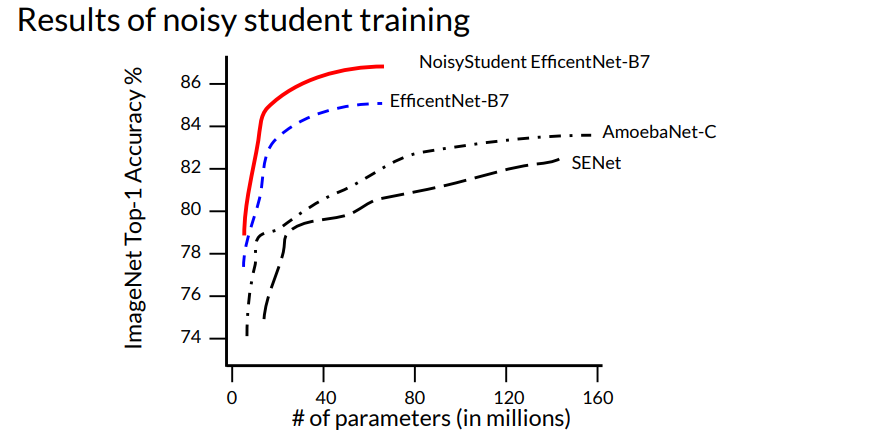